# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [5]:
for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    if "ï»¿id" in drive.columns:
        drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    if "ï»¿id" in gm.columns:
        gm["id"] = gm["ï»¿id"]
    gm = gm[(gm.home_points.notnull()) & (gm.away_points.notnull())]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    if "ï»¿id" in plys.columns:
        plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 6782
Total Drives: 175143
Total Plays: 1235916


In [6]:
croot_data = pd.DataFrame()

for i in range(2007, 2021):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44156


In [7]:
production = pd.DataFrame()
for i in range(2020, 2021):
    k = retrieveCfbDataFile('production',i)
    k['YEAR'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.TEAM == team) & (production.YEAR == yr)]
    if (len(team_slice) == 0):
        return production[(production.YEAR == yr)].OVERALL_PCT.quantile(.02)
    return team_slice.OVERALL_PCT.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,OVERALL_RANK,TEAM,OVERALL_PCT,OFFENSE_PCT,OFFENSE_RANK,DEFENSE_PCT,DEFENSE_RANK,YEAR
0,1,Northwestern,84,88,6,80,23,2020
1,2,Georgia Tech,84,74,39,94,2,2020
2,3,Houston,83,73,42,93,3,2020
3,4,East Carolina,83,87,8,79,26,2020
4,5,USC,82,77,25,87,7,2020
...,...,...,...,...,...,...,...,...
125,126,Kansas,42,41,115,44,117,2020
126,127,LSU,42,30,128,54,92,2020
127,128,Air Force,42,46,107,38,122,2020
128,129,UTEP,41,39,118,44,119,2020


In [8]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes',"ï»¿offense","drive_number","start_yards_to_goal","end_yards_to_goal"], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)


drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 174190


In [9]:
drives[(drives.index < 170795)].isna().any()

index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
away_team         False
home_team         False
dtype: bool

In [10]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [11]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [12]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.940584903533729


In [13]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,ppa,year,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,-0.512082,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,-0.220409,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1.072268,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527


In [14]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [15]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527,False,True


In [16]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data.iloc[max(min(100, int(kick_yardline + distance)), 0)].ep - ep_data.iloc[max(min(100, kick_yardline), 0)].ep - ep_data.iloc[max(min(100, int(return_yards)), 0)].ep

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            return None
#             game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
#             if (len(game_drives) == 0):
#                 print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
#                 return None
#             else:
#                 game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
#                 game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
#                 game_drives.drop(['id_y'], axis = 1, inplace=True)
#                 game_drives.dropna(inplace=True)

#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['start_yardline']
#                 ] = 100 - game_drives.start_yardline
#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['end_yardline']
#                 ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
#         print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
#         game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
#         if (len(game_pbp) == 0):
#             print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097129,0.195486
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.901643,-0.195486


In [17]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.023642,5.386628,4.863036,4.960309,5.097129,0.195486
1,Virginia Tech,4.857978,4.976358,4.613372,5.136679,5.027691,4.901643,-0.195486


In [18]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

[Local] Box Scores are not available, generating them from scratch...
[1/6782] Getting game information for ESPN game_id: 322432309...
[1/6782] Started processing game information for ESPN game_id: 322432309...
[1/6782] Skipping checking game_id 322432309 bc one of the teams isn't FBS.
[2/6782] Getting game information for ESPN game_id: 322432006...
[2/6782] Started processing game information for ESPN game_id: 322432006...
[2/6782] Completed processing game information for ESPN game_id: 322432006.
[2/6782] Aggreggated game_id 322432006 to master data copy.
[3/6782] Getting game information for ESPN game_id: 322430238...
[3/6782] Started processing game information for ESPN game_id: 322430238...
[3/6782] Completed processing game information for ESPN game_id: 322430238.
[3/6782] Aggreggated game_id 322430238 to master data copy.
[4/6782] Getting game information for ESPN game_id: 322432117...
[4/6782] Started processing game information for ESPN game_id: 322432117...
[4/6782] Skipping 

[35/6782] Completed processing game information for ESPN game_id: 322450025.
[35/6782] Aggreggated game_id 322450025 to master data copy.
[36/6782] Getting game information for ESPN game_id: 322450103...
[36/6782] Started processing game information for ESPN game_id: 322450103...
[36/6782] Completed processing game information for ESPN game_id: 322450103.
[36/6782] Aggreggated game_id 322450103 to master data copy.
[37/6782] Getting game information for ESPN game_id: 322450275...
[37/6782] Started processing game information for ESPN game_id: 322450275...
[37/6782] Skipping checking game_id 322450275 bc one of the teams isn't FBS.
[38/6782] Getting game information for ESPN game_id: 322452509...
[38/6782] Started processing game information for ESPN game_id: 322452509...
[38/6782] Skipping checking game_id 322452509 bc one of the teams isn't FBS.
[39/6782] Getting game information for ESPN game_id: 322450158...
[39/6782] Started processing game information for ESPN game_id: 322450158..

[68/6782] Completed processing game information for ESPN game_id: 322450333.
[68/6782] Aggreggated game_id 322450333 to master data copy.
[69/6782] Getting game information for ESPN game_id: 322450278...
[69/6782] Started processing game information for ESPN game_id: 322450278...
[69/6782] Skipping checking game_id 322450278 bc one of the teams isn't FBS.
[70/6782] Getting game information for ESPN game_id: 322452483...
[70/6782] Started processing game information for ESPN game_id: 322452483...
[70/6782] Completed processing game information for ESPN game_id: 322452483.
[70/6782] Aggreggated game_id 322452483 to master data copy.
[71/6782] Getting game information for ESPN game_id: 322452638...
[71/6782] Started processing game information for ESPN game_id: 322452638...
[71/6782] Completed processing game information for ESPN game_id: 322452638.
[71/6782] Aggreggated game_id 322452638 to master data copy.
[72/6782] Getting game information for ESPN game_id: 322450264...
[72/6782] Star

[100/6782] Completed processing game information for ESPN game_id: 322520245.
[100/6782] Aggreggated game_id 322520245 to master data copy.
[101/6782] Getting game information for ESPN game_id: 322520333...
[101/6782] Started processing game information for ESPN game_id: 322520333...
[101/6782] Completed processing game information for ESPN game_id: 322520333.
[101/6782] Aggreggated game_id 322520333 to master data copy.
[102/6782] Getting game information for ESPN game_id: 322520164...
[102/6782] Started processing game information for ESPN game_id: 322520164...
[102/6782] Skipping checking game_id 322520164 bc one of the teams isn't FBS.
[103/6782] Getting game information for ESPN game_id: 322520183...
[103/6782] Started processing game information for ESPN game_id: 322520183...
[103/6782] Completed processing game information for ESPN game_id: 322520183.
[103/6782] Aggreggated game_id 322520183 to master data copy.
[104/6782] Getting game information for ESPN game_id: 322522117...


[133/6782] Completed processing game information for ESPN game_id: 322520145.
[133/6782] Aggreggated game_id 322520145 to master data copy.
[134/6782] Getting game information for ESPN game_id: 322520189...
[134/6782] Started processing game information for ESPN game_id: 322520189...
[134/6782] Skipping checking game_id 322520189 bc one of the teams isn't FBS.
[135/6782] Getting game information for ESPN game_id: 322520195...
[135/6782] Started processing game information for ESPN game_id: 322520195...
[135/6782] Completed processing game information for ESPN game_id: 322520195.
[135/6782] Aggreggated game_id 322520195 to master data copy.
[136/6782] Getting game information for ESPN game_id: 322520021...
[136/6782] Started processing game information for ESPN game_id: 322520021...
[136/6782] Completed processing game information for ESPN game_id: 322520021.
[136/6782] Aggreggated game_id 322520021 to master data copy.
[137/6782] Getting game information for ESPN game_id: 322520096...


[164/6782] Completed processing game information for ESPN game_id: 322590120.
[164/6782] Aggreggated game_id 322590120 to master data copy.
[165/6782] Getting game information for ESPN game_id: 322590228...
[165/6782] Started processing game information for ESPN game_id: 322590228...
[165/6782] Skipping checking game_id 322590228 bc one of the teams isn't FBS.
[166/6782] Getting game information for ESPN game_id: 322592483...
[166/6782] Started processing game information for ESPN game_id: 322592483...
[166/6782] Skipping checking game_id 322592483 bc one of the teams isn't FBS.
[167/6782] Getting game information for ESPN game_id: 322590130...
[167/6782] Started processing game information for ESPN game_id: 322590130...
[167/6782] Completed processing game information for ESPN game_id: 322590130.
[167/6782] Aggreggated game_id 322590130 to master data copy.
[168/6782] Getting game information for ESPN game_id: 322590008...
[168/6782] Started processing game information for ESPN game_i

[196/6782] Completed processing game information for ESPN game_id: 322590142.
[196/6782] Aggreggated game_id 322590142 to master data copy.
[197/6782] Getting game information for ESPN game_id: 322592579...
[197/6782] Started processing game information for ESPN game_id: 322592579...
[197/6782] Completed processing game information for ESPN game_id: 322592579.
[197/6782] Aggreggated game_id 322592579 to master data copy.
[198/6782] Getting game information for ESPN game_id: 322592306...
[198/6782] Started processing game information for ESPN game_id: 322592306...
[198/6782] Completed processing game information for ESPN game_id: 322592306.
[198/6782] Aggreggated game_id 322592306 to master data copy.
[199/6782] Getting game information for ESPN game_id: 322590239...
[199/6782] Started processing game information for ESPN game_id: 322590239...
[199/6782] Skipping checking game_id 322590239 bc one of the teams isn't FBS.
[200/6782] Getting game information for ESPN game_id: 322592440...


[227/6782] Completed processing game information for ESPN game_id: 322660194.
[227/6782] Aggreggated game_id 322660194 to master data copy.
[228/6782] Getting game information for ESPN game_id: 322660259...
[228/6782] Started processing game information for ESPN game_id: 322660259...
[228/6782] Completed processing game information for ESPN game_id: 322660259.
[228/6782] Aggreggated game_id 322660259 to master data copy.
[229/6782] Getting game information for ESPN game_id: 322660154...
[229/6782] Started processing game information for ESPN game_id: 322660154...
[229/6782] Completed processing game information for ESPN game_id: 322660154.
[229/6782] Aggreggated game_id 322660154 to master data copy.
[230/6782] Getting game information for ESPN game_id: 322662636...
[230/6782] Started processing game information for ESPN game_id: 322662636...
[230/6782] Skipping checking game_id 322662636 bc one of the teams isn't FBS.
[231/6782] Getting game information for ESPN game_id: 322660195...


[258/6782] Completed processing game information for ESPN game_id: 322660036.
[258/6782] Aggreggated game_id 322660036 to master data copy.
[259/6782] Getting game information for ESPN game_id: 322660008...
[259/6782] Started processing game information for ESPN game_id: 322660008...
[259/6782] Completed processing game information for ESPN game_id: 322660008.
[259/6782] Aggreggated game_id 322660008 to master data copy.
[260/6782] Getting game information for ESPN game_id: 322662032...
[260/6782] Started processing game information for ESPN game_id: 322662032...
[260/6782] Skipping checking game_id 322662032 bc one of the teams isn't FBS.
[261/6782] Getting game information for ESPN game_id: 322660098...
[261/6782] Started processing game information for ESPN game_id: 322660098...
[261/6782] Completed processing game information for ESPN game_id: 322660098.
[261/6782] Aggreggated game_id 322660098 to master data copy.
[262/6782] Getting game information for ESPN game_id: 322660245...


[288/6782] Completed processing game information for ESPN game_id: 322732309.
[288/6782] Aggreggated game_id 322732309 to master data copy.
[289/6782] Getting game information for ESPN game_id: 322730245...
[289/6782] Started processing game information for ESPN game_id: 322730245...
[289/6782] Completed processing game information for ESPN game_id: 322730245.
[289/6782] Aggreggated game_id 322730245 to master data copy.
[290/6782] Getting game information for ESPN game_id: 322730154...
[290/6782] Started processing game information for ESPN game_id: 322730154...
[290/6782] Completed processing game information for ESPN game_id: 322730154.
[290/6782] Aggreggated game_id 322730154 to master data copy.
[291/6782] Getting game information for ESPN game_id: 322732006...
[291/6782] Started processing game information for ESPN game_id: 322732006...
[291/6782] Completed processing game information for ESPN game_id: 322732006.
[291/6782] Aggreggated game_id 322732006 to master data copy.
[292/

[318/6782] Completed processing game information for ESPN game_id: 322730309.
[318/6782] Aggreggated game_id 322730309 to master data copy.
[319/6782] Getting game information for ESPN game_id: 322732032...
[319/6782] Started processing game information for ESPN game_id: 322732032...
[319/6782] Completed processing game information for ESPN game_id: 322732032.
[319/6782] Aggreggated game_id 322732032 to master data copy.
[320/6782] Getting game information for ESPN game_id: 322730151...
[320/6782] Started processing game information for ESPN game_id: 322730151...
[320/6782] Completed processing game information for ESPN game_id: 322730151.
[320/6782] Aggreggated game_id 322730151 to master data copy.
[321/6782] Getting game information for ESPN game_id: 322732711...
[321/6782] Started processing game information for ESPN game_id: 322732711...
[321/6782] Completed processing game information for ESPN game_id: 322732711.
[321/6782] Aggreggated game_id 322732711 to master data copy.
[322/

[347/6782] Completed processing game information for ESPN game_id: 322800153.
[347/6782] Aggreggated game_id 322800153 to master data copy.
[348/6782] Getting game information for ESPN game_id: 322802199...
[348/6782] Started processing game information for ESPN game_id: 322802199...
[348/6782] Completed processing game information for ESPN game_id: 322802199.
[348/6782] Aggreggated game_id 322802199 to master data copy.
[349/6782] Getting game information for ESPN game_id: 322802711...
[349/6782] Started processing game information for ESPN game_id: 322802711...
[349/6782] Completed processing game information for ESPN game_id: 322802711.
[349/6782] Aggreggated game_id 322802711 to master data copy.
[350/6782] Getting game information for ESPN game_id: 322802006...
[350/6782] Started processing game information for ESPN game_id: 322802006...
[350/6782] Completed processing game information for ESPN game_id: 322802006.
[350/6782] Aggreggated game_id 322802006 to master data copy.
[351/

[377/6782] Completed processing game information for ESPN game_id: 322802440.
[377/6782] Aggreggated game_id 322802440 to master data copy.
[378/6782] Getting game information for ESPN game_id: 322802579...
[378/6782] Started processing game information for ESPN game_id: 322802579...
[378/6782] Completed processing game information for ESPN game_id: 322802579.
[378/6782] Aggreggated game_id 322802579 to master data copy.
[379/6782] Getting game information for ESPN game_id: 322800087...
[379/6782] Started processing game information for ESPN game_id: 322800087...
[379/6782] Completed processing game information for ESPN game_id: 322800087.
[379/6782] Aggreggated game_id 322800087 to master data copy.
[380/6782] Getting game information for ESPN game_id: 322800194...
[380/6782] Started processing game information for ESPN game_id: 322800194...
[380/6782] Completed processing game information for ESPN game_id: 322800194.
[380/6782] Aggreggated game_id 322800194 to master data copy.
[381/

[406/6782] Completed processing game information for ESPN game_id: 322870026.
[406/6782] Aggreggated game_id 322870026 to master data copy.
[407/6782] Getting game information for ESPN game_id: 322872439...
[407/6782] Started processing game information for ESPN game_id: 322872439...
[407/6782] Completed processing game information for ESPN game_id: 322872439.
[407/6782] Aggreggated game_id 322872439 to master data copy.
[408/6782] Getting game information for ESPN game_id: 322870258...
[408/6782] Started processing game information for ESPN game_id: 322870258...
[408/6782] Completed processing game information for ESPN game_id: 322870258.
[408/6782] Aggreggated game_id 322870258 to master data copy.
[409/6782] Getting game information for ESPN game_id: 322872050...
[409/6782] Started processing game information for ESPN game_id: 322872050...
[409/6782] Completed processing game information for ESPN game_id: 322872050.
[409/6782] Aggreggated game_id 322872050 to master data copy.
[410/

[436/6782] Completed processing game information for ESPN game_id: 322872116.
[436/6782] Aggreggated game_id 322872116 to master data copy.
[437/6782] Getting game information for ESPN game_id: 322872348...
[437/6782] Started processing game information for ESPN game_id: 322872348...
[437/6782] Completed processing game information for ESPN game_id: 322872348.
[437/6782] Aggreggated game_id 322872348 to master data copy.
[438/6782] Getting game information for ESPN game_id: 322870344...
[438/6782] Started processing game information for ESPN game_id: 322870344...
[438/6782] Completed processing game information for ESPN game_id: 322870344.
[438/6782] Aggreggated game_id 322870344 to master data copy.
[439/6782] Getting game information for ESPN game_id: 322870265...
[439/6782] Started processing game information for ESPN game_id: 322870265...
[439/6782] Completed processing game information for ESPN game_id: 322870265.
[439/6782] Aggreggated game_id 322870265 to master data copy.
[440/

[465/6782] Completed processing game information for ESPN game_id: 322940202.
[465/6782] Aggreggated game_id 322940202 to master data copy.
[466/6782] Getting game information for ESPN game_id: 322942117...
[466/6782] Started processing game information for ESPN game_id: 322942117...
[466/6782] Completed processing game information for ESPN game_id: 322942117.
[466/6782] Aggreggated game_id 322942117 to master data copy.
[467/6782] Getting game information for ESPN game_id: 322942309...
[467/6782] Started processing game information for ESPN game_id: 322942309...
[467/6782] Completed processing game information for ESPN game_id: 322942309.
[467/6782] Aggreggated game_id 322942309 to master data copy.
[468/6782] Getting game information for ESPN game_id: 322942084...
[468/6782] Started processing game information for ESPN game_id: 322942084...
[468/6782] Completed processing game information for ESPN game_id: 322942084.
[468/6782] Aggreggated game_id 322942084 to master data copy.
[469/

[494/6782] Completed processing game information for ESPN game_id: 322940278.
[494/6782] Aggreggated game_id 322940278 to master data copy.
[495/6782] Getting game information for ESPN game_id: 322940204...
[495/6782] Started processing game information for ESPN game_id: 322940204...
[495/6782] Completed processing game information for ESPN game_id: 322940204.
[495/6782] Aggreggated game_id 322940204 to master data copy.
[496/6782] Getting game information for ESPN game_id: 322942440...
[496/6782] Started processing game information for ESPN game_id: 322942440...
[496/6782] Completed processing game information for ESPN game_id: 322942440.
[496/6782] Aggreggated game_id 322942440 to master data copy.
[497/6782] Getting game information for ESPN game_id: 322970309...
[497/6782] Started processing game information for ESPN game_id: 322970309...
[497/6782] Completed processing game information for ESPN game_id: 322970309.
[497/6782] Aggreggated game_id 322970309 to master data copy.
[498/

[523/6782] Completed processing game information for ESPN game_id: 323010012.
[523/6782] Aggreggated game_id 323010012 to master data copy.
[524/6782] Getting game information for ESPN game_id: 323012751...
[524/6782] Started processing game information for ESPN game_id: 323012751...
[524/6782] Completed processing game information for ESPN game_id: 323012751.
[524/6782] Aggreggated game_id 323012751 to master data copy.
[525/6782] Getting game information for ESPN game_id: 323012655...
[525/6782] Started processing game information for ESPN game_id: 323012655...
[525/6782] Completed processing game information for ESPN game_id: 323012655.
[525/6782] Aggreggated game_id 323012655 to master data copy.
[526/6782] Getting game information for ESPN game_id: 323010275...
[526/6782] Started processing game information for ESPN game_id: 323010275...
[526/6782] Completed processing game information for ESPN game_id: 323010275.
[526/6782] Aggreggated game_id 323010275 to master data copy.
[527/

[552/6782] Completed processing game information for ESPN game_id: 323010333.
[552/6782] Aggreggated game_id 323010333 to master data copy.
[553/6782] Getting game information for ESPN game_id: 323010254...
[553/6782] Started processing game information for ESPN game_id: 323010254...
[553/6782] Completed processing game information for ESPN game_id: 323010254.
[553/6782] Aggreggated game_id 323010254 to master data copy.
[554/6782] Getting game information for ESPN game_id: 323010264...
[554/6782] Started processing game information for ESPN game_id: 323010264...
[554/6782] Completed processing game information for ESPN game_id: 323010264.
[554/6782] Aggreggated game_id 323010264 to master data copy.
[555/6782] Getting game information for ESPN game_id: 323060195...
[555/6782] Started processing game information for ESPN game_id: 323060195...
[555/6782] Completed processing game information for ESPN game_id: 323060195.
[555/6782] Aggreggated game_id 323060195 to master data copy.
[556/

[581/6782] Completed processing game information for ESPN game_id: 323082509.
[581/6782] Aggreggated game_id 323082509 to master data copy.
[582/6782] Getting game information for ESPN game_id: 323080127...
[582/6782] Started processing game information for ESPN game_id: 323080127...
[582/6782] Completed processing game information for ESPN game_id: 323080127.
[582/6782] Aggreggated game_id 323080127 to master data copy.
[583/6782] Getting game information for ESPN game_id: 323082641...
[583/6782] Started processing game information for ESPN game_id: 323082641...
[583/6782] Completed processing game information for ESPN game_id: 323082641.
[583/6782] Aggreggated game_id 323082641 to master data copy.
[584/6782] Getting game information for ESPN game_id: 323082459...
[584/6782] Started processing game information for ESPN game_id: 323082459...
[584/6782] Completed processing game information for ESPN game_id: 323082459.
[584/6782] Aggreggated game_id 323082459 to master data copy.
[585/

[610/6782] Completed processing game information for ESPN game_id: 323080068.
[610/6782] Aggreggated game_id 323080068 to master data copy.
[611/6782] Getting game information for ESPN game_id: 323112649...
[611/6782] Started processing game information for ESPN game_id: 323112649...
[611/6782] Completed processing game information for ESPN game_id: 323112649.
[611/6782] Aggreggated game_id 323112649 to master data copy.
[612/6782] Getting game information for ESPN game_id: 323120195...
[612/6782] Started processing game information for ESPN game_id: 323120195...
[612/6782] Completed processing game information for ESPN game_id: 323120195.
[612/6782] Aggreggated game_id 323120195 to master data copy.
[613/6782] Getting game information for ESPN game_id: 323132032...
[613/6782] Started processing game information for ESPN game_id: 323132032...
[613/6782] Completed processing game information for ESPN game_id: 323132032.
[613/6782] Aggreggated game_id 323132032 to master data copy.
[614/

[639/6782] Completed processing game information for ESPN game_id: 323150333.
[639/6782] Aggreggated game_id 323150333 to master data copy.
[640/6782] Getting game information for ESPN game_id: 323150228...
[640/6782] Started processing game information for ESPN game_id: 323150228...
[640/6782] Completed processing game information for ESPN game_id: 323150228.
[640/6782] Aggreggated game_id 323150228 to master data copy.
[641/6782] Getting game information for ESPN game_id: 323152653...
[641/6782] Started processing game information for ESPN game_id: 323152653...
[641/6782] Completed processing game information for ESPN game_id: 323152653.
[641/6782] Aggreggated game_id 323152653 to master data copy.
[642/6782] Getting game information for ESPN game_id: 323150166...
[642/6782] Started processing game information for ESPN game_id: 323150166...
[642/6782] Completed processing game information for ESPN game_id: 323150166.
[642/6782] Aggreggated game_id 323150166 to master data copy.
[643/

[669/6782] Completed processing game information for ESPN game_id: 323192459.
[669/6782] Aggreggated game_id 323192459 to master data copy.
[670/6782] Getting game information for ESPN game_id: 323200258...
[670/6782] Started processing game information for ESPN game_id: 323200258...
[670/6782] Completed processing game information for ESPN game_id: 323200258.
[670/6782] Aggreggated game_id 323200258 to master data copy.
[671/6782] Getting game information for ESPN game_id: 323212226...
[671/6782] Started processing game information for ESPN game_id: 323212226...
[671/6782] Completed processing game information for ESPN game_id: 323212226.
[671/6782] Aggreggated game_id 323212226 to master data copy.
[672/6782] Getting game information for ESPN game_id: 323212005...
[672/6782] Started processing game information for ESPN game_id: 323212005...
[672/6782] Completed processing game information for ESPN game_id: 323212005.
[672/6782] Aggreggated game_id 323212005 to master data copy.
[673/

[699/6782] Completed processing game information for ESPN game_id: 323220158.
[699/6782] Aggreggated game_id 323220158 to master data copy.
[700/6782] Getting game information for ESPN game_id: 323220197...
[700/6782] Started processing game information for ESPN game_id: 323220197...
[700/6782] Completed processing game information for ESPN game_id: 323220197.
[700/6782] Aggreggated game_id 323220197 to master data copy.
[701/6782] Getting game information for ESPN game_id: 323220245...
[701/6782] Started processing game information for ESPN game_id: 323220245...
[701/6782] Skipping checking game_id 323220245 bc one of the teams isn't FBS.
[702/6782] Getting game information for ESPN game_id: 323220099...
[702/6782] Started processing game information for ESPN game_id: 323220099...
[702/6782] Completed processing game information for ESPN game_id: 323220099.
[702/6782] Aggreggated game_id 323220099 to master data copy.
[703/6782] Getting game information for ESPN game_id: 323220087...


[729/6782] Completed processing game information for ESPN game_id: 323220204.
[729/6782] Aggreggated game_id 323220204 to master data copy.
[730/6782] Getting game information for ESPN game_id: 323252649...
[730/6782] Started processing game information for ESPN game_id: 323252649...
[730/6782] Completed processing game information for ESPN game_id: 323252649.
[730/6782] Aggreggated game_id 323252649 to master data copy.
[731/6782] Getting game information for ESPN game_id: 323270251...
[731/6782] Started processing game information for ESPN game_id: 323270251...
[731/6782] Completed processing game information for ESPN game_id: 323270251.
[731/6782] Aggreggated game_id 323270251 to master data copy.
[732/6782] Getting game information for ESPN game_id: 323282309...
[732/6782] Started processing game information for ESPN game_id: 323282309...
[732/6782] Completed processing game information for ESPN game_id: 323282309.
[732/6782] Aggreggated game_id 323282309 to master data copy.
[733/

[758/6782] Completed processing game information for ESPN game_id: 323292636.
[758/6782] Aggreggated game_id 323292636 to master data copy.
[759/6782] Getting game information for ESPN game_id: 323292641...
[759/6782] Started processing game information for ESPN game_id: 323292641...
[759/6782] Completed processing game information for ESPN game_id: 323292641.
[759/6782] Aggreggated game_id 323292641 to master data copy.
[760/6782] Getting game information for ESPN game_id: 323290152...
[760/6782] Started processing game information for ESPN game_id: 323290152...
[760/6782] Completed processing game information for ESPN game_id: 323290152.
[760/6782] Aggreggated game_id 323290152 to master data copy.
[761/6782] Getting game information for ESPN game_id: 323290328...
[761/6782] Started processing game information for ESPN game_id: 323290328...
[761/6782] Skipping checking game_id 323290328 bc one of the teams isn't FBS.
[762/6782] Getting game information for ESPN game_id: 323290204...


[787/6782] Completed processing game information for ESPN game_id: 323340164.
[787/6782] Aggreggated game_id 323340164 to master data copy.
[788/6782] Getting game information for ESPN game_id: 323352309...
[788/6782] Started processing game information for ESPN game_id: 323352309...
[788/6782] Completed processing game information for ESPN game_id: 323352309.
[788/6782] Aggreggated game_id 323352309 to master data copy.
[789/6782] Getting game information for ESPN game_id: 323350024...
[789/6782] Started processing game information for ESPN game_id: 323350024...
[789/6782] Completed processing game information for ESPN game_id: 323350024.
[789/6782] Aggreggated game_id 323350024 to master data copy.
[790/6782] Getting game information for ESPN game_id: 323360202...
[790/6782] Started processing game information for ESPN game_id: 323360202...
[790/6782] Completed processing game information for ESPN game_id: 323360202.
[790/6782] Aggreggated game_id 323360202 to master data copy.
[791/

[819/6782] Completed processing game information for ESPN game_id: 332410254.
[819/6782] Aggreggated game_id 332410254 to master data copy.
[820/6782] Getting game information for ESPN game_id: 332410238...
[820/6782] Started processing game information for ESPN game_id: 332410238...
[820/6782] Completed processing game information for ESPN game_id: 332410238.
[820/6782] Aggreggated game_id 332410238 to master data copy.
[821/6782] Getting game information for ESPN game_id: 332410023...
[821/6782] Started processing game information for ESPN game_id: 332410023...
[821/6782] Skipping checking game_id 332410023 bc one of the teams isn't FBS.
[822/6782] Getting game information for ESPN game_id: 332410278...
[822/6782] Started processing game information for ESPN game_id: 332410278...
[822/6782] Completed processing game information for ESPN game_id: 332410278.
[822/6782] Aggreggated game_id 332410278 to master data copy.
[823/6782] Getting game information for ESPN game_id: 332410062...


[852/6782] Completed processing game information for ESPN game_id: 332430008.
[852/6782] Aggreggated game_id 332430008 to master data copy.
[853/6782] Getting game information for ESPN game_id: 332430259...
[853/6782] Started processing game information for ESPN game_id: 332430259...
[853/6782] Completed processing game information for ESPN game_id: 332430259.
[853/6782] Aggreggated game_id 332430259 to master data copy.
[854/6782] Getting game information for ESPN game_id: 332432199...
[854/6782] Started processing game information for ESPN game_id: 332432199...
[854/6782] Skipping checking game_id 332432199 bc one of the teams isn't FBS.
[855/6782] Getting game information for ESPN game_id: 332430204...
[855/6782] Started processing game information for ESPN game_id: 332430204...
[855/6782] Skipping checking game_id 332430204 bc one of the teams isn't FBS.
[856/6782] Getting game information for ESPN game_id: 332432633...
[856/6782] Started processing game information for ESPN game_i

[884/6782] Completed processing game information for ESPN game_id: 332490103.
[884/6782] Aggreggated game_id 332490103 to master data copy.
[885/6782] Getting game information for ESPN game_id: 332492229...
[885/6782] Started processing game information for ESPN game_id: 332492229...
[885/6782] Completed processing game information for ESPN game_id: 332492229.
[885/6782] Aggreggated game_id 332492229 to master data copy.
[886/6782] Getting game information for ESPN game_id: 332502294...
[886/6782] Started processing game information for ESPN game_id: 332502294...
[886/6782] Skipping checking game_id 332502294 bc one of the teams isn't FBS.
[887/6782] Getting game information for ESPN game_id: 332502309...
[887/6782] Started processing game information for ESPN game_id: 332502309...
[887/6782] Completed processing game information for ESPN game_id: 332502309.
[887/6782] Aggreggated game_id 332502309 to master data copy.
[888/6782] Getting game information for ESPN game_id: 332502509...


[916/6782] Completed processing game information for ESPN game_id: 332502655.
[916/6782] Aggreggated game_id 332502655 to master data copy.
[917/6782] Getting game information for ESPN game_id: 332500120...
[917/6782] Started processing game information for ESPN game_id: 332500120...
[917/6782] Completed processing game information for ESPN game_id: 332500120.
[917/6782] Aggreggated game_id 332500120 to master data copy.
[918/6782] Getting game information for ESPN game_id: 332502751...
[918/6782] Started processing game information for ESPN game_id: 332502751...
[918/6782] Skipping checking game_id 332502751 bc one of the teams isn't FBS.
[919/6782] Getting game information for ESPN game_id: 332500061...
[919/6782] Started processing game information for ESPN game_id: 332500061...
[919/6782] Completed processing game information for ESPN game_id: 332500061.
[919/6782] Aggreggated game_id 332500061 to master data copy.
[920/6782] Getting game information for ESPN game_id: 332500235...


[949/6782] Completed processing game information for ESPN game_id: 332500166.
[949/6782] Aggreggated game_id 332500166 to master data copy.
[950/6782] Getting game information for ESPN game_id: 332500130...
[950/6782] Started processing game information for ESPN game_id: 332500130...
[950/6782] Completed processing game information for ESPN game_id: 332500130.
[950/6782] Aggreggated game_id 332500130 to master data copy.
[951/6782] Getting game information for ESPN game_id: 332502567...
[951/6782] Started processing game information for ESPN game_id: 332502567...
[951/6782] Skipping checking game_id 332502567 bc one of the teams isn't FBS.
[952/6782] Getting game information for ESPN game_id: 332502440...
[952/6782] Started processing game information for ESPN game_id: 332502440...
[952/6782] Skipping checking game_id 332502440 bc one of the teams isn't FBS.
[953/6782] Getting game information for ESPN game_id: 332500278...
[953/6782] Started processing game information for ESPN game_i

[980/6782] Completed processing game information for ESPN game_id: 332572483.
[980/6782] Aggreggated game_id 332572483 to master data copy.
[981/6782] Getting game information for ESPN game_id: 332572084...
[981/6782] Started processing game information for ESPN game_id: 332572084...
[981/6782] Skipping checking game_id 332572084 bc one of the teams isn't FBS.
[982/6782] Getting game information for ESPN game_id: 332572426...
[982/6782] Started processing game information for ESPN game_id: 332572426...
[982/6782] Skipping checking game_id 332572426 bc one of the teams isn't FBS.
[983/6782] Getting game information for ESPN game_id: 332570150...
[983/6782] Started processing game information for ESPN game_id: 332570150...
[983/6782] Completed processing game information for ESPN game_id: 332570150.
[983/6782] Aggreggated game_id 332570150 to master data copy.
[984/6782] Getting game information for ESPN game_id: 332572751...
[984/6782] Started processing game information for ESPN game_i

[1012/6782] Completed processing game information for ESPN game_id: 332570195.
[1012/6782] Aggreggated game_id 332570195 to master data copy.
[1013/6782] Getting game information for ESPN game_id: 332570077...
[1013/6782] Started processing game information for ESPN game_id: 332570077...
[1013/6782] Completed processing game information for ESPN game_id: 332570077.
[1013/6782] Aggreggated game_id 332570077 to master data copy.
[1014/6782] Getting game information for ESPN game_id: 332570254...
[1014/6782] Started processing game information for ESPN game_id: 332570254...
[1014/6782] Completed processing game information for ESPN game_id: 332570254.
[1014/6782] Aggreggated game_id 332570254 to master data copy.
[1015/6782] Getting game information for ESPN game_id: 332572439...
[1015/6782] Started processing game information for ESPN game_id: 332572439...
[1015/6782] Completed processing game information for ESPN game_id: 332572439.
[1015/6782] Aggreggated game_id 332572439 to master da

[1042/6782] Completed processing game information for ESPN game_id: 332640164.
[1042/6782] Aggreggated game_id 332640164 to master data copy.
[1043/6782] Getting game information for ESPN game_id: 332640120...
[1043/6782] Started processing game information for ESPN game_id: 332640120...
[1043/6782] Completed processing game information for ESPN game_id: 332640120.
[1043/6782] Aggreggated game_id 332640120 to master data copy.
[1044/6782] Getting game information for ESPN game_id: 332640077...
[1044/6782] Started processing game information for ESPN game_id: 332640077...
[1044/6782] Skipping checking game_id 332640077 bc one of the teams isn't FBS.
[1045/6782] Getting game information for ESPN game_id: 332640057...
[1045/6782] Started processing game information for ESPN game_id: 332640057...
[1045/6782] Completed processing game information for ESPN game_id: 332640057.
[1045/6782] Aggreggated game_id 332640057 to master data copy.
[1046/6782] Getting game information for ESPN game_id:

[1073/6782] Completed processing game information for ESPN game_id: 332640252.
[1073/6782] Aggreggated game_id 332640252 to master data copy.
[1074/6782] Getting game information for ESPN game_id: 332642005...
[1074/6782] Started processing game information for ESPN game_id: 332642005...
[1074/6782] Completed processing game information for ESPN game_id: 332642005.
[1074/6782] Aggreggated game_id 332642005 to master data copy.
[1075/6782] Getting game information for ESPN game_id: 332640265...
[1075/6782] Started processing game information for ESPN game_id: 332640265...
[1075/6782] Skipping checking game_id 332640265 bc one of the teams isn't FBS.
[1076/6782] Getting game information for ESPN game_id: 332640026...
[1076/6782] Started processing game information for ESPN game_id: 332640026...
[1076/6782] Completed processing game information for ESPN game_id: 332640026.
[1076/6782] Aggreggated game_id 332640026 to master data copy.
[1077/6782] Getting game information for ESPN game_id:

[1102/6782] Completed processing game information for ESPN game_id: 332710087.
[1102/6782] Aggreggated game_id 332710087 to master data copy.
[1103/6782] Getting game information for ESPN game_id: 332712348...
[1103/6782] Started processing game information for ESPN game_id: 332712348...
[1103/6782] Completed processing game information for ESPN game_id: 332712348.
[1103/6782] Aggreggated game_id 332712348 to master data copy.
[1104/6782] Getting game information for ESPN game_id: 332712636...
[1104/6782] Started processing game information for ESPN game_id: 332712636...
[1104/6782] Completed processing game information for ESPN game_id: 332712636.
[1104/6782] Aggreggated game_id 332712636 to master data copy.
[1105/6782] Getting game information for ESPN game_id: 332710070...
[1105/6782] Started processing game information for ESPN game_id: 332710070...
[1105/6782] Skipping checking game_id 332710070 bc one of the teams isn't FBS.
[1106/6782] Getting game information for ESPN game_id:

[1131/6782] Completed processing game information for ESPN game_id: 332782426.
[1131/6782] Aggreggated game_id 332782426 to master data copy.
[1132/6782] Getting game information for ESPN game_id: 332780084...
[1132/6782] Started processing game information for ESPN game_id: 332780084...
[1132/6782] Completed processing game information for ESPN game_id: 332780084.
[1132/6782] Aggreggated game_id 332780084 to master data copy.
[1133/6782] Getting game information for ESPN game_id: 332782567...
[1133/6782] Started processing game information for ESPN game_id: 332782567...
[1133/6782] Completed processing game information for ESPN game_id: 332782567.
[1133/6782] Aggreggated game_id 332782567 to master data copy.
[1134/6782] Getting game information for ESPN game_id: 332782084...
[1134/6782] Started processing game information for ESPN game_id: 332782084...
[1134/6782] Completed processing game information for ESPN game_id: 332782084.
[1134/6782] Aggreggated game_id 332782084 to master da

[1160/6782] Completed processing game information for ESPN game_id: 332782633.
[1160/6782] Aggreggated game_id 332782633 to master data copy.
[1161/6782] Getting game information for ESPN game_id: 332782572...
[1161/6782] Started processing game information for ESPN game_id: 332782572...
[1161/6782] Completed processing game information for ESPN game_id: 332782572.
[1161/6782] Aggreggated game_id 332782572 to master data copy.
[1162/6782] Getting game information for ESPN game_id: 332780025...
[1162/6782] Started processing game information for ESPN game_id: 332780025...
[1162/6782] Completed processing game information for ESPN game_id: 332780025.
[1162/6782] Aggreggated game_id 332780025 to master data copy.
[1163/6782] Getting game information for ESPN game_id: 332780235...
[1163/6782] Started processing game information for ESPN game_id: 332780235...
[1163/6782] Completed processing game information for ESPN game_id: 332780235.
[1163/6782] Aggreggated game_id 332780235 to master da

[1189/6782] Completed processing game information for ESPN game_id: 332850259.
[1189/6782] Aggreggated game_id 332850259 to master data copy.
[1190/6782] Getting game information for ESPN game_id: 332850041...
[1190/6782] Started processing game information for ESPN game_id: 332850041...
[1190/6782] Completed processing game information for ESPN game_id: 332850041.
[1190/6782] Aggreggated game_id 332850041 to master data copy.
[1191/6782] Getting game information for ESPN game_id: 332850127...
[1191/6782] Started processing game information for ESPN game_id: 332850127...
[1191/6782] Completed processing game information for ESPN game_id: 332850127.
[1191/6782] Aggreggated game_id 332850127 to master data copy.
[1192/6782] Getting game information for ESPN game_id: 332850248...
[1192/6782] Started processing game information for ESPN game_id: 332850248...
[1192/6782] Completed processing game information for ESPN game_id: 332850248.
[1192/6782] Aggreggated game_id 332850248 to master da

[1218/6782] Completed processing game information for ESPN game_id: 332850254.
[1218/6782] Aggreggated game_id 332850254 to master data copy.
[1219/6782] Getting game information for ESPN game_id: 332852032...
[1219/6782] Started processing game information for ESPN game_id: 332852032...
[1219/6782] Skipping checking game_id 332852032 bc one of the teams isn't FBS.
[1220/6782] Getting game information for ESPN game_id: 332850326...
[1220/6782] Started processing game information for ESPN game_id: 332850326...
[1220/6782] Completed processing game information for ESPN game_id: 332850326.
[1220/6782] Aggreggated game_id 332850326 to master data copy.
[1221/6782] Getting game information for ESPN game_id: 332850252...
[1221/6782] Started processing game information for ESPN game_id: 332850252...
[1221/6782] Completed processing game information for ESPN game_id: 332850252.
[1221/6782] Aggreggated game_id 332850252 to master data copy.
[1222/6782] Getting game information for ESPN game_id:

[1247/6782] Completed processing game information for ESPN game_id: 332920059.
[1247/6782] Aggreggated game_id 332920059 to master data copy.
[1248/6782] Getting game information for ESPN game_id: 332920193...
[1248/6782] Started processing game information for ESPN game_id: 332920193...
[1248/6782] Completed processing game information for ESPN game_id: 332920193.
[1248/6782] Aggreggated game_id 332920193 to master data copy.
[1249/6782] Getting game information for ESPN game_id: 332922199...
[1249/6782] Started processing game information for ESPN game_id: 332922199...
[1249/6782] Completed processing game information for ESPN game_id: 332922199.
[1249/6782] Aggreggated game_id 332922199 to master data copy.
[1250/6782] Getting game information for ESPN game_id: 332920218...
[1250/6782] Started processing game information for ESPN game_id: 332920218...
[1250/6782] Completed processing game information for ESPN game_id: 332920218.
[1250/6782] Aggreggated game_id 332920218 to master da

[1276/6782] Completed processing game information for ESPN game_id: 332920356.
[1276/6782] Aggreggated game_id 332920356 to master data copy.
[1277/6782] Getting game information for ESPN game_id: 332920167...
[1277/6782] Started processing game information for ESPN game_id: 332920167...
[1277/6782] Completed processing game information for ESPN game_id: 332920167.
[1277/6782] Aggreggated game_id 332920167 to master data copy.
[1278/6782] Getting game information for ESPN game_id: 332920012...
[1278/6782] Started processing game information for ESPN game_id: 332920012...
[1278/6782] Completed processing game information for ESPN game_id: 332920012.
[1278/6782] Aggreggated game_id 332920012 to master data copy.
[1279/6782] Getting game information for ESPN game_id: 332920278...
[1279/6782] Started processing game information for ESPN game_id: 332920278...
[1279/6782] Completed processing game information for ESPN game_id: 332920278.
[1279/6782] Aggreggated game_id 332920278 to master da

[1305/6782] Completed processing game information for ESPN game_id: 332990153.
[1305/6782] Aggreggated game_id 332990153 to master data copy.
[1306/6782] Getting game information for ESPN game_id: 332990242...
[1306/6782] Started processing game information for ESPN game_id: 332990242...
[1306/6782] Completed processing game information for ESPN game_id: 332990242.
[1306/6782] Aggreggated game_id 332990242 to master data copy.
[1307/6782] Getting game information for ESPN game_id: 332990356...
[1307/6782] Started processing game information for ESPN game_id: 332990356...
[1307/6782] Completed processing game information for ESPN game_id: 332990356.
[1307/6782] Aggreggated game_id 332990356 to master data copy.
[1308/6782] Getting game information for ESPN game_id: 332992655...
[1308/6782] Started processing game information for ESPN game_id: 332992655...
[1308/6782] Completed processing game information for ESPN game_id: 332992655.
[1308/6782] Aggreggated game_id 332992655 to master da

[1335/6782] Completed processing game information for ESPN game_id: 332990204.
[1335/6782] Aggreggated game_id 332990204 to master data copy.
[1336/6782] Getting game information for ESPN game_id: 332990264...
[1336/6782] Started processing game information for ESPN game_id: 332990264...
[1336/6782] Completed processing game information for ESPN game_id: 332990264.
[1336/6782] Aggreggated game_id 332990264 to master data copy.
[1337/6782] Getting game information for ESPN game_id: 332990062...
[1337/6782] Started processing game information for ESPN game_id: 332990062...
[1337/6782] Completed processing game information for ESPN game_id: 332990062.
[1337/6782] Aggreggated game_id 332990062 to master data copy.
[1338/6782] Getting game information for ESPN game_id: 333030235...
[1338/6782] Started processing game information for ESPN game_id: 333030235...
[1338/6782] Completed processing game information for ESPN game_id: 333030235.
[1338/6782] Aggreggated game_id 333030235 to master da

[1364/6782] Completed processing game information for ESPN game_id: 333062006.
[1364/6782] Aggreggated game_id 333062006 to master data copy.
[1365/6782] Getting game information for ESPN game_id: 333062306...
[1365/6782] Started processing game information for ESPN game_id: 333062306...
[1365/6782] Completed processing game information for ESPN game_id: 333062306.
[1365/6782] Aggreggated game_id 333062306 to master data copy.
[1366/6782] Getting game information for ESPN game_id: 333062628...
[1366/6782] Started processing game information for ESPN game_id: 333062628...
[1366/6782] Completed processing game information for ESPN game_id: 333062628.
[1366/6782] Aggreggated game_id 333062628 to master data copy.
[1367/6782] Getting game information for ESPN game_id: 333060025...
[1367/6782] Started processing game information for ESPN game_id: 333060025...
[1367/6782] Completed processing game information for ESPN game_id: 333060025.
[1367/6782] Aggreggated game_id 333060025 to master da

[1393/6782] Completed processing game information for ESPN game_id: 333110239.
[1393/6782] Aggreggated game_id 333110239 to master data copy.
[1394/6782] Getting game information for ESPN game_id: 333110024...
[1394/6782] Started processing game information for ESPN game_id: 333110024...
[1394/6782] Completed processing game information for ESPN game_id: 333110024.
[1394/6782] Aggreggated game_id 333110024 to master data copy.
[1395/6782] Getting game information for ESPN game_id: 333120041...
[1395/6782] Started processing game information for ESPN game_id: 333120041...
[1395/6782] Completed processing game information for ESPN game_id: 333120041.
[1395/6782] Aggreggated game_id 333120041 to master data copy.
[1396/6782] Getting game information for ESPN game_id: 333120167...
[1396/6782] Started processing game information for ESPN game_id: 333120167...
[1396/6782] Completed processing game information for ESPN game_id: 333120167.
[1396/6782] Aggreggated game_id 333120167 to master da

[1422/6782] Completed processing game information for ESPN game_id: 333132426.
[1422/6782] Aggreggated game_id 333132426 to master data copy.
[1423/6782] Getting game information for ESPN game_id: 333130151...
[1423/6782] Started processing game information for ESPN game_id: 333130151...
[1423/6782] Completed processing game information for ESPN game_id: 333130151.
[1423/6782] Aggreggated game_id 333130151 to master data copy.
[1424/6782] Getting game information for ESPN game_id: 333130197...
[1424/6782] Started processing game information for ESPN game_id: 333130197...
[1424/6782] Completed processing game information for ESPN game_id: 333130197.
[1424/6782] Aggreggated game_id 333130197 to master data copy.
[1425/6782] Getting game information for ESPN game_id: 333130254...
[1425/6782] Started processing game information for ESPN game_id: 333130254...
[1425/6782] Completed processing game information for ESPN game_id: 333130254.
[1425/6782] Aggreggated game_id 333130254 to master da

[1451/6782] Completed processing game information for ESPN game_id: 333200275.
[1451/6782] Aggreggated game_id 333200275 to master data copy.
[1452/6782] Getting game information for ESPN game_id: 333202711...
[1452/6782] Started processing game information for ESPN game_id: 333202711...
[1452/6782] Completed processing game information for ESPN game_id: 333202711.
[1452/6782] Aggreggated game_id 333202711 to master data copy.
[1453/6782] Getting game information for ESPN game_id: 333202305...
[1453/6782] Started processing game information for ESPN game_id: 333202305...
[1453/6782] Completed processing game information for ESPN game_id: 333202305.
[1453/6782] Aggreggated game_id 333202305 to master data copy.
[1454/6782] Getting game information for ESPN game_id: 333200213...
[1454/6782] Started processing game information for ESPN game_id: 333200213...
[1454/6782] Completed processing game information for ESPN game_id: 333200213.
[1454/6782] Aggreggated game_id 333200213 to master da

[1480/6782] Completed processing game information for ESPN game_id: 333200058.
[1480/6782] Aggreggated game_id 333200058 to master data copy.
[1481/6782] Getting game information for ESPN game_id: 333200242...
[1481/6782] Started processing game information for ESPN game_id: 333200242...
[1481/6782] Completed processing game information for ESPN game_id: 333200242.
[1481/6782] Aggreggated game_id 333200242 to master data copy.
[1482/6782] Getting game information for ESPN game_id: 333200167...
[1482/6782] Started processing game information for ESPN game_id: 333200167...
[1482/6782] Completed processing game information for ESPN game_id: 333200167.
[1482/6782] Aggreggated game_id 333200167 to master data copy.
[1483/6782] Getting game information for ESPN game_id: 333202579...
[1483/6782] Started processing game information for ESPN game_id: 333202579...
[1483/6782] Completed processing game information for ESPN game_id: 333202579.
[1483/6782] Aggreggated game_id 333202579 to master da

[1509/6782] Completed processing game information for ESPN game_id: 333272306.
[1509/6782] Aggreggated game_id 333272306 to master data copy.
[1510/6782] Getting game information for ESPN game_id: 333270153...
[1510/6782] Started processing game information for ESPN game_id: 333270153...
[1510/6782] Completed processing game information for ESPN game_id: 333270153.
[1510/6782] Aggreggated game_id 333270153 to master data copy.
[1511/6782] Getting game information for ESPN game_id: 333270008...
[1511/6782] Started processing game information for ESPN game_id: 333270008...
[1511/6782] Completed processing game information for ESPN game_id: 333270008.
[1511/6782] Aggreggated game_id 333270008 to master data copy.
[1512/6782] Getting game information for ESPN game_id: 333270152...
[1512/6782] Started processing game information for ESPN game_id: 333270152...
[1512/6782] Completed processing game information for ESPN game_id: 333270152.
[1512/6782] Aggreggated game_id 333270152 to master da

[1539/6782] Completed processing game information for ESPN game_id: 333270326.
[1539/6782] Aggreggated game_id 333270326 to master data copy.
[1540/6782] Getting game information for ESPN game_id: 333270218...
[1540/6782] Started processing game information for ESPN game_id: 333270218...
[1540/6782] Completed processing game information for ESPN game_id: 333270218.
[1540/6782] Aggreggated game_id 333270218 to master data copy.
[1541/6782] Getting game information for ESPN game_id: 333270006...
[1541/6782] Started processing game information for ESPN game_id: 333270006...
[1541/6782] Completed processing game information for ESPN game_id: 333270006.
[1541/6782] Aggreggated game_id 333270006 to master data copy.
[1542/6782] Getting game information for ESPN game_id: 333270061...
[1542/6782] Started processing game information for ESPN game_id: 333270061...
[1542/6782] Completed processing game information for ESPN game_id: 333270061.
[1542/6782] Aggreggated game_id 333270061 to master da

[1568/6782] Completed processing game information for ESPN game_id: 333330264.
[1568/6782] Aggreggated game_id 333330264 to master data copy.
[1569/6782] Getting game information for ESPN game_id: 333330023...
[1569/6782] Started processing game information for ESPN game_id: 333330023...
[1569/6782] Completed processing game information for ESPN game_id: 333330023.
[1569/6782] Aggreggated game_id 333330023 to master data copy.
[1570/6782] Getting game information for ESPN game_id: 333332483...
[1570/6782] Started processing game information for ESPN game_id: 333332483...
[1570/6782] Completed processing game information for ESPN game_id: 333332483.
[1570/6782] Aggreggated game_id 333332483 to master data copy.
[1571/6782] Getting game information for ESPN game_id: 333332116...
[1571/6782] Started processing game information for ESPN game_id: 333332116...
[1571/6782] Completed processing game information for ESPN game_id: 333332116.
[1571/6782] Aggreggated game_id 333332116 to master da

[1597/6782] Completed processing game information for ESPN game_id: 333340084.
[1597/6782] Aggreggated game_id 333340084 to master data copy.
[1598/6782] Getting game information for ESPN game_id: 333342636...
[1598/6782] Started processing game information for ESPN game_id: 333342636...
[1598/6782] Completed processing game information for ESPN game_id: 333342636.
[1598/6782] Aggreggated game_id 333342636 to master data copy.
[1599/6782] Getting game information for ESPN game_id: 333342393...
[1599/6782] Started processing game information for ESPN game_id: 333342393...
[1599/6782] Completed processing game information for ESPN game_id: 333342393.
[1599/6782] Aggreggated game_id 333342393 to master data copy.
[1600/6782] Getting game information for ESPN game_id: 333340277...
[1600/6782] Started processing game information for ESPN game_id: 333340277...
[1600/6782] Completed processing game information for ESPN game_id: 333340277.
[1600/6782] Aggreggated game_id 333340277 to master da

[1626/6782] Completed processing game information for ESPN game_id: 333482426.
[1626/6782] Aggreggated game_id 333482426 to master data copy.
[1627/6782] Getting game information for ESPN game_id: 400548403...
[1627/6782] Started processing game information for ESPN game_id: 400548403...
[1627/6782] Skipping checking game_id 400548403 bc one of the teams isn't FBS.
[1628/6782] Getting game information for ESPN game_id: 400548402...
[1628/6782] Started processing game information for ESPN game_id: 400548402...
[1628/6782] Completed processing game information for ESPN game_id: 400548402.
[1628/6782] Aggreggated game_id 400548402 to master data copy.
[1629/6782] Getting game information for ESPN game_id: 400547960...
[1629/6782] Started processing game information for ESPN game_id: 400547960...
[1629/6782] Skipping checking game_id 400547960 bc one of the teams isn't FBS.
[1630/6782] Getting game information for ESPN game_id: 400548090...
[1630/6782] Started processing game information f

[1659/6782] Completed processing game information for ESPN game_id: 400547820.
[1659/6782] Aggreggated game_id 400547820 to master data copy.
[1660/6782] Getting game information for ESPN game_id: 400548010...
[1660/6782] Started processing game information for ESPN game_id: 400548010...
[1660/6782] Completed processing game information for ESPN game_id: 400548010.
[1660/6782] Aggreggated game_id 400548010 to master data copy.
[1661/6782] Getting game information for ESPN game_id: 400547772...
[1661/6782] Started processing game information for ESPN game_id: 400547772...
[1661/6782] Skipping checking game_id 400547772 bc one of the teams isn't FBS.
[1662/6782] Getting game information for ESPN game_id: 400547802...
[1662/6782] Started processing game information for ESPN game_id: 400547802...
[1662/6782] Completed processing game information for ESPN game_id: 400547802.
[1662/6782] Aggreggated game_id 400547802 to master data copy.
[1663/6782] Getting game information for ESPN game_id:

[1699/6782] Completed processing game information for ESPN game_id: 400548009.
[1699/6782] Aggreggated game_id 400548009 to master data copy.
[1700/6782] Getting game information for ESPN game_id: 400548172...
[1700/6782] Started processing game information for ESPN game_id: 400548172...
[1700/6782] Completed processing game information for ESPN game_id: 400548172.
[1700/6782] Aggreggated game_id 400548172 to master data copy.
[1701/6782] Getting game information for ESPN game_id: 400547836...
[1701/6782] Started processing game information for ESPN game_id: 400547836...
[1701/6782] Completed processing game information for ESPN game_id: 400547836.
[1701/6782] Aggreggated game_id 400547836 to master data copy.
[1702/6782] Getting game information for ESPN game_id: 400547762...
[1702/6782] Started processing game information for ESPN game_id: 400547762...
[1702/6782] Completed processing game information for ESPN game_id: 400547762.
[1702/6782] Aggreggated game_id 400547762 to master da

[1729/6782] Completed processing game information for ESPN game_id: 400547655.
[1729/6782] Aggreggated game_id 400547655 to master data copy.
[1730/6782] Getting game information for ESPN game_id: 400548409...
[1730/6782] Started processing game information for ESPN game_id: 400548409...
Could not find drive data for game_id 400548409 locally, checking CFB Data API
Could not find drive data for game_id 400548409 bc of issues with 2016 and 2014 data source, bailing out
[1730/6782] Got 'None' for game_id 400548409's box score, skipping processing.
[1731/6782] Getting game information for ESPN game_id: 400548104...
[1731/6782] Started processing game information for ESPN game_id: 400548104...
[1731/6782] Completed processing game information for ESPN game_id: 400548104.
[1731/6782] Aggreggated game_id 400548104 to master data copy.
[1732/6782] Getting game information for ESPN game_id: 400548017...
[1732/6782] Started processing game information for ESPN game_id: 400548017...
[1732/6782] 

[1761/6782] Completed processing game information for ESPN game_id: 400547752.
[1761/6782] Aggreggated game_id 400547752 to master data copy.
[1762/6782] Getting game information for ESPN game_id: 400547787...
[1762/6782] Started processing game information for ESPN game_id: 400547787...
[1762/6782] Skipping checking game_id 400547787 bc one of the teams isn't FBS.
[1763/6782] Getting game information for ESPN game_id: 400547847...
[1763/6782] Started processing game information for ESPN game_id: 400547847...
[1763/6782] Skipping checking game_id 400547847 bc one of the teams isn't FBS.
[1764/6782] Getting game information for ESPN game_id: 400548014...
[1764/6782] Started processing game information for ESPN game_id: 400548014...
[1764/6782] Completed processing game information for ESPN game_id: 400548014.
[1764/6782] Aggreggated game_id 400548014 to master data copy.
[1765/6782] Getting game information for ESPN game_id: 400548411...
[1765/6782] Started processing game information f

[1792/6782] Completed processing game information for ESPN game_id: 400547983.
[1792/6782] Aggreggated game_id 400547983 to master data copy.
[1793/6782] Getting game information for ESPN game_id: 400547917...
[1793/6782] Started processing game information for ESPN game_id: 400547917...
[1793/6782] Completed processing game information for ESPN game_id: 400547917.
[1793/6782] Aggreggated game_id 400547917 to master data copy.
[1794/6782] Getting game information for ESPN game_id: 400548019...
[1794/6782] Started processing game information for ESPN game_id: 400548019...
[1794/6782] Completed processing game information for ESPN game_id: 400548019.
[1794/6782] Aggreggated game_id 400548019 to master data copy.
[1795/6782] Getting game information for ESPN game_id: 400547661...
[1795/6782] Started processing game information for ESPN game_id: 400547661...
[1795/6782] Completed processing game information for ESPN game_id: 400547661.
[1795/6782] Aggreggated game_id 400547661 to master da

[1822/6782] Completed processing game information for ESPN game_id: 400547831.
[1822/6782] Aggreggated game_id 400547831 to master data copy.
[1823/6782] Getting game information for ESPN game_id: 400548389...
[1823/6782] Started processing game information for ESPN game_id: 400548389...
[1823/6782] Completed processing game information for ESPN game_id: 400548389.
[1823/6782] Aggreggated game_id 400548389 to master data copy.
[1824/6782] Getting game information for ESPN game_id: 400548413...
[1824/6782] Started processing game information for ESPN game_id: 400548413...
[1824/6782] Skipping checking game_id 400548413 bc one of the teams isn't FBS.
[1825/6782] Getting game information for ESPN game_id: 400548108...
[1825/6782] Started processing game information for ESPN game_id: 400548108...
[1825/6782] Completed processing game information for ESPN game_id: 400548108.
[1825/6782] Aggreggated game_id 400548108 to master data copy.
[1826/6782] Getting game information for ESPN game_id:

[1852/6782] Completed processing game information for ESPN game_id: 400547774.
[1852/6782] Aggreggated game_id 400547774 to master data copy.
[1853/6782] Getting game information for ESPN game_id: 400547673...
[1853/6782] Started processing game information for ESPN game_id: 400547673...
[1853/6782] Completed processing game information for ESPN game_id: 400547673.
[1853/6782] Aggreggated game_id 400547673 to master data copy.
[1854/6782] Getting game information for ESPN game_id: 400547817...
[1854/6782] Started processing game information for ESPN game_id: 400547817...
[1854/6782] Completed processing game information for ESPN game_id: 400547817.
[1854/6782] Aggreggated game_id 400547817 to master data copy.
[1855/6782] Getting game information for ESPN game_id: 400547731...
[1855/6782] Started processing game information for ESPN game_id: 400547731...
[1855/6782] Skipping checking game_id 400547731 bc one of the teams isn't FBS.
[1856/6782] Getting game information for ESPN game_id:

[1882/6782] Completed processing game information for ESPN game_id: 400547670.
[1882/6782] Aggreggated game_id 400547670 to master data copy.
[1883/6782] Getting game information for ESPN game_id: 400548028...
[1883/6782] Started processing game information for ESPN game_id: 400548028...
[1883/6782] Skipping checking game_id 400548028 bc one of the teams isn't FBS.
[1884/6782] Getting game information for ESPN game_id: 400548032...
[1884/6782] Started processing game information for ESPN game_id: 400548032...
[1884/6782] Completed processing game information for ESPN game_id: 400548032.
[1884/6782] Aggreggated game_id 400548032 to master data copy.
[1885/6782] Getting game information for ESPN game_id: 400548111...
[1885/6782] Started processing game information for ESPN game_id: 400548111...
[1885/6782] Completed processing game information for ESPN game_id: 400548111.
[1885/6782] Aggreggated game_id 400548111 to master data copy.
[1886/6782] Getting game information for ESPN game_id:

[1911/6782] Completed processing game information for ESPN game_id: 400547978.
[1911/6782] Aggreggated game_id 400547978 to master data copy.
[1912/6782] Getting game information for ESPN game_id: 400547679...
[1912/6782] Started processing game information for ESPN game_id: 400547679...
[1912/6782] Completed processing game information for ESPN game_id: 400547679.
[1912/6782] Aggreggated game_id 400547679 to master data copy.
[1913/6782] Getting game information for ESPN game_id: 400548383...
[1913/6782] Started processing game information for ESPN game_id: 400548383...
[1913/6782] Completed processing game information for ESPN game_id: 400548383.
[1913/6782] Aggreggated game_id 400548383 to master data copy.
[1914/6782] Getting game information for ESPN game_id: 400547827...
[1914/6782] Started processing game information for ESPN game_id: 400547827...
[1914/6782] Completed processing game information for ESPN game_id: 400547827.
[1914/6782] Aggreggated game_id 400547827 to master da

[1940/6782] Completed processing game information for ESPN game_id: 400548037.
[1940/6782] Aggreggated game_id 400548037 to master data copy.
[1941/6782] Getting game information for ESPN game_id: 400548417...
[1941/6782] Started processing game information for ESPN game_id: 400548417...
[1941/6782] Completed processing game information for ESPN game_id: 400548417.
[1941/6782] Aggreggated game_id 400548417 to master data copy.
[1942/6782] Getting game information for ESPN game_id: 400548199...
[1942/6782] Started processing game information for ESPN game_id: 400548199...
[1942/6782] Completed processing game information for ESPN game_id: 400548199.
[1942/6782] Aggreggated game_id 400548199 to master data copy.
[1943/6782] Getting game information for ESPN game_id: 400547754...
[1943/6782] Started processing game information for ESPN game_id: 400547754...
[1943/6782] Completed processing game information for ESPN game_id: 400547754.
[1943/6782] Aggreggated game_id 400547754 to master da

[1969/6782] Completed processing game information for ESPN game_id: 400547797.
[1969/6782] Aggreggated game_id 400547797 to master data copy.
[1970/6782] Getting game information for ESPN game_id: 400548122...
[1970/6782] Started processing game information for ESPN game_id: 400548122...
[1970/6782] Completed processing game information for ESPN game_id: 400548122.
[1970/6782] Aggreggated game_id 400548122 to master data copy.
[1971/6782] Getting game information for ESPN game_id: 400547920...
[1971/6782] Started processing game information for ESPN game_id: 400547920...
[1971/6782] Completed processing game information for ESPN game_id: 400547920.
[1971/6782] Aggreggated game_id 400547920 to master data copy.
[1972/6782] Getting game information for ESPN game_id: 400548126...
[1972/6782] Started processing game information for ESPN game_id: 400548126...
[1972/6782] Completed processing game information for ESPN game_id: 400548126.
[1972/6782] Aggreggated game_id 400548126 to master da

[1998/6782] Completed processing game information for ESPN game_id: 400548043.
[1998/6782] Aggreggated game_id 400548043 to master data copy.
[1999/6782] Getting game information for ESPN game_id: 400548040...
[1999/6782] Started processing game information for ESPN game_id: 400548040...
[1999/6782] Completed processing game information for ESPN game_id: 400548040.
[1999/6782] Aggreggated game_id 400548040 to master data copy.
[2000/6782] Getting game information for ESPN game_id: 400547997...
[2000/6782] Started processing game information for ESPN game_id: 400547997...
[2000/6782] Completed processing game information for ESPN game_id: 400547997.
[2000/6782] Aggreggated game_id 400547997 to master data copy.
[2001/6782] Getting game information for ESPN game_id: 400548275...
[2001/6782] Started processing game information for ESPN game_id: 400548275...
[2001/6782] Completed processing game information for ESPN game_id: 400548275.
[2001/6782] Aggreggated game_id 400548275 to master da

[2027/6782] Completed processing game information for ESPN game_id: 400547755.
[2027/6782] Aggreggated game_id 400547755 to master data copy.
[2028/6782] Getting game information for ESPN game_id: 400548128...
[2028/6782] Started processing game information for ESPN game_id: 400548128...
[2028/6782] Completed processing game information for ESPN game_id: 400548128.
[2028/6782] Aggreggated game_id 400548128 to master data copy.
[2029/6782] Getting game information for ESPN game_id: 400548130...
[2029/6782] Started processing game information for ESPN game_id: 400548130...
[2029/6782] Completed processing game information for ESPN game_id: 400548130.
[2029/6782] Aggreggated game_id 400548130 to master data copy.
[2030/6782] Getting game information for ESPN game_id: 400548127...
[2030/6782] Started processing game information for ESPN game_id: 400548127...
[2030/6782] Completed processing game information for ESPN game_id: 400548127.
[2030/6782] Aggreggated game_id 400548127 to master da

[2058/6782] Completed processing game information for ESPN game_id: 400547688.
[2058/6782] Aggreggated game_id 400547688 to master data copy.
[2059/6782] Getting game information for ESPN game_id: 400548048...
[2059/6782] Started processing game information for ESPN game_id: 400548048...
[2059/6782] Completed processing game information for ESPN game_id: 400548048.
[2059/6782] Aggreggated game_id 400548048 to master data copy.
[2060/6782] Getting game information for ESPN game_id: 400548368...
[2060/6782] Started processing game information for ESPN game_id: 400548368...
[2060/6782] Completed processing game information for ESPN game_id: 400548368.
[2060/6782] Aggreggated game_id 400548368 to master data copy.
[2061/6782] Getting game information for ESPN game_id: 400548210...
[2061/6782] Started processing game information for ESPN game_id: 400548210...
[2061/6782] Completed processing game information for ESPN game_id: 400548210.
[2061/6782] Aggreggated game_id 400548210 to master da

[2087/6782] Completed processing game information for ESPN game_id: 400548053.
[2087/6782] Aggreggated game_id 400548053 to master data copy.
[2088/6782] Getting game information for ESPN game_id: 400547984...
[2088/6782] Started processing game information for ESPN game_id: 400547984...
[2088/6782] Completed processing game information for ESPN game_id: 400547984.
[2088/6782] Aggreggated game_id 400547984 to master data copy.
[2089/6782] Getting game information for ESPN game_id: 400548135...
[2089/6782] Started processing game information for ESPN game_id: 400548135...
[2089/6782] Completed processing game information for ESPN game_id: 400548135.
[2089/6782] Aggreggated game_id 400548135 to master data copy.
[2090/6782] Getting game information for ESPN game_id: 400547873...
[2090/6782] Started processing game information for ESPN game_id: 400547873...
[2090/6782] Completed processing game information for ESPN game_id: 400547873.
[2090/6782] Aggreggated game_id 400547873 to master da

[2116/6782] Completed processing game information for ESPN game_id: 400548285.
[2116/6782] Aggreggated game_id 400548285 to master data copy.
[2117/6782] Getting game information for ESPN game_id: 400548218...
[2117/6782] Started processing game information for ESPN game_id: 400548218...
[2117/6782] Completed processing game information for ESPN game_id: 400548218.
[2117/6782] Aggreggated game_id 400548218 to master data copy.
[2118/6782] Getting game information for ESPN game_id: 400548431...
[2118/6782] Started processing game information for ESPN game_id: 400548431...
[2118/6782] Completed processing game information for ESPN game_id: 400548431.
[2118/6782] Aggreggated game_id 400548431 to master data copy.
[2119/6782] Getting game information for ESPN game_id: 400547696...
[2119/6782] Started processing game information for ESPN game_id: 400547696...
[2119/6782] Completed processing game information for ESPN game_id: 400547696.
[2119/6782] Aggreggated game_id 400547696 to master da

[2145/6782] Completed processing game information for ESPN game_id: 400548055.
[2145/6782] Aggreggated game_id 400548055 to master data copy.
[2146/6782] Getting game information for ESPN game_id: 400547776...
[2146/6782] Started processing game information for ESPN game_id: 400547776...
[2146/6782] Completed processing game information for ESPN game_id: 400547776.
[2146/6782] Aggreggated game_id 400547776 to master data copy.
[2147/6782] Getting game information for ESPN game_id: 400548140...
[2147/6782] Started processing game information for ESPN game_id: 400548140...
[2147/6782] Completed processing game information for ESPN game_id: 400548140.
[2147/6782] Aggreggated game_id 400548140 to master data copy.
[2148/6782] Getting game information for ESPN game_id: 400548293...
[2148/6782] Started processing game information for ESPN game_id: 400548293...
[2148/6782] Completed processing game information for ESPN game_id: 400548293.
[2148/6782] Aggreggated game_id 400548293 to master da

[2173/6782] Completed processing game information for ESPN game_id: 400547883.
[2173/6782] Aggreggated game_id 400547883 to master data copy.
[2174/6782] Getting game information for ESPN game_id: 400547703...
[2174/6782] Started processing game information for ESPN game_id: 400547703...
[2174/6782] Completed processing game information for ESPN game_id: 400547703.
[2174/6782] Aggreggated game_id 400547703 to master data copy.
[2175/6782] Getting game information for ESPN game_id: 400547757...
[2175/6782] Started processing game information for ESPN game_id: 400547757...
[2175/6782] Completed processing game information for ESPN game_id: 400547757.
[2175/6782] Aggreggated game_id 400547757 to master data copy.
[2176/6782] Getting game information for ESPN game_id: 400547932...
[2176/6782] Started processing game information for ESPN game_id: 400547932...
[2176/6782] Completed processing game information for ESPN game_id: 400547932.
[2176/6782] Aggreggated game_id 400547932 to master da

[2202/6782] Completed processing game information for ESPN game_id: 400548231.
[2202/6782] Aggreggated game_id 400548231 to master data copy.
[2203/6782] Getting game information for ESPN game_id: 400548227...
[2203/6782] Started processing game information for ESPN game_id: 400548227...
Could not find drive data for game_id 400548227 locally, checking CFB Data API
Could not find drive data for game_id 400548227 bc of issues with 2016 and 2014 data source, bailing out
[2203/6782] Got 'None' for game_id 400548227's box score, skipping processing.
[2204/6782] Getting game information for ESPN game_id: 400548062...
[2204/6782] Started processing game information for ESPN game_id: 400548062...
Could not find drive data for game_id 400548062 locally, checking CFB Data API
Could not find drive data for game_id 400548062 bc of issues with 2016 and 2014 data source, bailing out
[2204/6782] Got 'None' for game_id 400548062's box score, skipping processing.
[2205/6782] Getting game information f

[2230/6782] Completed processing game information for ESPN game_id: 400548069.
[2230/6782] Aggreggated game_id 400548069 to master data copy.
[2231/6782] Getting game information for ESPN game_id: 400547924...
[2231/6782] Started processing game information for ESPN game_id: 400547924...
[2231/6782] Completed processing game information for ESPN game_id: 400547924.
[2231/6782] Aggreggated game_id 400547924 to master data copy.
[2232/6782] Getting game information for ESPN game_id: 400547992...
[2232/6782] Started processing game information for ESPN game_id: 400547992...
[2232/6782] Completed processing game information for ESPN game_id: 400547992.
[2232/6782] Aggreggated game_id 400547992 to master data copy.
[2233/6782] Getting game information for ESPN game_id: 400548344...
[2233/6782] Started processing game information for ESPN game_id: 400548344...
[2233/6782] Skipping checking game_id 400548344 bc one of the teams isn't FBS.
[2234/6782] Getting game information for ESPN game_id:

[2260/6782] Completed processing game information for ESPN game_id: 400548234.
[2260/6782] Aggreggated game_id 400548234 to master data copy.
[2261/6782] Getting game information for ESPN game_id: 400548068...
[2261/6782] Started processing game information for ESPN game_id: 400548068...
Could not find drive data for game_id 400548068 locally, checking CFB Data API
Could not find drive data for game_id 400548068 bc of issues with 2016 and 2014 data source, bailing out
[2261/6782] Got 'None' for game_id 400548068's box score, skipping processing.
[2262/6782] Getting game information for ESPN game_id: 400547737...
[2262/6782] Started processing game information for ESPN game_id: 400547737...
[2262/6782] Completed processing game information for ESPN game_id: 400547737.
[2262/6782] Aggreggated game_id 400547737 to master data copy.
[2263/6782] Getting game information for ESPN game_id: 400547886...
[2263/6782] Started processing game information for ESPN game_id: 400547886...
[2263/6782] 

[2288/6782] Completed processing game information for ESPN game_id: 400548155.
[2288/6782] Aggreggated game_id 400548155 to master data copy.
[2289/6782] Getting game information for ESPN game_id: 400548238...
[2289/6782] Started processing game information for ESPN game_id: 400548238...
[2289/6782] Completed processing game information for ESPN game_id: 400548238.
[2289/6782] Aggreggated game_id 400548238 to master data copy.
[2290/6782] Getting game information for ESPN game_id: 400548074...
[2290/6782] Started processing game information for ESPN game_id: 400548074...
[2290/6782] Completed processing game information for ESPN game_id: 400548074.
[2290/6782] Aggreggated game_id 400548074 to master data copy.
[2291/6782] Getting game information for ESPN game_id: 400548445...
[2291/6782] Started processing game information for ESPN game_id: 400548445...
[2291/6782] Completed processing game information for ESPN game_id: 400548445.
[2291/6782] Aggreggated game_id 400548445 to master da

[2317/6782] Completed processing game information for ESPN game_id: 400547712.
[2317/6782] Aggreggated game_id 400547712 to master data copy.
[2318/6782] Getting game information for ESPN game_id: 400548075...
[2318/6782] Started processing game information for ESPN game_id: 400548075...
[2318/6782] Completed processing game information for ESPN game_id: 400548075.
[2318/6782] Aggreggated game_id 400548075 to master data copy.
[2319/6782] Getting game information for ESPN game_id: 400548239...
[2319/6782] Started processing game information for ESPN game_id: 400548239...
[2319/6782] Completed processing game information for ESPN game_id: 400548239.
[2319/6782] Aggreggated game_id 400548239 to master data copy.
[2320/6782] Getting game information for ESPN game_id: 400548308...
[2320/6782] Started processing game information for ESPN game_id: 400548308...
[2320/6782] Completed processing game information for ESPN game_id: 400548308.
[2320/6782] Aggreggated game_id 400548308 to master da

[2346/6782] Completed processing game information for ESPN game_id: 400548311.
[2346/6782] Aggreggated game_id 400548311 to master data copy.
[2347/6782] Getting game information for ESPN game_id: 400547894...
[2347/6782] Started processing game information for ESPN game_id: 400547894...
[2347/6782] Completed processing game information for ESPN game_id: 400547894.
[2347/6782] Aggreggated game_id 400547894 to master data copy.
[2348/6782] Getting game information for ESPN game_id: 400548245...
[2348/6782] Started processing game information for ESPN game_id: 400548245...
[2348/6782] Completed processing game information for ESPN game_id: 400548245.
[2348/6782] Aggreggated game_id 400548245 to master data copy.
[2349/6782] Getting game information for ESPN game_id: 400548450...
[2349/6782] Started processing game information for ESPN game_id: 400548450...
[2349/6782] Completed processing game information for ESPN game_id: 400548450.
[2349/6782] Aggreggated game_id 400548450 to master da

[2376/6782] Completed processing game information for ESPN game_id: 400548244.
[2376/6782] Aggreggated game_id 400548244 to master data copy.
[2377/6782] Getting game information for ESPN game_id: 400548314...
[2377/6782] Started processing game information for ESPN game_id: 400548314...
[2377/6782] Completed processing game information for ESPN game_id: 400548314.
[2377/6782] Aggreggated game_id 400548314 to master data copy.
[2378/6782] Getting game information for ESPN game_id: 400548246...
[2378/6782] Started processing game information for ESPN game_id: 400548246...
[2378/6782] Completed processing game information for ESPN game_id: 400548246.
[2378/6782] Aggreggated game_id 400548246 to master data copy.
[2379/6782] Getting game information for ESPN game_id: 400548247...
[2379/6782] Started processing game information for ESPN game_id: 400548247...
[2379/6782] Completed processing game information for ESPN game_id: 400548247.
[2379/6782] Aggreggated game_id 400548247 to master da

[2405/6782] Completed processing game information for ESPN game_id: 400547951.
[2405/6782] Aggreggated game_id 400547951 to master data copy.
[2406/6782] Getting game information for ESPN game_id: 400547750...
[2406/6782] Started processing game information for ESPN game_id: 400547750...
[2406/6782] Completed processing game information for ESPN game_id: 400547750.
[2406/6782] Aggreggated game_id 400547750 to master data copy.
[2407/6782] Getting game information for ESPN game_id: 400547785...
[2407/6782] Started processing game information for ESPN game_id: 400547785...
[2407/6782] Completed processing game information for ESPN game_id: 400547785.
[2407/6782] Aggreggated game_id 400547785 to master data copy.
[2408/6782] Getting game information for ESPN game_id: 400547927...
[2408/6782] Started processing game information for ESPN game_id: 400547927...
[2408/6782] Completed processing game information for ESPN game_id: 400547927.
[2408/6782] Aggreggated game_id 400547927 to master da

[2434/6782] Completed processing game information for ESPN game_id: 400548251.
[2434/6782] Aggreggated game_id 400548251 to master data copy.
[2435/6782] Getting game information for ESPN game_id: 400547761...
[2435/6782] Started processing game information for ESPN game_id: 400547761...
[2435/6782] Completed processing game information for ESPN game_id: 400547761.
[2435/6782] Aggreggated game_id 400547761 to master data copy.
[2436/6782] Getting game information for ESPN game_id: 400548323...
[2436/6782] Started processing game information for ESPN game_id: 400548323...
[2436/6782] Completed processing game information for ESPN game_id: 400548323.
[2436/6782] Aggreggated game_id 400548323 to master data copy.
[2437/6782] Getting game information for ESPN game_id: 400548320...
[2437/6782] Started processing game information for ESPN game_id: 400548320...
[2437/6782] Completed processing game information for ESPN game_id: 400548320.
[2437/6782] Aggreggated game_id 400548320 to master da

[2464/6782] Completed processing game information for ESPN game_id: 400756883.
[2464/6782] Aggreggated game_id 400756883 to master data copy.
[2465/6782] Getting game information for ESPN game_id: 400787110...
[2465/6782] Started processing game information for ESPN game_id: 400787110...
[2465/6782] Skipping checking game_id 400787110 bc one of the teams isn't FBS.
[2466/6782] Getting game information for ESPN game_id: 400763398...
[2466/6782] Started processing game information for ESPN game_id: 400763398...
[2466/6782] Completed processing game information for ESPN game_id: 400763398.
[2466/6782] Aggreggated game_id 400763398 to master data copy.
[2467/6782] Getting game information for ESPN game_id: 400787302...
[2467/6782] Started processing game information for ESPN game_id: 400787302...
[2467/6782] Skipping checking game_id 400787302 bc one of the teams isn't FBS.
[2468/6782] Getting game information for ESPN game_id: 400756894...
[2468/6782] Started processing game information f

[2502/6782] Completed processing game information for ESPN game_id: 400763495.
[2502/6782] Aggreggated game_id 400763495 to master data copy.
[2503/6782] Getting game information for ESPN game_id: 400763588...
[2503/6782] Started processing game information for ESPN game_id: 400763588...
[2503/6782] Completed processing game information for ESPN game_id: 400763588.
[2503/6782] Aggreggated game_id 400763588 to master data copy.
[2504/6782] Getting game information for ESPN game_id: 400763497...
[2504/6782] Started processing game information for ESPN game_id: 400763497...
[2504/6782] Completed processing game information for ESPN game_id: 400763497.
[2504/6782] Aggreggated game_id 400763497 to master data copy.
[2505/6782] Getting game information for ESPN game_id: 400763592...
[2505/6782] Started processing game information for ESPN game_id: 400763592...
[2505/6782] Completed processing game information for ESPN game_id: 400763592.
[2505/6782] Aggreggated game_id 400763592 to master da

[2536/6782] Completed processing game information for ESPN game_id: 400756899.
[2536/6782] Aggreggated game_id 400756899 to master data copy.
[2537/6782] Getting game information for ESPN game_id: 400603836...
[2537/6782] Started processing game information for ESPN game_id: 400603836...
[2537/6782] Completed processing game information for ESPN game_id: 400603836.
[2537/6782] Aggreggated game_id 400603836 to master data copy.
[2538/6782] Getting game information for ESPN game_id: 400756884...
[2538/6782] Started processing game information for ESPN game_id: 400756884...
[2538/6782] Completed processing game information for ESPN game_id: 400756884.
[2538/6782] Aggreggated game_id 400756884 to master data copy.
[2539/6782] Getting game information for ESPN game_id: 400763498...
[2539/6782] Started processing game information for ESPN game_id: 400763498...
[2539/6782] Completed processing game information for ESPN game_id: 400763498.
[2539/6782] Aggreggated game_id 400763498 to master da

[2566/6782] Completed processing game information for ESPN game_id: 400756917.
[2566/6782] Aggreggated game_id 400756917 to master data copy.
[2567/6782] Getting game information for ESPN game_id: 400603870...
[2567/6782] Started processing game information for ESPN game_id: 400603870...
[2567/6782] Completed processing game information for ESPN game_id: 400603870.
[2567/6782] Aggreggated game_id 400603870 to master data copy.
[2568/6782] Getting game information for ESPN game_id: 400756910...
[2568/6782] Started processing game information for ESPN game_id: 400756910...
[2568/6782] Completed processing game information for ESPN game_id: 400756910.
[2568/6782] Aggreggated game_id 400756910 to master data copy.
[2569/6782] Getting game information for ESPN game_id: 400603866...
[2569/6782] Started processing game information for ESPN game_id: 400603866...
[2569/6782] Completed processing game information for ESPN game_id: 400603866.
[2569/6782] Aggreggated game_id 400603866 to master da

[2598/6782] Completed processing game information for ESPN game_id: 400603869.
[2598/6782] Aggreggated game_id 400603869 to master data copy.
[2599/6782] Getting game information for ESPN game_id: 400763596...
[2599/6782] Started processing game information for ESPN game_id: 400763596...
[2599/6782] Skipping checking game_id 400763596 bc one of the teams isn't FBS.
[2600/6782] Getting game information for ESPN game_id: 400603867...
[2600/6782] Started processing game information for ESPN game_id: 400603867...
[2600/6782] Completed processing game information for ESPN game_id: 400603867.
[2600/6782] Aggreggated game_id 400603867 to master data copy.
[2601/6782] Getting game information for ESPN game_id: 400763411...
[2601/6782] Started processing game information for ESPN game_id: 400763411...
[2601/6782] Skipping checking game_id 400763411 bc one of the teams isn't FBS.
[2602/6782] Getting game information for ESPN game_id: 400763408...
[2602/6782] Started processing game information f

[2628/6782] Completed processing game information for ESPN game_id: 400763512.
[2628/6782] Aggreggated game_id 400763512 to master data copy.
[2629/6782] Getting game information for ESPN game_id: 400787310...
[2629/6782] Started processing game information for ESPN game_id: 400787310...
[2629/6782] Skipping checking game_id 400787310 bc one of the teams isn't FBS.
[2630/6782] Getting game information for ESPN game_id: 400763511...
[2630/6782] Started processing game information for ESPN game_id: 400763511...
[2630/6782] Completed processing game information for ESPN game_id: 400763511.
[2630/6782] Aggreggated game_id 400763511 to master data copy.
[2631/6782] Getting game information for ESPN game_id: 400763513...
[2631/6782] Started processing game information for ESPN game_id: 400763513...
[2631/6782] Completed processing game information for ESPN game_id: 400763513.
[2631/6782] Aggreggated game_id 400763513 to master data copy.
[2632/6782] Getting game information for ESPN game_id:

[2659/6782] Completed processing game information for ESPN game_id: 400603852.
[2659/6782] Aggreggated game_id 400603852 to master data copy.
[2660/6782] Getting game information for ESPN game_id: 400763601...
[2660/6782] Started processing game information for ESPN game_id: 400763601...
[2660/6782] Skipping checking game_id 400763601 bc one of the teams isn't FBS.
[2661/6782] Getting game information for ESPN game_id: 400756925...
[2661/6782] Started processing game information for ESPN game_id: 400756925...
[2661/6782] Completed processing game information for ESPN game_id: 400756925.
[2661/6782] Aggreggated game_id 400756925 to master data copy.
[2662/6782] Getting game information for ESPN game_id: 400763603...
[2662/6782] Started processing game information for ESPN game_id: 400763603...
[2662/6782] Completed processing game information for ESPN game_id: 400763603.
[2662/6782] Aggreggated game_id 400763603 to master data copy.
[2663/6782] Getting game information for ESPN game_id:

[2689/6782] Completed processing game information for ESPN game_id: 400756933.
[2689/6782] Aggreggated game_id 400756933 to master data copy.
[2690/6782] Getting game information for ESPN game_id: 400763520...
[2690/6782] Started processing game information for ESPN game_id: 400763520...
[2690/6782] Completed processing game information for ESPN game_id: 400763520.
[2690/6782] Aggreggated game_id 400763520 to master data copy.
[2691/6782] Getting game information for ESPN game_id: 400603845...
[2691/6782] Started processing game information for ESPN game_id: 400603845...
[2691/6782] Skipping checking game_id 400603845 bc one of the teams isn't FBS.
[2692/6782] Getting game information for ESPN game_id: 400603849...
[2692/6782] Started processing game information for ESPN game_id: 400603849...
[2692/6782] Completed processing game information for ESPN game_id: 400603849.
[2692/6782] Aggreggated game_id 400603849 to master data copy.
[2693/6782] Getting game information for ESPN game_id:

[2719/6782] Completed processing game information for ESPN game_id: 400763517.
[2719/6782] Aggreggated game_id 400763517 to master data copy.
[2720/6782] Getting game information for ESPN game_id: 400603841...
[2720/6782] Started processing game information for ESPN game_id: 400603841...
[2720/6782] Completed processing game information for ESPN game_id: 400603841.
[2720/6782] Aggreggated game_id 400603841 to master data copy.
[2721/6782] Getting game information for ESPN game_id: 400763425...
[2721/6782] Started processing game information for ESPN game_id: 400763425...
[2721/6782] Completed processing game information for ESPN game_id: 400763425.
[2721/6782] Aggreggated game_id 400763425 to master data copy.
[2722/6782] Getting game information for ESPN game_id: 400757040...
[2722/6782] Started processing game information for ESPN game_id: 400757040...
[2722/6782] Completed processing game information for ESPN game_id: 400757040.
[2722/6782] Aggreggated game_id 400757040 to master da

[2749/6782] Completed processing game information for ESPN game_id: 400763531.
[2749/6782] Aggreggated game_id 400763531 to master data copy.
[2750/6782] Getting game information for ESPN game_id: 400756945...
[2750/6782] Started processing game information for ESPN game_id: 400756945...
[2750/6782] Completed processing game information for ESPN game_id: 400756945.
[2750/6782] Aggreggated game_id 400756945 to master data copy.
[2751/6782] Getting game information for ESPN game_id: 400763430...
[2751/6782] Started processing game information for ESPN game_id: 400763430...
[2751/6782] Completed processing game information for ESPN game_id: 400763430.
[2751/6782] Aggreggated game_id 400763430 to master data copy.
[2752/6782] Getting game information for ESPN game_id: 400760494...
[2752/6782] Started processing game information for ESPN game_id: 400760494...
[2752/6782] Completed processing game information for ESPN game_id: 400760494.
[2752/6782] Aggreggated game_id 400760494 to master da

[2778/6782] Completed processing game information for ESPN game_id: 400763617.
[2778/6782] Aggreggated game_id 400763617 to master data copy.
[2779/6782] Getting game information for ESPN game_id: 400757044...
[2779/6782] Started processing game information for ESPN game_id: 400757044...
[2779/6782] Completed processing game information for ESPN game_id: 400757044.
[2779/6782] Aggreggated game_id 400757044 to master data copy.
[2780/6782] Getting game information for ESPN game_id: 400603877...
[2780/6782] Started processing game information for ESPN game_id: 400603877...
[2780/6782] Completed processing game information for ESPN game_id: 400603877.
[2780/6782] Aggreggated game_id 400603877 to master data copy.
[2781/6782] Getting game information for ESPN game_id: 400764877...
[2781/6782] Started processing game information for ESPN game_id: 400764877...
[2781/6782] Completed processing game information for ESPN game_id: 400764877.
[2781/6782] Aggreggated game_id 400764877 to master da

[2807/6782] Completed processing game information for ESPN game_id: 400763623.
[2807/6782] Aggreggated game_id 400763623 to master data copy.
[2808/6782] Getting game information for ESPN game_id: 400756946...
[2808/6782] Started processing game information for ESPN game_id: 400756946...
[2808/6782] Completed processing game information for ESPN game_id: 400756946.
[2808/6782] Aggreggated game_id 400756946 to master data copy.
[2809/6782] Getting game information for ESPN game_id: 400763537...
[2809/6782] Started processing game information for ESPN game_id: 400763537...
[2809/6782] Completed processing game information for ESPN game_id: 400763537.
[2809/6782] Aggreggated game_id 400763537 to master data copy.
[2810/6782] Getting game information for ESPN game_id: 400787323...
[2810/6782] Started processing game information for ESPN game_id: 400787323...
[2810/6782] Completed processing game information for ESPN game_id: 400787323.
[2810/6782] Aggreggated game_id 400787323 to master da

[2836/6782] Completed processing game information for ESPN game_id: 400763539.
[2836/6782] Aggreggated game_id 400763539 to master data copy.
[2837/6782] Getting game information for ESPN game_id: 400763435...
[2837/6782] Started processing game information for ESPN game_id: 400763435...
[2837/6782] Completed processing game information for ESPN game_id: 400763435.
[2837/6782] Aggreggated game_id 400763435 to master data copy.
[2838/6782] Getting game information for ESPN game_id: 400764884...
[2838/6782] Started processing game information for ESPN game_id: 400764884...
[2838/6782] Completed processing game information for ESPN game_id: 400764884.
[2838/6782] Aggreggated game_id 400764884 to master data copy.
[2839/6782] Getting game information for ESPN game_id: 400757046...
[2839/6782] Started processing game information for ESPN game_id: 400757046...
[2839/6782] Completed processing game information for ESPN game_id: 400757046.
[2839/6782] Aggreggated game_id 400757046 to master da

[2865/6782] Completed processing game information for ESPN game_id: 400764886.
[2865/6782] Aggreggated game_id 400764886 to master data copy.
[2866/6782] Getting game information for ESPN game_id: 400764885...
[2866/6782] Started processing game information for ESPN game_id: 400764885...
[2866/6782] Completed processing game information for ESPN game_id: 400764885.
[2866/6782] Aggreggated game_id 400764885 to master data copy.
[2867/6782] Getting game information for ESPN game_id: 400790882...
[2867/6782] Started processing game information for ESPN game_id: 400790882...
[2867/6782] Completed processing game information for ESPN game_id: 400790882.
[2867/6782] Aggreggated game_id 400790882 to master data copy.
[2868/6782] Getting game information for ESPN game_id: 400790883...
[2868/6782] Started processing game information for ESPN game_id: 400790883...
[2868/6782] Completed processing game information for ESPN game_id: 400790883.
[2868/6782] Aggreggated game_id 400790883 to master da

[2894/6782] Completed processing game information for ESPN game_id: 400756958.
[2894/6782] Aggreggated game_id 400756958 to master data copy.
[2895/6782] Getting game information for ESPN game_id: 400763541...
[2895/6782] Started processing game information for ESPN game_id: 400763541...
[2895/6782] Completed processing game information for ESPN game_id: 400763541.
[2895/6782] Aggreggated game_id 400763541 to master data copy.
[2896/6782] Getting game information for ESPN game_id: 400763543...
[2896/6782] Started processing game information for ESPN game_id: 400763543...
[2896/6782] Completed processing game information for ESPN game_id: 400763543.
[2896/6782] Aggreggated game_id 400763543 to master data copy.
[2897/6782] Getting game information for ESPN game_id: 400763630...
[2897/6782] Started processing game information for ESPN game_id: 400763630...
[2897/6782] Completed processing game information for ESPN game_id: 400763630.
[2897/6782] Aggreggated game_id 400763630 to master da

[2923/6782] Completed processing game information for ESPN game_id: 400790884.
[2923/6782] Aggreggated game_id 400790884 to master data copy.
[2924/6782] Getting game information for ESPN game_id: 400763444...
[2924/6782] Started processing game information for ESPN game_id: 400763444...
[2924/6782] Completed processing game information for ESPN game_id: 400763444.
[2924/6782] Aggreggated game_id 400763444 to master data copy.
[2925/6782] Getting game information for ESPN game_id: 400760496...
[2925/6782] Started processing game information for ESPN game_id: 400760496...
[2925/6782] Completed processing game information for ESPN game_id: 400760496.
[2925/6782] Aggreggated game_id 400760496 to master data copy.
[2926/6782] Getting game information for ESPN game_id: 400763441...
[2926/6782] Started processing game information for ESPN game_id: 400763441...
[2926/6782] Completed processing game information for ESPN game_id: 400763441.
[2926/6782] Aggreggated game_id 400763441 to master da

[2952/6782] Completed processing game information for ESPN game_id: 400756963.
[2952/6782] Aggreggated game_id 400756963 to master data copy.
[2953/6782] Getting game information for ESPN game_id: 400787333...
[2953/6782] Started processing game information for ESPN game_id: 400787333...
[2953/6782] Completed processing game information for ESPN game_id: 400787333.
[2953/6782] Aggreggated game_id 400787333 to master data copy.
[2954/6782] Getting game information for ESPN game_id: 400603891...
[2954/6782] Started processing game information for ESPN game_id: 400603891...
[2954/6782] Completed processing game information for ESPN game_id: 400603891.
[2954/6782] Aggreggated game_id 400603891 to master data copy.
[2955/6782] Getting game information for ESPN game_id: 400764894...
[2955/6782] Started processing game information for ESPN game_id: 400764894...
[2955/6782] Completed processing game information for ESPN game_id: 400764894.
[2955/6782] Aggreggated game_id 400764894 to master da

[2981/6782] Completed processing game information for ESPN game_id: 400764896.
[2981/6782] Aggreggated game_id 400764896 to master data copy.
[2982/6782] Getting game information for ESPN game_id: 400763641...
[2982/6782] Started processing game information for ESPN game_id: 400763641...
[2982/6782] Completed processing game information for ESPN game_id: 400763641.
[2982/6782] Aggreggated game_id 400763641 to master data copy.
[2983/6782] Getting game information for ESPN game_id: 400790885...
[2983/6782] Started processing game information for ESPN game_id: 400790885...
[2983/6782] Completed processing game information for ESPN game_id: 400790885.
[2983/6782] Aggreggated game_id 400790885 to master data copy.
[2984/6782] Getting game information for ESPN game_id: 400763555...
[2984/6782] Started processing game information for ESPN game_id: 400763555...
[2984/6782] Completed processing game information for ESPN game_id: 400763555.
[2984/6782] Aggreggated game_id 400763555 to master da

[3011/6782] Completed processing game information for ESPN game_id: 400764900.
[3011/6782] Aggreggated game_id 400764900 to master data copy.
[3012/6782] Getting game information for ESPN game_id: 400787463...
[3012/6782] Started processing game information for ESPN game_id: 400787463...
[3012/6782] Completed processing game information for ESPN game_id: 400787463.
[3012/6782] Aggreggated game_id 400787463 to master data copy.
[3013/6782] Getting game information for ESPN game_id: 400787461...
[3013/6782] Started processing game information for ESPN game_id: 400787461...
[3013/6782] Completed processing game information for ESPN game_id: 400787461.
[3013/6782] Aggreggated game_id 400787461 to master data copy.
[3014/6782] Getting game information for ESPN game_id: 400763446...
[3014/6782] Started processing game information for ESPN game_id: 400763446...
[3014/6782] Completed processing game information for ESPN game_id: 400763446.
[3014/6782] Aggreggated game_id 400763446 to master da

[3040/6782] Completed processing game information for ESPN game_id: 400756975.
[3040/6782] Aggreggated game_id 400756975 to master data copy.
[3041/6782] Getting game information for ESPN game_id: 400763453...
[3041/6782] Started processing game information for ESPN game_id: 400763453...
[3041/6782] Completed processing game information for ESPN game_id: 400763453.
[3041/6782] Aggreggated game_id 400763453 to master data copy.
[3042/6782] Getting game information for ESPN game_id: 400763643...
[3042/6782] Started processing game information for ESPN game_id: 400763643...
[3042/6782] Completed processing game information for ESPN game_id: 400763643.
[3042/6782] Aggreggated game_id 400763643 to master data copy.
[3043/6782] Getting game information for ESPN game_id: 400763563...
[3043/6782] Started processing game information for ESPN game_id: 400763563...
[3043/6782] Completed processing game information for ESPN game_id: 400763563.
[3043/6782] Aggreggated game_id 400763563 to master da

[3069/6782] Completed processing game information for ESPN game_id: 400787278.
[3069/6782] Aggreggated game_id 400787278 to master data copy.
[3070/6782] Getting game information for ESPN game_id: 400787468...
[3070/6782] Started processing game information for ESPN game_id: 400787468...
[3070/6782] Completed processing game information for ESPN game_id: 400787468.
[3070/6782] Aggreggated game_id 400787468 to master data copy.
[3071/6782] Getting game information for ESPN game_id: 400603909...
[3071/6782] Started processing game information for ESPN game_id: 400603909...
[3071/6782] Completed processing game information for ESPN game_id: 400603909.
[3071/6782] Aggreggated game_id 400603909 to master data copy.
[3072/6782] Getting game information for ESPN game_id: 400764905...
[3072/6782] Started processing game information for ESPN game_id: 400764905...
[3072/6782] Completed processing game information for ESPN game_id: 400764905.
[3072/6782] Aggreggated game_id 400764905 to master da

[3098/6782] Completed processing game information for ESPN game_id: 400603935.
[3098/6782] Aggreggated game_id 400603935 to master data copy.
[3099/6782] Getting game information for ESPN game_id: 400760498...
[3099/6782] Started processing game information for ESPN game_id: 400760498...
[3099/6782] Completed processing game information for ESPN game_id: 400760498.
[3099/6782] Aggreggated game_id 400760498 to master data copy.
[3100/6782] Getting game information for ESPN game_id: 400763458...
[3100/6782] Started processing game information for ESPN game_id: 400763458...
[3100/6782] Completed processing game information for ESPN game_id: 400763458.
[3100/6782] Aggreggated game_id 400763458 to master data copy.
[3101/6782] Getting game information for ESPN game_id: 400763650...
[3101/6782] Started processing game information for ESPN game_id: 400763650...
[3101/6782] Completed processing game information for ESPN game_id: 400763650.
[3101/6782] Aggreggated game_id 400763650 to master da

[3127/6782] Completed processing game information for ESPN game_id: 400787473.
[3127/6782] Aggreggated game_id 400787473 to master data copy.
[3128/6782] Getting game information for ESPN game_id: 400787284...
[3128/6782] Started processing game information for ESPN game_id: 400787284...
[3128/6782] Completed processing game information for ESPN game_id: 400787284.
[3128/6782] Aggreggated game_id 400787284 to master data copy.
[3129/6782] Getting game information for ESPN game_id: 400787470...
[3129/6782] Started processing game information for ESPN game_id: 400787470...
[3129/6782] Skipping checking game_id 400787470 bc one of the teams isn't FBS.
[3130/6782] Getting game information for ESPN game_id: 400603936...
[3130/6782] Started processing game information for ESPN game_id: 400603936...
[3130/6782] Skipping checking game_id 400603936 bc one of the teams isn't FBS.
[3131/6782] Getting game information for ESPN game_id: 400787282...
[3131/6782] Started processing game information f

[3156/6782] Completed processing game information for ESPN game_id: 400763572.
[3156/6782] Aggreggated game_id 400763572 to master data copy.
[3157/6782] Getting game information for ESPN game_id: 400763570...
[3157/6782] Started processing game information for ESPN game_id: 400763570...
[3157/6782] Completed processing game information for ESPN game_id: 400763570.
[3157/6782] Aggreggated game_id 400763570 to master data copy.
[3158/6782] Getting game information for ESPN game_id: 400756992...
[3158/6782] Started processing game information for ESPN game_id: 400756992...
[3158/6782] Completed processing game information for ESPN game_id: 400756992.
[3158/6782] Aggreggated game_id 400756992 to master data copy.
[3159/6782] Getting game information for ESPN game_id: 400763459...
[3159/6782] Started processing game information for ESPN game_id: 400763459...
[3159/6782] Completed processing game information for ESPN game_id: 400763459.
[3159/6782] Aggreggated game_id 400763459 to master da

[3185/6782] Completed processing game information for ESPN game_id: 400763656.
[3185/6782] Aggreggated game_id 400763656 to master data copy.
[3186/6782] Getting game information for ESPN game_id: 400756991...
[3186/6782] Started processing game information for ESPN game_id: 400756991...
[3186/6782] Completed processing game information for ESPN game_id: 400756991.
[3186/6782] Aggreggated game_id 400756991 to master data copy.
[3187/6782] Getting game information for ESPN game_id: 400603921...
[3187/6782] Started processing game information for ESPN game_id: 400603921...
[3187/6782] Skipping checking game_id 400603921 bc one of the teams isn't FBS.
[3188/6782] Getting game information for ESPN game_id: 400603923...
[3188/6782] Started processing game information for ESPN game_id: 400603923...
[3188/6782] Skipping checking game_id 400603923 bc one of the teams isn't FBS.
[3189/6782] Getting game information for ESPN game_id: 400787476...
[3189/6782] Started processing game information f

[3214/6782] Completed processing game information for ESPN game_id: 400787366.
[3214/6782] Aggreggated game_id 400787366 to master data copy.
[3215/6782] Getting game information for ESPN game_id: 400787363...
[3215/6782] Started processing game information for ESPN game_id: 400787363...
Could not find drive data for game_id 400787363 locally, checking CFB Data API
[3215/6782] Got 'None' for game_id 400787363's box score, skipping processing.
[3216/6782] Getting game information for ESPN game_id: 400787364...
[3216/6782] Started processing game information for ESPN game_id: 400787364...
[3216/6782] Completed processing game information for ESPN game_id: 400787364.
[3216/6782] Aggreggated game_id 400787364 to master data copy.
[3217/6782] Getting game information for ESPN game_id: 400787477...
[3217/6782] Started processing game information for ESPN game_id: 400787477...
[3217/6782] Completed processing game information for ESPN game_id: 400787477.
[3217/6782] Aggreggated game_id 400787

[3243/6782] Completed processing game information for ESPN game_id: 400763663.
[3243/6782] Aggreggated game_id 400763663 to master data copy.
[3244/6782] Getting game information for ESPN game_id: 400757089...
[3244/6782] Started processing game information for ESPN game_id: 400757089...
[3244/6782] Completed processing game information for ESPN game_id: 400757089.
[3244/6782] Aggreggated game_id 400757089 to master data copy.
[3245/6782] Getting game information for ESPN game_id: 400757088...
[3245/6782] Started processing game information for ESPN game_id: 400757088...
[3245/6782] Completed processing game information for ESPN game_id: 400757088.
[3245/6782] Aggreggated game_id 400757088 to master data copy.
[3246/6782] Getting game information for ESPN game_id: 400763579...
[3246/6782] Started processing game information for ESPN game_id: 400763579...
[3246/6782] Completed processing game information for ESPN game_id: 400763579.
[3246/6782] Aggreggated game_id 400763579 to master da

[3272/6782] Completed processing game information for ESPN game_id: 400763468.
[3272/6782] Aggreggated game_id 400763468 to master data copy.
[3273/6782] Getting game information for ESPN game_id: 400787484...
[3273/6782] Started processing game information for ESPN game_id: 400787484...
[3273/6782] Completed processing game information for ESPN game_id: 400787484.
[3273/6782] Aggreggated game_id 400787484 to master data copy.
[3274/6782] Getting game information for ESPN game_id: 400787486...
[3274/6782] Started processing game information for ESPN game_id: 400787486...
[3274/6782] Completed processing game information for ESPN game_id: 400787486.
[3274/6782] Aggreggated game_id 400787486 to master data copy.
[3275/6782] Getting game information for ESPN game_id: 400787483...
[3275/6782] Started processing game information for ESPN game_id: 400787483...
[3275/6782] Completed processing game information for ESPN game_id: 400787483.
[3275/6782] Aggreggated game_id 400787483 to master da

[3305/6782] Completed processing game information for ESPN game_id: 400868910.
[3305/6782] Aggreggated game_id 400868910 to master data copy.
[3306/6782] Getting game information for ESPN game_id: 400869258...
[3306/6782] Started processing game information for ESPN game_id: 400869258...
[3306/6782] Completed processing game information for ESPN game_id: 400869258.
[3306/6782] Aggreggated game_id 400869258 to master data copy.
[3307/6782] Getting game information for ESPN game_id: 400869259...
[3307/6782] Started processing game information for ESPN game_id: 400869259...
[3307/6782] Skipping checking game_id 400869259 bc one of the teams isn't FBS.
[3308/6782] Getting game information for ESPN game_id: 400868876...
[3308/6782] Started processing game information for ESPN game_id: 400868876...
[3308/6782] Skipping checking game_id 400868876 bc one of the teams isn't FBS.
[3309/6782] Getting game information for ESPN game_id: 400869093...
[3309/6782] Started processing game information f

[3336/6782] Completed processing game information for ESPN game_id: 400868970.
[3336/6782] Aggreggated game_id 400868970 to master data copy.
[3337/6782] Getting game information for ESPN game_id: 400869096...
[3337/6782] Started processing game information for ESPN game_id: 400869096...
[3337/6782] Skipping checking game_id 400869096 bc one of the teams isn't FBS.
[3338/6782] Getting game information for ESPN game_id: 400868972...
[3338/6782] Started processing game information for ESPN game_id: 400868972...
[3338/6782] Completed processing game information for ESPN game_id: 400868972.
[3338/6782] Aggreggated game_id 400868972 to master data copy.
[3339/6782] Getting game information for ESPN game_id: 400869425...
[3339/6782] Started processing game information for ESPN game_id: 400869425...
[3339/6782] Skipping checking game_id 400869425 bc one of the teams isn't FBS.
[3340/6782] Getting game information for ESPN game_id: 400869505...
[3340/6782] Started processing game information f

[3370/6782] Completed processing game information for ESPN game_id: 400868946.
[3370/6782] Aggreggated game_id 400868946 to master data copy.
[3371/6782] Getting game information for ESPN game_id: 400868979...
[3371/6782] Started processing game information for ESPN game_id: 400868979...
[3371/6782] Completed processing game information for ESPN game_id: 400868979.
[3371/6782] Aggreggated game_id 400868979 to master data copy.
[3372/6782] Getting game information for ESPN game_id: 400869351...
[3372/6782] Started processing game information for ESPN game_id: 400869351...
[3372/6782] Completed processing game information for ESPN game_id: 400869351.
[3372/6782] Aggreggated game_id 400869351 to master data copy.
[3373/6782] Getting game information for ESPN game_id: 400869429...
[3373/6782] Started processing game information for ESPN game_id: 400869429...
[3373/6782] Completed processing game information for ESPN game_id: 400869429.
[3373/6782] Aggreggated game_id 400869429 to master da

[3401/6782] Completed processing game information for ESPN game_id: 400869512.
[3401/6782] Aggreggated game_id 400869512 to master data copy.
[3402/6782] Getting game information for ESPN game_id: 400869655...
[3402/6782] Started processing game information for ESPN game_id: 400869655...
[3402/6782] Skipping checking game_id 400869655 bc one of the teams isn't FBS.
[3403/6782] Getting game information for ESPN game_id: 400869431...
[3403/6782] Started processing game information for ESPN game_id: 400869431...
[3403/6782] Completed processing game information for ESPN game_id: 400869431.
[3403/6782] Aggreggated game_id 400869431 to master data copy.
[3404/6782] Getting game information for ESPN game_id: 400869355...
[3404/6782] Started processing game information for ESPN game_id: 400869355...
[3404/6782] Completed processing game information for ESPN game_id: 400869355.
[3404/6782] Aggreggated game_id 400869355 to master data copy.
[3405/6782] Getting game information for ESPN game_id:

[3433/6782] Completed processing game information for ESPN game_id: 400868923.
[3433/6782] Aggreggated game_id 400868923 to master data copy.
[3434/6782] Getting game information for ESPN game_id: 400868988...
[3434/6782] Started processing game information for ESPN game_id: 400868988...
[3434/6782] Completed processing game information for ESPN game_id: 400868988.
[3434/6782] Aggreggated game_id 400868988 to master data copy.
[3435/6782] Getting game information for ESPN game_id: 400869434...
[3435/6782] Started processing game information for ESPN game_id: 400869434...
[3435/6782] Completed processing game information for ESPN game_id: 400869434.
[3435/6782] Aggreggated game_id 400869434 to master data copy.
[3436/6782] Getting game information for ESPN game_id: 400869515...
[3436/6782] Started processing game information for ESPN game_id: 400869515...
[3436/6782] Skipping checking game_id 400869515 bc one of the teams isn't FBS.
[3437/6782] Getting game information for ESPN game_id:

[3463/6782] Completed processing game information for ESPN game_id: 400869001.
[3463/6782] Aggreggated game_id 400869001 to master data copy.
[3464/6782] Getting game information for ESPN game_id: 400869444...
[3464/6782] Started processing game information for ESPN game_id: 400869444...
[3464/6782] Completed processing game information for ESPN game_id: 400869444.
[3464/6782] Aggreggated game_id 400869444 to master data copy.
[3465/6782] Getting game information for ESPN game_id: 400869116...
[3465/6782] Started processing game information for ESPN game_id: 400869116...
[3465/6782] Skipping checking game_id 400869116 bc one of the teams isn't FBS.
[3466/6782] Getting game information for ESPN game_id: 400869523...
[3466/6782] Started processing game information for ESPN game_id: 400869523...
[3466/6782] Skipping checking game_id 400869523 bc one of the teams isn't FBS.
[3467/6782] Getting game information for ESPN game_id: 400869358...
[3467/6782] Started processing game information f

[3494/6782] Completed processing game information for ESPN game_id: 400868996.
[3494/6782] Aggreggated game_id 400868996 to master data copy.
[3495/6782] Getting game information for ESPN game_id: 400869521...
[3495/6782] Started processing game information for ESPN game_id: 400869521...
[3495/6782] Completed processing game information for ESPN game_id: 400869521.
[3495/6782] Aggreggated game_id 400869521 to master data copy.
[3496/6782] Getting game information for ESPN game_id: 400869522...
[3496/6782] Started processing game information for ESPN game_id: 400869522...
[3496/6782] Completed processing game information for ESPN game_id: 400869522.
[3496/6782] Aggreggated game_id 400869522 to master data copy.
[3497/6782] Getting game information for ESPN game_id: 400869814...
[3497/6782] Started processing game information for ESPN game_id: 400869814...
[3497/6782] Completed processing game information for ESPN game_id: 400869814.
[3497/6782] Aggreggated game_id 400869814 to master da

[3523/6782] Completed processing game information for ESPN game_id: 400869634.
[3523/6782] Aggreggated game_id 400869634 to master data copy.
[3524/6782] Getting game information for ESPN game_id: 400869363...
[3524/6782] Started processing game information for ESPN game_id: 400869363...
[3524/6782] Completed processing game information for ESPN game_id: 400869363.
[3524/6782] Aggreggated game_id 400869363 to master data copy.
[3525/6782] Getting game information for ESPN game_id: 400869204...
[3525/6782] Started processing game information for ESPN game_id: 400869204...
[3525/6782] Completed processing game information for ESPN game_id: 400869204.
[3525/6782] Aggreggated game_id 400869204 to master data copy.
[3526/6782] Getting game information for ESPN game_id: 400869203...
[3526/6782] Started processing game information for ESPN game_id: 400869203...
[3526/6782] Completed processing game information for ESPN game_id: 400869203.
[3526/6782] Aggreggated game_id 400869203 to master da

[3553/6782] Completed processing game information for ESPN game_id: 400869290.
[3553/6782] Aggreggated game_id 400869290 to master data copy.
[3554/6782] Getting game information for ESPN game_id: 400869364...
[3554/6782] Started processing game information for ESPN game_id: 400869364...
[3554/6782] Completed processing game information for ESPN game_id: 400869364.
[3554/6782] Aggreggated game_id 400869364 to master data copy.
[3555/6782] Getting game information for ESPN game_id: 400869816...
[3555/6782] Started processing game information for ESPN game_id: 400869816...
[3555/6782] Completed processing game information for ESPN game_id: 400869816.
[3555/6782] Aggreggated game_id 400869816 to master data copy.
[3556/6782] Getting game information for ESPN game_id: 400869365...
[3556/6782] Started processing game information for ESPN game_id: 400869365...
[3556/6782] Completed processing game information for ESPN game_id: 400869365.
[3556/6782] Aggreggated game_id 400869365 to master da

[3583/6782] Completed processing game information for ESPN game_id: 400869662.
[3583/6782] Aggreggated game_id 400869662 to master data copy.
[3584/6782] Getting game information for ESPN game_id: 400869528...
[3584/6782] Started processing game information for ESPN game_id: 400869528...
[3584/6782] Completed processing game information for ESPN game_id: 400869528.
[3584/6782] Aggreggated game_id 400869528 to master data copy.
[3585/6782] Getting game information for ESPN game_id: 400869635...
[3585/6782] Started processing game information for ESPN game_id: 400869635...
[3585/6782] Completed processing game information for ESPN game_id: 400869635.
[3585/6782] Aggreggated game_id 400869635 to master data copy.
[3586/6782] Getting game information for ESPN game_id: 400869011...
[3586/6782] Started processing game information for ESPN game_id: 400869011...
[3586/6782] Skipping checking game_id 400869011 bc one of the teams isn't FBS.
[3587/6782] Getting game information for ESPN game_id:

[3612/6782] Completed processing game information for ESPN game_id: 400869375.
[3612/6782] Aggreggated game_id 400869375 to master data copy.
[3613/6782] Getting game information for ESPN game_id: 400869376...
[3613/6782] Started processing game information for ESPN game_id: 400869376...
[3613/6782] Skipping checking game_id 400869376 bc one of the teams isn't FBS.
[3614/6782] Getting game information for ESPN game_id: 400869529...
[3614/6782] Started processing game information for ESPN game_id: 400869529...
[3614/6782] Completed processing game information for ESPN game_id: 400869529.
[3614/6782] Aggreggated game_id 400869529 to master data copy.
[3615/6782] Getting game information for ESPN game_id: 400869298...
[3615/6782] Started processing game information for ESPN game_id: 400869298...
[3615/6782] Completed processing game information for ESPN game_id: 400869298.
[3615/6782] Aggreggated game_id 400869298 to master data copy.
[3616/6782] Getting game information for ESPN game_id:

[3641/6782] Completed processing game information for ESPN game_id: 400869214.
[3641/6782] Aggreggated game_id 400869214 to master data copy.
[3642/6782] Getting game information for ESPN game_id: 400869534...
[3642/6782] Started processing game information for ESPN game_id: 400869534...
[3642/6782] Completed processing game information for ESPN game_id: 400869534.
[3642/6782] Aggreggated game_id 400869534 to master data copy.
[3643/6782] Getting game information for ESPN game_id: 400869599...
[3643/6782] Started processing game information for ESPN game_id: 400869599...
[3643/6782] Completed processing game information for ESPN game_id: 400869599.
[3643/6782] Aggreggated game_id 400869599 to master data copy.
[3644/6782] Getting game information for ESPN game_id: 400869615...
[3644/6782] Started processing game information for ESPN game_id: 400869615...
[3644/6782] Completed processing game information for ESPN game_id: 400869615.
[3644/6782] Aggreggated game_id 400869615 to master da

[3669/6782] Completed processing game information for ESPN game_id: 400869217.
[3669/6782] Aggreggated game_id 400869217 to master data copy.
[3670/6782] Getting game information for ESPN game_id: 400869303...
[3670/6782] Started processing game information for ESPN game_id: 400869303...
[3670/6782] Completed processing game information for ESPN game_id: 400869303.
[3670/6782] Aggreggated game_id 400869303 to master data copy.
[3671/6782] Getting game information for ESPN game_id: 400869607...
[3671/6782] Started processing game information for ESPN game_id: 400869607...
[3671/6782] Completed processing game information for ESPN game_id: 400869607.
[3671/6782] Aggreggated game_id 400869607 to master data copy.
[3672/6782] Getting game information for ESPN game_id: 400869380...
[3672/6782] Started processing game information for ESPN game_id: 400869380...
[3672/6782] Completed processing game information for ESPN game_id: 400869380.
[3672/6782] Aggreggated game_id 400869380 to master da

[3698/6782] Completed processing game information for ESPN game_id: 400869637.
[3698/6782] Aggreggated game_id 400869637 to master data copy.
[3699/6782] Getting game information for ESPN game_id: 400869673...
[3699/6782] Started processing game information for ESPN game_id: 400869673...
[3699/6782] Completed processing game information for ESPN game_id: 400869673.
[3699/6782] Aggreggated game_id 400869673 to master data copy.
[3700/6782] Getting game information for ESPN game_id: 400868915...
[3700/6782] Started processing game information for ESPN game_id: 400868915...
[3700/6782] Skipping checking game_id 400868915 bc one of the teams isn't FBS.
[3701/6782] Getting game information for ESPN game_id: 400869671...
[3701/6782] Started processing game information for ESPN game_id: 400869671...
[3701/6782] Completed processing game information for ESPN game_id: 400869671.
[3701/6782] Aggreggated game_id 400869671 to master data copy.
[3702/6782] Getting game information for ESPN game_id:

[3727/6782] Completed processing game information for ESPN game_id: 400869024.
[3727/6782] Aggreggated game_id 400869024 to master data copy.
[3728/6782] Getting game information for ESPN game_id: 400869591...
[3728/6782] Started processing game information for ESPN game_id: 400869591...
[3728/6782] Completed processing game information for ESPN game_id: 400869591.
[3728/6782] Aggreggated game_id 400869591 to master data copy.
[3729/6782] Getting game information for ESPN game_id: 400869540...
[3729/6782] Started processing game information for ESPN game_id: 400869540...
[3729/6782] Completed processing game information for ESPN game_id: 400869540.
[3729/6782] Aggreggated game_id 400869540 to master data copy.
[3730/6782] Getting game information for ESPN game_id: 400869826...
[3730/6782] Started processing game information for ESPN game_id: 400869826...
[3730/6782] Completed processing game information for ESPN game_id: 400869826.
[3730/6782] Aggreggated game_id 400869826 to master da

[3755/6782] Completed processing game information for ESPN game_id: 400869609.
[3755/6782] Aggreggated game_id 400869609 to master data copy.
[3756/6782] Getting game information for ESPN game_id: 400869638...
[3756/6782] Started processing game information for ESPN game_id: 400869638...
[3756/6782] Completed processing game information for ESPN game_id: 400869638.
[3756/6782] Aggreggated game_id 400869638 to master data copy.
[3757/6782] Getting game information for ESPN game_id: 400868964...
[3757/6782] Started processing game information for ESPN game_id: 400868964...
[3757/6782] Completed processing game information for ESPN game_id: 400868964.
[3757/6782] Aggreggated game_id 400868964 to master data copy.
[3758/6782] Getting game information for ESPN game_id: 400868916...
[3758/6782] Started processing game information for ESPN game_id: 400868916...
[3758/6782] Completed processing game information for ESPN game_id: 400868916.
[3758/6782] Aggreggated game_id 400868916 to master da

[3785/6782] Completed processing game information for ESPN game_id: 400869834.
[3785/6782] Aggreggated game_id 400869834 to master data copy.
[3786/6782] Getting game information for ESPN game_id: 400869388...
[3786/6782] Started processing game information for ESPN game_id: 400869388...
[3786/6782] Completed processing game information for ESPN game_id: 400869388.
[3786/6782] Aggreggated game_id 400869388 to master data copy.
[3787/6782] Getting game information for ESPN game_id: 400869545...
[3787/6782] Started processing game information for ESPN game_id: 400869545...
[3787/6782] Completed processing game information for ESPN game_id: 400869545.
[3787/6782] Aggreggated game_id 400869545 to master data copy.
[3788/6782] Getting game information for ESPN game_id: 400869390...
[3788/6782] Started processing game information for ESPN game_id: 400869390...
Could not find drive data for game_id 400869390 locally, checking CFB Data API
Could not find drive data for game_id 400869390 bc of 

[3813/6782] Completed processing game information for ESPN game_id: 400869682.
[3813/6782] Aggreggated game_id 400869682 to master data copy.
[3814/6782] Getting game information for ESPN game_id: 400869038...
[3814/6782] Started processing game information for ESPN game_id: 400869038...
[3814/6782] Completed processing game information for ESPN game_id: 400869038.
[3814/6782] Aggreggated game_id 400869038 to master data copy.
[3815/6782] Getting game information for ESPN game_id: 400868965...
[3815/6782] Started processing game information for ESPN game_id: 400868965...
[3815/6782] Skipping checking game_id 400868965 bc one of the teams isn't FBS.
[3816/6782] Getting game information for ESPN game_id: 400869549...
[3816/6782] Started processing game information for ESPN game_id: 400869549...
[3816/6782] Completed processing game information for ESPN game_id: 400869549.
[3816/6782] Aggreggated game_id 400869549 to master data copy.
[3817/6782] Getting game information for ESPN game_id:

[3842/6782] Completed processing game information for ESPN game_id: 400869395.
[3842/6782] Aggreggated game_id 400869395 to master data copy.
[3843/6782] Getting game information for ESPN game_id: 400869391...
[3843/6782] Started processing game information for ESPN game_id: 400869391...
[3843/6782] Completed processing game information for ESPN game_id: 400869391.
[3843/6782] Aggreggated game_id 400869391 to master data copy.
[3844/6782] Getting game information for ESPN game_id: 400869039...
[3844/6782] Started processing game information for ESPN game_id: 400869039...
[3844/6782] Completed processing game information for ESPN game_id: 400869039.
[3844/6782] Aggreggated game_id 400869039 to master data copy.
[3845/6782] Getting game information for ESPN game_id: 400869036...
[3845/6782] Started processing game information for ESPN game_id: 400869036...
[3845/6782] Completed processing game information for ESPN game_id: 400869036.
[3845/6782] Aggreggated game_id 400869036 to master da

[3871/6782] Completed processing game information for ESPN game_id: 400869476.
[3871/6782] Aggreggated game_id 400869476 to master data copy.
[3872/6782] Getting game information for ESPN game_id: 400868918...
[3872/6782] Started processing game information for ESPN game_id: 400868918...
[3872/6782] Completed processing game information for ESPN game_id: 400868918.
[3872/6782] Aggreggated game_id 400868918 to master data copy.
[3873/6782] Getting game information for ESPN game_id: 400869046...
[3873/6782] Started processing game information for ESPN game_id: 400869046...
[3873/6782] Completed processing game information for ESPN game_id: 400869046.
[3873/6782] Aggreggated game_id 400869046 to master data copy.
[3874/6782] Getting game information for ESPN game_id: 400869481...
[3874/6782] Started processing game information for ESPN game_id: 400869481...
[3874/6782] Completed processing game information for ESPN game_id: 400869481.
[3874/6782] Aggreggated game_id 400869481 to master da

[3900/6782] Completed processing game information for ESPN game_id: 400869400.
[3900/6782] Aggreggated game_id 400869400 to master data copy.
[3901/6782] Getting game information for ESPN game_id: 400869240...
[3901/6782] Started processing game information for ESPN game_id: 400869240...
[3901/6782] Completed processing game information for ESPN game_id: 400869240.
[3901/6782] Aggreggated game_id 400869240 to master data copy.
[3902/6782] Getting game information for ESPN game_id: 400869152...
[3902/6782] Started processing game information for ESPN game_id: 400869152...
[3902/6782] Completed processing game information for ESPN game_id: 400869152.
[3902/6782] Aggreggated game_id 400869152 to master data copy.
[3903/6782] Getting game information for ESPN game_id: 400869479...
[3903/6782] Started processing game information for ESPN game_id: 400869479...
[3903/6782] Completed processing game information for ESPN game_id: 400869479.
[3903/6782] Aggreggated game_id 400869479 to master da

[3929/6782] Completed processing game information for ESPN game_id: 400869557.
[3929/6782] Aggreggated game_id 400869557 to master data copy.
[3930/6782] Getting game information for ESPN game_id: 400869558...
[3930/6782] Started processing game information for ESPN game_id: 400869558...
[3930/6782] Completed processing game information for ESPN game_id: 400869558.
[3930/6782] Aggreggated game_id 400869558 to master data copy.
[3931/6782] Getting game information for ESPN game_id: 400869561...
[3931/6782] Started processing game information for ESPN game_id: 400869561...
[3931/6782] Completed processing game information for ESPN game_id: 400869561.
[3931/6782] Aggreggated game_id 400869561 to master data copy.
[3932/6782] Getting game information for ESPN game_id: 400869594...
[3932/6782] Started processing game information for ESPN game_id: 400869594...
[3932/6782] Completed processing game information for ESPN game_id: 400869594.
[3932/6782] Aggreggated game_id 400869594 to master da

[3958/6782] Completed processing game information for ESPN game_id: 400869405.
[3958/6782] Aggreggated game_id 400869405 to master data copy.
[3959/6782] Getting game information for ESPN game_id: 400869559...
[3959/6782] Started processing game information for ESPN game_id: 400869559...
[3959/6782] Completed processing game information for ESPN game_id: 400869559.
[3959/6782] Aggreggated game_id 400869559 to master data copy.
[3960/6782] Getting game information for ESPN game_id: 400869407...
[3960/6782] Started processing game information for ESPN game_id: 400869407...
[3960/6782] Completed processing game information for ESPN game_id: 400869407.
[3960/6782] Aggreggated game_id 400869407 to master data copy.
[3961/6782] Getting game information for ESPN game_id: 400869242...
[3961/6782] Started processing game information for ESPN game_id: 400869242...
[3961/6782] Completed processing game information for ESPN game_id: 400869242.
[3961/6782] Aggreggated game_id 400869242 to master da

[3986/6782] Completed processing game information for ESPN game_id: 400869065.
[3986/6782] Aggreggated game_id 400869065 to master data copy.
[3987/6782] Getting game information for ESPN game_id: 400868884...
[3987/6782] Started processing game information for ESPN game_id: 400868884...
[3987/6782] Completed processing game information for ESPN game_id: 400868884.
[3987/6782] Aggreggated game_id 400868884 to master data copy.
[3988/6782] Getting game information for ESPN game_id: 400868920...
[3988/6782] Started processing game information for ESPN game_id: 400868920...
[3988/6782] Skipping checking game_id 400868920 bc one of the teams isn't FBS.
[3989/6782] Getting game information for ESPN game_id: 400869059...
[3989/6782] Started processing game information for ESPN game_id: 400869059...
[3989/6782] Completed processing game information for ESPN game_id: 400869059.
[3989/6782] Aggreggated game_id 400869059 to master data copy.
[3990/6782] Getting game information for ESPN game_id:

[4016/6782] Completed processing game information for ESPN game_id: 400869249.
[4016/6782] Aggreggated game_id 400869249 to master data copy.
[4017/6782] Getting game information for ESPN game_id: 400869060...
[4017/6782] Started processing game information for ESPN game_id: 400869060...
[4017/6782] Skipping checking game_id 400869060 bc one of the teams isn't FBS.
[4018/6782] Getting game information for ESPN game_id: 400869850...
[4018/6782] Started processing game information for ESPN game_id: 400869850...
[4018/6782] Completed processing game information for ESPN game_id: 400869850.
[4018/6782] Aggreggated game_id 400869850 to master data copy.
[4019/6782] Getting game information for ESPN game_id: 400869413...
[4019/6782] Started processing game information for ESPN game_id: 400869413...
[4019/6782] Completed processing game information for ESPN game_id: 400869413.
[4019/6782] Aggreggated game_id 400869413 to master data copy.
[4020/6782] Getting game information for ESPN game_id:

[4046/6782] Completed processing game information for ESPN game_id: 400869338.
[4046/6782] Aggreggated game_id 400869338 to master data copy.
[4047/6782] Getting game information for ESPN game_id: 400869073...
[4047/6782] Started processing game information for ESPN game_id: 400869073...
[4047/6782] Completed processing game information for ESPN game_id: 400869073.
[4047/6782] Aggreggated game_id 400869073 to master data copy.
[4048/6782] Getting game information for ESPN game_id: 400869699...
[4048/6782] Started processing game information for ESPN game_id: 400869699...
[4048/6782] Completed processing game information for ESPN game_id: 400869699.
[4048/6782] Aggreggated game_id 400869699 to master data copy.
[4049/6782] Getting game information for ESPN game_id: 400869632...
[4049/6782] Started processing game information for ESPN game_id: 400869632...
[4049/6782] Completed processing game information for ESPN game_id: 400869632.
[4049/6782] Aggreggated game_id 400869632 to master da

[4074/6782] Completed processing game information for ESPN game_id: 400869572.
[4074/6782] Aggreggated game_id 400869572 to master data copy.
[4075/6782] Getting game information for ESPN game_id: 400869499...
[4075/6782] Started processing game information for ESPN game_id: 400869499...
[4075/6782] Completed processing game information for ESPN game_id: 400869499.
[4075/6782] Aggreggated game_id 400869499 to master data copy.
[4076/6782] Getting game information for ESPN game_id: 400869416...
[4076/6782] Started processing game information for ESPN game_id: 400869416...
[4076/6782] Completed processing game information for ESPN game_id: 400869416.
[4076/6782] Aggreggated game_id 400869416 to master data copy.
[4077/6782] Getting game information for ESPN game_id: 400869255...
[4077/6782] Started processing game information for ESPN game_id: 400869255...
[4077/6782] Completed processing game information for ESPN game_id: 400869255.
[4077/6782] Aggreggated game_id 400869255 to master da

[4103/6782] Completed processing game information for ESPN game_id: 400926947.
[4103/6782] Aggreggated game_id 400926947 to master data copy.
[4104/6782] Getting game information for ESPN game_id: 400926948...
[4104/6782] Started processing game information for ESPN game_id: 400926948...
[4104/6782] Completed processing game information for ESPN game_id: 400926948.
[4104/6782] Aggreggated game_id 400926948 to master data copy.
[4105/6782] Getting game information for ESPN game_id: 400869611...
[4105/6782] Started processing game information for ESPN game_id: 400869611...
[4105/6782] Completed processing game information for ESPN game_id: 400869611.
[4105/6782] Aggreggated game_id 400869611 to master data copy.
[4106/6782] Getting game information for ESPN game_id: 400869618...
[4106/6782] Started processing game information for ESPN game_id: 400869618...
[4106/6782] Completed processing game information for ESPN game_id: 400869618.
[4106/6782] Aggreggated game_id 400869618 to master da

[4135/6782] Completed processing game information for ESPN game_id: 400941789.
[4135/6782] Aggreggated game_id 400941789 to master data copy.
[4136/6782] Getting game information for ESPN game_id: 400935247...
[4136/6782] Started processing game information for ESPN game_id: 400935247...
[4136/6782] Completed processing game information for ESPN game_id: 400935247.
[4136/6782] Aggreggated game_id 400935247 to master data copy.
[4137/6782] Getting game information for ESPN game_id: 400934570...
[4137/6782] Started processing game information for ESPN game_id: 400934570...
[4137/6782] Skipping checking game_id 400934570 bc one of the teams isn't FBS.
[4138/6782] Getting game information for ESPN game_id: 400944891...
[4138/6782] Started processing game information for ESPN game_id: 400944891...
[4138/6782] Completed processing game information for ESPN game_id: 400944891.
[4138/6782] Aggreggated game_id 400944891 to master data copy.
[4139/6782] Getting game information for ESPN game_id:

[4166/6782] Completed processing game information for ESPN game_id: 400933832.
[4166/6782] Aggreggated game_id 400933832 to master data copy.
[4167/6782] Getting game information for ESPN game_id: 400933835...
[4167/6782] Started processing game information for ESPN game_id: 400933835...
[4167/6782] Skipping checking game_id 400933835 bc one of the teams isn't FBS.
[4168/6782] Getting game information for ESPN game_id: 400941791...
[4168/6782] Started processing game information for ESPN game_id: 400941791...
[4168/6782] Skipping checking game_id 400941791 bc one of the teams isn't FBS.
[4169/6782] Getting game information for ESPN game_id: 400935252...
[4169/6782] Started processing game information for ESPN game_id: 400935252...
[4169/6782] Completed processing game information for ESPN game_id: 400935252.
[4169/6782] Aggreggated game_id 400935252 to master data copy.
[4170/6782] Getting game information for ESPN game_id: 400937448...
[4170/6782] Started processing game information f

[4200/6782] Completed processing game information for ESPN game_id: 400933833.
[4200/6782] Aggreggated game_id 400933833 to master data copy.
[4201/6782] Getting game information for ESPN game_id: 400945248...
[4201/6782] Started processing game information for ESPN game_id: 400945248...
[4201/6782] Skipping checking game_id 400945248 bc one of the teams isn't FBS.
[4202/6782] Getting game information for ESPN game_id: 400935255...
[4202/6782] Started processing game information for ESPN game_id: 400935255...
[4202/6782] Skipping checking game_id 400935255 bc one of the teams isn't FBS.
[4203/6782] Getting game information for ESPN game_id: 400935251...
[4203/6782] Started processing game information for ESPN game_id: 400935251...
[4203/6782] Skipping checking game_id 400935251 bc one of the teams isn't FBS.
[4204/6782] Getting game information for ESPN game_id: 400945249...
[4204/6782] Started processing game information for ESPN game_id: 400945249...
[4204/6782] Skipping checking gam

[4232/6782] Completed processing game information for ESPN game_id: 400935244.
[4232/6782] Aggreggated game_id 400935244 to master data copy.
[4233/6782] Getting game information for ESPN game_id: 400935246...
[4233/6782] Started processing game information for ESPN game_id: 400935246...
[4233/6782] Completed processing game information for ESPN game_id: 400935246.
[4233/6782] Aggreggated game_id 400935246 to master data copy.
[4234/6782] Getting game information for ESPN game_id: 400934504...
[4234/6782] Started processing game information for ESPN game_id: 400934504...
[4234/6782] Completed processing game information for ESPN game_id: 400934504.
[4234/6782] Aggreggated game_id 400934504 to master data copy.
[4235/6782] Getting game information for ESPN game_id: 400945254...
[4235/6782] Started processing game information for ESPN game_id: 400945254...
[4235/6782] Skipping checking game_id 400945254 bc one of the teams isn't FBS.
[4236/6782] Getting game information for ESPN game_id:

[4264/6782] Completed processing game information for ESPN game_id: 400934502.
[4264/6782] Aggreggated game_id 400934502 to master data copy.
[4265/6782] Getting game information for ESPN game_id: 400933847...
[4265/6782] Started processing game information for ESPN game_id: 400933847...
[4265/6782] Skipping checking game_id 400933847 bc one of the teams isn't FBS.
[4266/6782] Getting game information for ESPN game_id: 400933845...
[4266/6782] Started processing game information for ESPN game_id: 400933845...
[4266/6782] Completed processing game information for ESPN game_id: 400933845.
[4266/6782] Aggreggated game_id 400933845 to master data copy.
[4267/6782] Getting game information for ESPN game_id: 400933849...
[4267/6782] Started processing game information for ESPN game_id: 400933849...
[4267/6782] Completed processing game information for ESPN game_id: 400933849.
[4267/6782] Aggreggated game_id 400933849 to master data copy.
[4268/6782] Getting game information for ESPN game_id:

[4294/6782] Completed processing game information for ESPN game_id: 400938612.
[4294/6782] Aggreggated game_id 400938612 to master data copy.
[4295/6782] Getting game information for ESPN game_id: 400935271...
[4295/6782] Started processing game information for ESPN game_id: 400935271...
[4295/6782] Skipping checking game_id 400935271 bc one of the teams isn't FBS.
[4296/6782] Getting game information for ESPN game_id: 400944900...
[4296/6782] Started processing game information for ESPN game_id: 400944900...
[4296/6782] Skipping checking game_id 400944900 bc one of the teams isn't FBS.
[4297/6782] Getting game information for ESPN game_id: 400937469...
[4297/6782] Started processing game information for ESPN game_id: 400937469...
[4297/6782] Completed processing game information for ESPN game_id: 400937469.
[4297/6782] Aggreggated game_id 400937469 to master data copy.
[4298/6782] Getting game information for ESPN game_id: 400934510...
[4298/6782] Started processing game information f

[4326/6782] Completed processing game information for ESPN game_id: 400941802.
[4326/6782] Aggreggated game_id 400941802 to master data copy.
[4327/6782] Getting game information for ESPN game_id: 400944836...
[4327/6782] Started processing game information for ESPN game_id: 400944836...
[4327/6782] Completed processing game information for ESPN game_id: 400944836.
[4327/6782] Aggreggated game_id 400944836 to master data copy.
[4328/6782] Getting game information for ESPN game_id: 400945257...
[4328/6782] Started processing game information for ESPN game_id: 400945257...
[4328/6782] Skipping checking game_id 400945257 bc one of the teams isn't FBS.
[4329/6782] Getting game information for ESPN game_id: 400933857...
[4329/6782] Started processing game information for ESPN game_id: 400933857...
[4329/6782] Skipping checking game_id 400933857 bc one of the teams isn't FBS.
[4330/6782] Getting game information for ESPN game_id: 400935356...
[4330/6782] Started processing game information f

[4355/6782] Completed processing game information for ESPN game_id: 400937473.
[4355/6782] Aggreggated game_id 400937473 to master data copy.
[4356/6782] Getting game information for ESPN game_id: 400941807...
[4356/6782] Started processing game information for ESPN game_id: 400941807...
[4356/6782] Completed processing game information for ESPN game_id: 400941807.
[4356/6782] Aggreggated game_id 400941807 to master data copy.
[4357/6782] Getting game information for ESPN game_id: 400937477...
[4357/6782] Started processing game information for ESPN game_id: 400937477...
[4357/6782] Completed processing game information for ESPN game_id: 400937477.
[4357/6782] Aggreggated game_id 400937477 to master data copy.
[4358/6782] Getting game information for ESPN game_id: 400944902...
[4358/6782] Started processing game information for ESPN game_id: 400944902...
[4358/6782] Completed processing game information for ESPN game_id: 400944902.
[4358/6782] Aggreggated game_id 400944902 to master da

[4384/6782] Completed processing game information for ESPN game_id: 400938621.
[4384/6782] Aggreggated game_id 400938621 to master data copy.
[4385/6782] Getting game information for ESPN game_id: 400938616...
[4385/6782] Started processing game information for ESPN game_id: 400938616...
[4385/6782] Completed processing game information for ESPN game_id: 400938616.
[4385/6782] Aggreggated game_id 400938616 to master data copy.
[4386/6782] Getting game information for ESPN game_id: 400938617...
[4386/6782] Started processing game information for ESPN game_id: 400938617...
[4386/6782] Completed processing game information for ESPN game_id: 400938617.
[4386/6782] Aggreggated game_id 400938617 to master data copy.
[4387/6782] Getting game information for ESPN game_id: 400941806...
[4387/6782] Started processing game information for ESPN game_id: 400941806...
[4387/6782] Completed processing game information for ESPN game_id: 400941806.
[4387/6782] Aggreggated game_id 400941806 to master da

[4413/6782] Completed processing game information for ESPN game_id: 400933873.
[4413/6782] Aggreggated game_id 400933873 to master data copy.
[4414/6782] Getting game information for ESPN game_id: 400935367...
[4414/6782] Started processing game information for ESPN game_id: 400935367...
[4414/6782] Completed processing game information for ESPN game_id: 400935367.
[4414/6782] Aggreggated game_id 400935367 to master data copy.
[4415/6782] Getting game information for ESPN game_id: 400937486...
[4415/6782] Started processing game information for ESPN game_id: 400937486...
[4415/6782] Completed processing game information for ESPN game_id: 400937486.
[4415/6782] Aggreggated game_id 400937486 to master data copy.
[4416/6782] Getting game information for ESPN game_id: 400937485...
[4416/6782] Started processing game information for ESPN game_id: 400937485...
[4416/6782] Completed processing game information for ESPN game_id: 400937485.
[4416/6782] Aggreggated game_id 400937485 to master da

[4442/6782] Completed processing game information for ESPN game_id: 400944844.
[4442/6782] Aggreggated game_id 400944844 to master data copy.
[4443/6782] Getting game information for ESPN game_id: 400985406...
[4443/6782] Started processing game information for ESPN game_id: 400985406...
[4443/6782] Completed processing game information for ESPN game_id: 400985406.
[4443/6782] Aggreggated game_id 400985406 to master data copy.
[4444/6782] Getting game information for ESPN game_id: 400945263...
[4444/6782] Started processing game information for ESPN game_id: 400945263...
[4444/6782] Completed processing game information for ESPN game_id: 400945263.
[4444/6782] Aggreggated game_id 400945263 to master data copy.
[4445/6782] Getting game information for ESPN game_id: 400935369...
[4445/6782] Started processing game information for ESPN game_id: 400935369...
[4445/6782] Completed processing game information for ESPN game_id: 400935369.
[4445/6782] Aggreggated game_id 400935369 to master da

[4471/6782] Completed processing game information for ESPN game_id: 400937490.
[4471/6782] Aggreggated game_id 400937490 to master data copy.
[4472/6782] Getting game information for ESPN game_id: 400937491...
[4472/6782] Started processing game information for ESPN game_id: 400937491...
[4472/6782] Completed processing game information for ESPN game_id: 400937491.
[4472/6782] Aggreggated game_id 400937491 to master data copy.
[4473/6782] Getting game information for ESPN game_id: 400944990...
[4473/6782] Started processing game information for ESPN game_id: 400944990...
[4473/6782] Completed processing game information for ESPN game_id: 400944990.
[4473/6782] Aggreggated game_id 400944990 to master data copy.
[4474/6782] Getting game information for ESPN game_id: 400944989...
[4474/6782] Started processing game information for ESPN game_id: 400944989...
[4474/6782] Completed processing game information for ESPN game_id: 400944989.
[4474/6782] Aggreggated game_id 400944989 to master da

[4500/6782] Completed processing game information for ESPN game_id: 400938676.
[4500/6782] Aggreggated game_id 400938676 to master data copy.
[4501/6782] Getting game information for ESPN game_id: 400937488...
[4501/6782] Started processing game information for ESPN game_id: 400937488...
[4501/6782] Completed processing game information for ESPN game_id: 400937488.
[4501/6782] Aggreggated game_id 400937488 to master data copy.
[4502/6782] Getting game information for ESPN game_id: 400933884...
[4502/6782] Started processing game information for ESPN game_id: 400933884...
[4502/6782] Completed processing game information for ESPN game_id: 400933884.
[4502/6782] Aggreggated game_id 400933884 to master data copy.
[4503/6782] Getting game information for ESPN game_id: 400935372...
[4503/6782] Started processing game information for ESPN game_id: 400935372...
[4503/6782] Completed processing game information for ESPN game_id: 400935372.
[4503/6782] Aggreggated game_id 400935372 to master da

[4529/6782] Completed processing game information for ESPN game_id: 400937494.
[4529/6782] Aggreggated game_id 400937494 to master data copy.
[4530/6782] Getting game information for ESPN game_id: 400945272...
[4530/6782] Started processing game information for ESPN game_id: 400945272...
[4530/6782] Completed processing game information for ESPN game_id: 400945272.
[4530/6782] Aggreggated game_id 400945272 to master data copy.
[4531/6782] Getting game information for ESPN game_id: 400938634...
[4531/6782] Started processing game information for ESPN game_id: 400938634...
[4531/6782] Completed processing game information for ESPN game_id: 400938634.
[4531/6782] Aggreggated game_id 400938634 to master data copy.
[4532/6782] Getting game information for ESPN game_id: 400934530...
[4532/6782] Started processing game information for ESPN game_id: 400934530...
[4532/6782] Completed processing game information for ESPN game_id: 400934530.
[4532/6782] Aggreggated game_id 400934530 to master da

[4558/6782] Completed processing game information for ESPN game_id: 400938637.
[4558/6782] Aggreggated game_id 400938637 to master data copy.
[4559/6782] Getting game information for ESPN game_id: 400938633...
[4559/6782] Started processing game information for ESPN game_id: 400938633...
[4559/6782] Completed processing game information for ESPN game_id: 400938633.
[4559/6782] Aggreggated game_id 400938633 to master data copy.
[4560/6782] Getting game information for ESPN game_id: 400933886...
[4560/6782] Started processing game information for ESPN game_id: 400933886...
[4560/6782] Completed processing game information for ESPN game_id: 400933886.
[4560/6782] Aggreggated game_id 400933886 to master data copy.
[4561/6782] Getting game information for ESPN game_id: 400933888...
[4561/6782] Started processing game information for ESPN game_id: 400933888...
[4561/6782] Completed processing game information for ESPN game_id: 400933888.
[4561/6782] Aggreggated game_id 400933888 to master da

[4587/6782] Completed processing game information for ESPN game_id: 400935387.
[4587/6782] Aggreggated game_id 400935387 to master data copy.
[4588/6782] Getting game information for ESPN game_id: 400937500...
[4588/6782] Started processing game information for ESPN game_id: 400937500...
[4588/6782] Completed processing game information for ESPN game_id: 400937500.
[4588/6782] Aggreggated game_id 400937500 to master data copy.
[4589/6782] Getting game information for ESPN game_id: 400933897...
[4589/6782] Started processing game information for ESPN game_id: 400933897...
[4589/6782] Skipping checking game_id 400933897 bc one of the teams isn't FBS.
[4590/6782] Getting game information for ESPN game_id: 400937499...
[4590/6782] Started processing game information for ESPN game_id: 400937499...
[4590/6782] Completed processing game information for ESPN game_id: 400937499.
[4590/6782] Aggreggated game_id 400937499 to master data copy.
[4591/6782] Getting game information for ESPN game_id:

[4616/6782] Completed processing game information for ESPN game_id: 400938640.
[4616/6782] Aggreggated game_id 400938640 to master data copy.
[4617/6782] Getting game information for ESPN game_id: 400938642...
[4617/6782] Started processing game information for ESPN game_id: 400938642...
[4617/6782] Completed processing game information for ESPN game_id: 400938642.
[4617/6782] Aggreggated game_id 400938642 to master data copy.
[4618/6782] Getting game information for ESPN game_id: 400941829...
[4618/6782] Started processing game information for ESPN game_id: 400941829...
[4618/6782] Completed processing game information for ESPN game_id: 400941829.
[4618/6782] Aggreggated game_id 400941829 to master data copy.
[4619/6782] Getting game information for ESPN game_id: 400933895...
[4619/6782] Started processing game information for ESPN game_id: 400933895...
[4619/6782] Completed processing game information for ESPN game_id: 400933895.
[4619/6782] Aggreggated game_id 400933895 to master da

[4645/6782] Completed processing game information for ESPN game_id: 400937509.
[4645/6782] Aggreggated game_id 400937509 to master data copy.
[4646/6782] Getting game information for ESPN game_id: 400935308...
[4646/6782] Started processing game information for ESPN game_id: 400935308...
[4646/6782] Completed processing game information for ESPN game_id: 400935308.
[4646/6782] Aggreggated game_id 400935308 to master data copy.
[4647/6782] Getting game information for ESPN game_id: 400938643...
[4647/6782] Started processing game information for ESPN game_id: 400938643...
[4647/6782] Completed processing game information for ESPN game_id: 400938643.
[4647/6782] Aggreggated game_id 400938643 to master data copy.
[4648/6782] Getting game information for ESPN game_id: 400934536...
[4648/6782] Started processing game information for ESPN game_id: 400934536...
[4648/6782] Completed processing game information for ESPN game_id: 400934536.
[4648/6782] Aggreggated game_id 400934536 to master da

[4674/6782] Completed processing game information for ESPN game_id: 400933899.
[4674/6782] Aggreggated game_id 400933899 to master data copy.
[4675/6782] Getting game information for ESPN game_id: 400945285...
[4675/6782] Started processing game information for ESPN game_id: 400945285...
[4675/6782] Completed processing game information for ESPN game_id: 400945285.
[4675/6782] Aggreggated game_id 400945285 to master data copy.
[4676/6782] Getting game information for ESPN game_id: 400935395...
[4676/6782] Started processing game information for ESPN game_id: 400935395...
[4676/6782] Completed processing game information for ESPN game_id: 400935395.
[4676/6782] Aggreggated game_id 400935395 to master data copy.
[4677/6782] Getting game information for ESPN game_id: 400938648...
[4677/6782] Started processing game information for ESPN game_id: 400938648...
[4677/6782] Completed processing game information for ESPN game_id: 400938648.
[4677/6782] Aggreggated game_id 400938648 to master da

[4703/6782] Completed processing game information for ESPN game_id: 400934541.
[4703/6782] Aggreggated game_id 400934541 to master data copy.
[4704/6782] Getting game information for ESPN game_id: 400935401...
[4704/6782] Started processing game information for ESPN game_id: 400935401...
[4704/6782] Completed processing game information for ESPN game_id: 400935401.
[4704/6782] Aggreggated game_id 400935401 to master data copy.
[4705/6782] Getting game information for ESPN game_id: 400941833...
[4705/6782] Started processing game information for ESPN game_id: 400941833...
[4705/6782] Completed processing game information for ESPN game_id: 400941833.
[4705/6782] Aggreggated game_id 400941833 to master data copy.
[4706/6782] Getting game information for ESPN game_id: 400937511...
[4706/6782] Started processing game information for ESPN game_id: 400937511...
[4706/6782] Completed processing game information for ESPN game_id: 400937511.
[4706/6782] Aggreggated game_id 400937511 to master da

[4732/6782] Completed processing game information for ESPN game_id: 400945289.
[4732/6782] Aggreggated game_id 400945289 to master data copy.
[4733/6782] Getting game information for ESPN game_id: 400938650...
[4733/6782] Started processing game information for ESPN game_id: 400938650...
[4733/6782] Completed processing game information for ESPN game_id: 400938650.
[4733/6782] Aggreggated game_id 400938650 to master data copy.
[4734/6782] Getting game information for ESPN game_id: 400945290...
[4734/6782] Started processing game information for ESPN game_id: 400945290...
[4734/6782] Completed processing game information for ESPN game_id: 400945290.
[4734/6782] Aggreggated game_id 400945290 to master data copy.
[4735/6782] Getting game information for ESPN game_id: 400941836...
[4735/6782] Started processing game information for ESPN game_id: 400941836...
[4735/6782] Completed processing game information for ESPN game_id: 400941836.
[4735/6782] Aggreggated game_id 400941836 to master da

[4761/6782] Completed processing game information for ESPN game_id: 400934565.
[4761/6782] Aggreggated game_id 400934565 to master data copy.
[4762/6782] Getting game information for ESPN game_id: 400934549...
[4762/6782] Started processing game information for ESPN game_id: 400934549...
[4762/6782] Completed processing game information for ESPN game_id: 400934549.
[4762/6782] Aggreggated game_id 400934549 to master data copy.
[4763/6782] Getting game information for ESPN game_id: 400933915...
[4763/6782] Started processing game information for ESPN game_id: 400933915...
[4763/6782] Completed processing game information for ESPN game_id: 400933915.
[4763/6782] Aggreggated game_id 400933915 to master data copy.
[4764/6782] Getting game information for ESPN game_id: 400935403...
[4764/6782] Started processing game information for ESPN game_id: 400935403...
[4764/6782] Completed processing game information for ESPN game_id: 400935403.
[4764/6782] Aggreggated game_id 400935403 to master da

[4790/6782] Completed processing game information for ESPN game_id: 400935320.
[4790/6782] Aggreggated game_id 400935320 to master data copy.
[4791/6782] Getting game information for ESPN game_id: 400934546...
[4791/6782] Started processing game information for ESPN game_id: 400934546...
[4791/6782] Completed processing game information for ESPN game_id: 400934546.
[4791/6782] Aggreggated game_id 400934546 to master data copy.
[4792/6782] Getting game information for ESPN game_id: 400938657...
[4792/6782] Started processing game information for ESPN game_id: 400938657...
[4792/6782] Completed processing game information for ESPN game_id: 400938657.
[4792/6782] Aggreggated game_id 400938657 to master data copy.
[4793/6782] Getting game information for ESPN game_id: 400935406...
[4793/6782] Started processing game information for ESPN game_id: 400935406...
[4793/6782] Completed processing game information for ESPN game_id: 400935406.
[4793/6782] Aggreggated game_id 400935406 to master da

[4820/6782] Completed processing game information for ESPN game_id: 400934555.
[4820/6782] Aggreggated game_id 400934555 to master data copy.
[4821/6782] Getting game information for ESPN game_id: 400941844...
[4821/6782] Started processing game information for ESPN game_id: 400941844...
[4821/6782] Completed processing game information for ESPN game_id: 400941844.
[4821/6782] Aggreggated game_id 400941844 to master data copy.
[4822/6782] Getting game information for ESPN game_id: 400933922...
[4822/6782] Started processing game information for ESPN game_id: 400933922...
[4822/6782] Completed processing game information for ESPN game_id: 400933922.
[4822/6782] Aggreggated game_id 400933922 to master data copy.
[4823/6782] Getting game information for ESPN game_id: 400941847...
[4823/6782] Started processing game information for ESPN game_id: 400941847...
[4823/6782] Completed processing game information for ESPN game_id: 400941847.
[4823/6782] Aggreggated game_id 400941847 to master da

[4850/6782] Completed processing game information for ESPN game_id: 400935411.
[4850/6782] Aggreggated game_id 400935411 to master data copy.
[4851/6782] Getting game information for ESPN game_id: 400933927...
[4851/6782] Started processing game information for ESPN game_id: 400933927...
[4851/6782] Skipping checking game_id 400933927 bc one of the teams isn't FBS.
[4852/6782] Getting game information for ESPN game_id: 400933924...
[4852/6782] Started processing game information for ESPN game_id: 400933924...
[4852/6782] Completed processing game information for ESPN game_id: 400933924.
[4852/6782] Aggreggated game_id 400933924 to master data copy.
[4853/6782] Getting game information for ESPN game_id: 400935415...
[4853/6782] Started processing game information for ESPN game_id: 400935415...
[4853/6782] Completed processing game information for ESPN game_id: 400935415.
[4853/6782] Aggreggated game_id 400935415 to master data copy.
[4854/6782] Getting game information for ESPN game_id:

[4879/6782] Completed processing game information for ESPN game_id: 400945028.
[4879/6782] Aggreggated game_id 400945028 to master data copy.
[4880/6782] Getting game information for ESPN game_id: 400937529...
[4880/6782] Started processing game information for ESPN game_id: 400937529...
[4880/6782] Completed processing game information for ESPN game_id: 400937529.
[4880/6782] Aggreggated game_id 400937529 to master data copy.
[4881/6782] Getting game information for ESPN game_id: 400945029...
[4881/6782] Started processing game information for ESPN game_id: 400945029...
[4881/6782] Completed processing game information for ESPN game_id: 400945029.
[4881/6782] Aggreggated game_id 400945029 to master data copy.
[4882/6782] Getting game information for ESPN game_id: 400933931...
[4882/6782] Started processing game information for ESPN game_id: 400933931...
[4882/6782] Completed processing game information for ESPN game_id: 400933931.
[4882/6782] Aggreggated game_id 400933931 to master da

[4908/6782] Completed processing game information for ESPN game_id: 400938671.
[4908/6782] Aggreggated game_id 400938671 to master data copy.
[4909/6782] Getting game information for ESPN game_id: 400944880...
[4909/6782] Started processing game information for ESPN game_id: 400944880...
[4909/6782] Completed processing game information for ESPN game_id: 400944880.
[4909/6782] Aggreggated game_id 400944880 to master data copy.
[4910/6782] Getting game information for ESPN game_id: 400937533...
[4910/6782] Started processing game information for ESPN game_id: 400937533...
[4910/6782] Completed processing game information for ESPN game_id: 400937533.
[4910/6782] Aggreggated game_id 400937533 to master data copy.
[4911/6782] Getting game information for ESPN game_id: 400934558...
[4911/6782] Started processing game information for ESPN game_id: 400934558...
[4911/6782] Completed processing game information for ESPN game_id: 400934558.
[4911/6782] Aggreggated game_id 400934558 to master da

[4937/6782] Completed processing game information for ESPN game_id: 400955152.
[4937/6782] Aggreggated game_id 400955152 to master data copy.
[4938/6782] Getting game information for ESPN game_id: 400955150...
[4938/6782] Started processing game information for ESPN game_id: 400955150...
[4938/6782] Completed processing game information for ESPN game_id: 400955150.
[4938/6782] Aggreggated game_id 400955150 to master data copy.
[4939/6782] Getting game information for ESPN game_id: 400955151...
[4939/6782] Started processing game information for ESPN game_id: 400955151...
[4939/6782] Completed processing game information for ESPN game_id: 400955151.
[4939/6782] Aggreggated game_id 400955151 to master data copy.
[4940/6782] Getting game information for ESPN game_id: 400955157...
[4940/6782] Started processing game information for ESPN game_id: 400955157...
[4940/6782] Completed processing game information for ESPN game_id: 400955157.
[4940/6782] Aggreggated game_id 400955157 to master da

[4969/6782] Completed processing game information for ESPN game_id: 401013089.
[4969/6782] Aggreggated game_id 401013089 to master data copy.
[4970/6782] Getting game information for ESPN game_id: 401012880...
[4970/6782] Started processing game information for ESPN game_id: 401012880...
[4970/6782] Completed processing game information for ESPN game_id: 401012880.
[4970/6782] Aggreggated game_id 401012880 to master data copy.
[4971/6782] Getting game information for ESPN game_id: 401022517...
[4971/6782] Started processing game information for ESPN game_id: 401022517...
[4971/6782] Skipping checking game_id 401022517 bc one of the teams isn't FBS.
[4972/6782] Getting game information for ESPN game_id: 401022512...
[4972/6782] Started processing game information for ESPN game_id: 401022512...
[4972/6782] Completed processing game information for ESPN game_id: 401022512.
[4972/6782] Aggreggated game_id 401022512 to master data copy.
[4973/6782] Getting game information for ESPN game_id:

[5001/6782] Completed processing game information for ESPN game_id: 401012684.
[5001/6782] Aggreggated game_id 401012684 to master data copy.
[5002/6782] Getting game information for ESPN game_id: 401012678...
[5002/6782] Started processing game information for ESPN game_id: 401012678...
[5002/6782] Completed processing game information for ESPN game_id: 401012678.
[5002/6782] Aggreggated game_id 401012678 to master data copy.
[5003/6782] Getting game information for ESPN game_id: 401014973...
[5003/6782] Started processing game information for ESPN game_id: 401014973...
[5003/6782] Skipping checking game_id 401014973 bc one of the teams isn't FBS.
[5004/6782] Getting game information for ESPN game_id: 401019472...
[5004/6782] Started processing game information for ESPN game_id: 401019472...
[5004/6782] Skipping checking game_id 401019472 bc one of the teams isn't FBS.
[5005/6782] Getting game information for ESPN game_id: 401021653...
[5005/6782] Started processing game information f

[5034/6782] Completed processing game information for ESPN game_id: 401012676.
[5034/6782] Aggreggated game_id 401012676 to master data copy.
[5035/6782] Getting game information for ESPN game_id: 401019475...
[5035/6782] Started processing game information for ESPN game_id: 401019475...
[5035/6782] Completed processing game information for ESPN game_id: 401019475.
[5035/6782] Aggreggated game_id 401019475 to master data copy.
[5036/6782] Getting game information for ESPN game_id: 401079833...
[5036/6782] Started processing game information for ESPN game_id: 401079833...
[5036/6782] Skipping checking game_id 401079833 bc one of the teams isn't FBS.
[5037/6782] Getting game information for ESPN game_id: 401013095...
[5037/6782] Started processing game information for ESPN game_id: 401013095...
[5037/6782] Completed processing game information for ESPN game_id: 401013095.
[5037/6782] Aggreggated game_id 401013095 to master data copy.
[5038/6782] Getting game information for ESPN game_id:

[5064/6782] Completed processing game information for ESPN game_id: 401013103.
[5064/6782] Aggreggated game_id 401013103 to master data copy.
[5065/6782] Getting game information for ESPN game_id: 401013377...
[5065/6782] Started processing game information for ESPN game_id: 401013377...
[5065/6782] Completed processing game information for ESPN game_id: 401013377.
[5065/6782] Aggreggated game_id 401013377 to master data copy.
[5066/6782] Getting game information for ESPN game_id: 401012260...
[5066/6782] Started processing game information for ESPN game_id: 401012260...
[5066/6782] Completed processing game information for ESPN game_id: 401012260.
[5066/6782] Aggreggated game_id 401012260 to master data copy.
[5067/6782] Getting game information for ESPN game_id: 401020677...
[5067/6782] Started processing game information for ESPN game_id: 401020677...
[5067/6782] Skipping checking game_id 401020677 bc one of the teams isn't FBS.
[5068/6782] Getting game information for ESPN game_id:

[5098/6782] Completed processing game information for ESPN game_id: 401012263.
[5098/6782] Aggreggated game_id 401012263 to master data copy.
[5099/6782] Getting game information for ESPN game_id: 401012261...
[5099/6782] Started processing game information for ESPN game_id: 401012261...
[5099/6782] Completed processing game information for ESPN game_id: 401012261.
[5099/6782] Aggreggated game_id 401012261 to master data copy.
[5100/6782] Getting game information for ESPN game_id: 401012805...
[5100/6782] Started processing game information for ESPN game_id: 401012805...
[5100/6782] Skipping checking game_id 401012805 bc one of the teams isn't FBS.
[5101/6782] Getting game information for ESPN game_id: 401014982...
[5101/6782] Started processing game information for ESPN game_id: 401014982...
[5101/6782] Completed processing game information for ESPN game_id: 401014982.
[5101/6782] Aggreggated game_id 401014982 to master data copy.
[5102/6782] Getting game information for ESPN game_id:

[5128/6782] Completed processing game information for ESPN game_id: 401012281.
[5128/6782] Aggreggated game_id 401012281 to master data copy.
[5129/6782] Getting game information for ESPN game_id: 401012853...
[5129/6782] Started processing game information for ESPN game_id: 401012853...
[5129/6782] Completed processing game information for ESPN game_id: 401012853.
[5129/6782] Aggreggated game_id 401012853 to master data copy.
[5130/6782] Getting game information for ESPN game_id: 401012874...
[5130/6782] Started processing game information for ESPN game_id: 401012874...
[5130/6782] Completed processing game information for ESPN game_id: 401012874.
[5130/6782] Aggreggated game_id 401012874 to master data copy.
[5131/6782] Getting game information for ESPN game_id: 401012276...
[5131/6782] Started processing game information for ESPN game_id: 401012276...
[5131/6782] Skipping checking game_id 401012276 bc one of the teams isn't FBS.
[5132/6782] Getting game information for ESPN game_id:

[5158/6782] Completed processing game information for ESPN game_id: 401020682.
[5158/6782] Aggreggated game_id 401020682 to master data copy.
[5159/6782] Getting game information for ESPN game_id: 401012746...
[5159/6782] Started processing game information for ESPN game_id: 401012746...
[5159/6782] Skipping checking game_id 401012746 bc one of the teams isn't FBS.
[5160/6782] Getting game information for ESPN game_id: 401014994...
[5160/6782] Started processing game information for ESPN game_id: 401014994...
[5160/6782] Skipping checking game_id 401014994 bc one of the teams isn't FBS.
[5161/6782] Getting game information for ESPN game_id: 401021660...
[5161/6782] Started processing game information for ESPN game_id: 401021660...
[5161/6782] Completed processing game information for ESPN game_id: 401021660.
[5161/6782] Aggreggated game_id 401021660 to master data copy.
[5162/6782] Getting game information for ESPN game_id: 401019485...
[5162/6782] Started processing game information f

[5189/6782] Completed processing game information for ESPN game_id: 401013119.
[5189/6782] Aggreggated game_id 401013119 to master data copy.
[5190/6782] Getting game information for ESPN game_id: 401012875...
[5190/6782] Started processing game information for ESPN game_id: 401012875...
[5190/6782] Completed processing game information for ESPN game_id: 401012875.
[5190/6782] Aggreggated game_id 401012875 to master data copy.
[5191/6782] Getting game information for ESPN game_id: 401013040...
[5191/6782] Started processing game information for ESPN game_id: 401013040...
[5191/6782] Completed processing game information for ESPN game_id: 401013040.
[5191/6782] Aggreggated game_id 401013040 to master data copy.
[5192/6782] Getting game information for ESPN game_id: 401013129...
[5192/6782] Started processing game information for ESPN game_id: 401013129...
[5192/6782] Completed processing game information for ESPN game_id: 401013129.
[5192/6782] Aggreggated game_id 401013129 to master da

[5219/6782] Completed processing game information for ESPN game_id: 401013075.
[5219/6782] Aggreggated game_id 401013075 to master data copy.
[5220/6782] Getting game information for ESPN game_id: 401016406...
[5220/6782] Started processing game information for ESPN game_id: 401016406...
[5220/6782] Skipping checking game_id 401016406 bc one of the teams isn't FBS.
[5221/6782] Getting game information for ESPN game_id: 401013450...
[5221/6782] Started processing game information for ESPN game_id: 401013450...
[5221/6782] Completed processing game information for ESPN game_id: 401013450.
[5221/6782] Aggreggated game_id 401013450 to master data copy.
[5222/6782] Getting game information for ESPN game_id: 401014999...
[5222/6782] Started processing game information for ESPN game_id: 401014999...
[5222/6782] Completed processing game information for ESPN game_id: 401014999.
[5222/6782] Aggreggated game_id 401014999 to master data copy.
[5223/6782] Getting game information for ESPN game_id:

[5249/6782] Completed processing game information for ESPN game_id: 401012292.
[5249/6782] Aggreggated game_id 401012292 to master data copy.
[5250/6782] Getting game information for ESPN game_id: 401013134...
[5250/6782] Started processing game information for ESPN game_id: 401013134...
[5250/6782] Completed processing game information for ESPN game_id: 401013134.
[5250/6782] Aggreggated game_id 401013134 to master data copy.
[5251/6782] Getting game information for ESPN game_id: 401013369...
[5251/6782] Started processing game information for ESPN game_id: 401013369...
[5251/6782] Completed processing game information for ESPN game_id: 401013369.
[5251/6782] Aggreggated game_id 401013369 to master data copy.
[5252/6782] Getting game information for ESPN game_id: 401012881...
[5252/6782] Started processing game information for ESPN game_id: 401012881...
[5252/6782] Completed processing game information for ESPN game_id: 401012881.
[5252/6782] Aggreggated game_id 401012881 to master da

[5278/6782] Completed processing game information for ESPN game_id: 401013451.
[5278/6782] Aggreggated game_id 401013451 to master data copy.
[5279/6782] Getting game information for ESPN game_id: 401021666...
[5279/6782] Started processing game information for ESPN game_id: 401021666...
[5279/6782] Completed processing game information for ESPN game_id: 401021666.
[5279/6782] Aggreggated game_id 401021666 to master data copy.
[5280/6782] Getting game information for ESPN game_id: 401012298...
[5280/6782] Started processing game information for ESPN game_id: 401012298...
[5280/6782] Completed processing game information for ESPN game_id: 401012298.
[5280/6782] Aggreggated game_id 401012298 to master data copy.
[5281/6782] Getting game information for ESPN game_id: 401020688...
[5281/6782] Started processing game information for ESPN game_id: 401020688...
[5281/6782] Completed processing game information for ESPN game_id: 401020688.
[5281/6782] Aggreggated game_id 401020688 to master da

[5307/6782] Completed processing game information for ESPN game_id: 401016407.
[5307/6782] Aggreggated game_id 401016407 to master data copy.
[5308/6782] Getting game information for ESPN game_id: 401020752...
[5308/6782] Started processing game information for ESPN game_id: 401020752...
[5308/6782] Completed processing game information for ESPN game_id: 401020752.
[5308/6782] Aggreggated game_id 401020752 to master data copy.
[5309/6782] Getting game information for ESPN game_id: 401019503...
[5309/6782] Started processing game information for ESPN game_id: 401019503...
[5309/6782] Completed processing game information for ESPN game_id: 401019503.
[5309/6782] Aggreggated game_id 401019503 to master data copy.
[5310/6782] Getting game information for ESPN game_id: 401013051...
[5310/6782] Started processing game information for ESPN game_id: 401013051...
[5310/6782] Completed processing game information for ESPN game_id: 401013051.
[5310/6782] Aggreggated game_id 401013051 to master da

[5336/6782] Completed processing game information for ESPN game_id: 401012761.
[5336/6782] Aggreggated game_id 401012761 to master data copy.
[5337/6782] Getting game information for ESPN game_id: 401012303...
[5337/6782] Started processing game information for ESPN game_id: 401012303...
[5337/6782] Completed processing game information for ESPN game_id: 401012303.
[5337/6782] Aggreggated game_id 401012303 to master data copy.
[5338/6782] Getting game information for ESPN game_id: 401012855...
[5338/6782] Started processing game information for ESPN game_id: 401012855...
[5338/6782] Completed processing game information for ESPN game_id: 401012855.
[5338/6782] Aggreggated game_id 401012855 to master data copy.
[5339/6782] Getting game information for ESPN game_id: 401015008...
[5339/6782] Started processing game information for ESPN game_id: 401015008...
[5339/6782] Completed processing game information for ESPN game_id: 401015008.
[5339/6782] Aggreggated game_id 401015008 to master da

[5365/6782] Completed processing game information for ESPN game_id: 401012309.
[5365/6782] Aggreggated game_id 401012309 to master data copy.
[5366/6782] Getting game information for ESPN game_id: 401020759...
[5366/6782] Started processing game information for ESPN game_id: 401020759...
[5366/6782] Completed processing game information for ESPN game_id: 401020759.
[5366/6782] Aggreggated game_id 401020759 to master data copy.
[5367/6782] Getting game information for ESPN game_id: 401013331...
[5367/6782] Started processing game information for ESPN game_id: 401013331...
[5367/6782] Completed processing game information for ESPN game_id: 401013331.
[5367/6782] Aggreggated game_id 401013331 to master data copy.
[5368/6782] Getting game information for ESPN game_id: 401012312...
[5368/6782] Started processing game information for ESPN game_id: 401012312...
[5368/6782] Completed processing game information for ESPN game_id: 401012312.
[5368/6782] Aggreggated game_id 401012312 to master da

[5394/6782] Completed processing game information for ESPN game_id: 401012883.
[5394/6782] Aggreggated game_id 401012883 to master data copy.
[5395/6782] Getting game information for ESPN game_id: 401022535...
[5395/6782] Started processing game information for ESPN game_id: 401022535...
[5395/6782] Completed processing game information for ESPN game_id: 401022535.
[5395/6782] Aggreggated game_id 401022535 to master data copy.
[5396/6782] Getting game information for ESPN game_id: 401022536...
[5396/6782] Started processing game information for ESPN game_id: 401022536...
[5396/6782] Completed processing game information for ESPN game_id: 401022536.
[5396/6782] Aggreggated game_id 401022536 to master data copy.
[5397/6782] Getting game information for ESPN game_id: 401013442...
[5397/6782] Started processing game information for ESPN game_id: 401013442...
[5397/6782] Completed processing game information for ESPN game_id: 401013442.
[5397/6782] Aggreggated game_id 401013442 to master da

[5423/6782] Completed processing game information for ESPN game_id: 401020763.
[5423/6782] Aggreggated game_id 401020763 to master data copy.
[5424/6782] Getting game information for ESPN game_id: 401012884...
[5424/6782] Started processing game information for ESPN game_id: 401012884...
[5424/6782] Completed processing game information for ESPN game_id: 401012884.
[5424/6782] Aggreggated game_id 401012884 to master data copy.
[5425/6782] Getting game information for ESPN game_id: 401012867...
[5425/6782] Started processing game information for ESPN game_id: 401012867...
[5425/6782] Completed processing game information for ESPN game_id: 401012867.
[5425/6782] Aggreggated game_id 401012867 to master data copy.
[5426/6782] Getting game information for ESPN game_id: 401019510...
[5426/6782] Started processing game information for ESPN game_id: 401019510...
[5426/6782] Completed processing game information for ESPN game_id: 401019510.
[5426/6782] Aggreggated game_id 401019510 to master da

[5452/6782] Completed processing game information for ESPN game_id: 401013443.
[5452/6782] Aggreggated game_id 401013443 to master data copy.
[5453/6782] Getting game information for ESPN game_id: 401019509...
[5453/6782] Started processing game information for ESPN game_id: 401019509...
[5453/6782] Completed processing game information for ESPN game_id: 401019509.
[5453/6782] Aggreggated game_id 401019509 to master data copy.
[5454/6782] Getting game information for ESPN game_id: 401021678...
[5454/6782] Started processing game information for ESPN game_id: 401021678...
[5454/6782] Completed processing game information for ESPN game_id: 401021678.
[5454/6782] Aggreggated game_id 401021678 to master data copy.
[5455/6782] Getting game information for ESPN game_id: 401012315...
[5455/6782] Started processing game information for ESPN game_id: 401012315...
[5455/6782] Completed processing game information for ESPN game_id: 401012315.
[5455/6782] Aggreggated game_id 401012315 to master da

[5481/6782] Completed processing game information for ESPN game_id: 401013155.
[5481/6782] Aggreggated game_id 401013155 to master data copy.
[5482/6782] Getting game information for ESPN game_id: 401013364...
[5482/6782] Started processing game information for ESPN game_id: 401013364...
[5482/6782] Completed processing game information for ESPN game_id: 401013364.
[5482/6782] Aggreggated game_id 401013364 to master data copy.
[5483/6782] Getting game information for ESPN game_id: 401013344...
[5483/6782] Started processing game information for ESPN game_id: 401013344...
[5483/6782] Completed processing game information for ESPN game_id: 401013344.
[5483/6782] Aggreggated game_id 401013344 to master data copy.
[5484/6782] Getting game information for ESPN game_id: 401020768...
[5484/6782] Started processing game information for ESPN game_id: 401020768...
[5484/6782] Completed processing game information for ESPN game_id: 401020768.
[5484/6782] Aggreggated game_id 401020768 to master da

[5510/6782] Completed processing game information for ESPN game_id: 401021681.
[5510/6782] Aggreggated game_id 401021681 to master data copy.
[5511/6782] Getting game information for ESPN game_id: 401012321...
[5511/6782] Started processing game information for ESPN game_id: 401012321...
[5511/6782] Completed processing game information for ESPN game_id: 401012321.
[5511/6782] Aggreggated game_id 401012321 to master data copy.
[5512/6782] Getting game information for ESPN game_id: 401019516...
[5512/6782] Started processing game information for ESPN game_id: 401019516...
[5512/6782] Completed processing game information for ESPN game_id: 401019516.
[5512/6782] Aggreggated game_id 401019516 to master data copy.
[5513/6782] Getting game information for ESPN game_id: 401022544...
[5513/6782] Started processing game information for ESPN game_id: 401022544...
[5513/6782] Completed processing game information for ESPN game_id: 401022544.
[5513/6782] Aggreggated game_id 401022544 to master da

[5539/6782] Completed processing game information for ESPN game_id: 401013162.
[5539/6782] Aggreggated game_id 401013162 to master data copy.
[5540/6782] Getting game information for ESPN game_id: 401020774...
[5540/6782] Started processing game information for ESPN game_id: 401020774...
[5540/6782] Completed processing game information for ESPN game_id: 401020774.
[5540/6782] Aggreggated game_id 401020774 to master data copy.
[5541/6782] Getting game information for ESPN game_id: 401012877...
[5541/6782] Started processing game information for ESPN game_id: 401012877...
[5541/6782] Completed processing game information for ESPN game_id: 401012877.
[5541/6782] Aggreggated game_id 401012877 to master data copy.
[5542/6782] Getting game information for ESPN game_id: 401019520...
[5542/6782] Started processing game information for ESPN game_id: 401019520...
[5542/6782] Completed processing game information for ESPN game_id: 401019520.
[5542/6782] Aggreggated game_id 401019520 to master da

[5568/6782] Completed processing game information for ESPN game_id: 401012330.
[5568/6782] Aggreggated game_id 401012330 to master data copy.
[5569/6782] Getting game information for ESPN game_id: 401021683...
[5569/6782] Started processing game information for ESPN game_id: 401021683...
[5569/6782] Completed processing game information for ESPN game_id: 401021683.
[5569/6782] Aggreggated game_id 401021683 to master data copy.
[5570/6782] Getting game information for ESPN game_id: 401019519...
[5570/6782] Started processing game information for ESPN game_id: 401019519...
[5570/6782] Completed processing game information for ESPN game_id: 401019519.
[5570/6782] Aggreggated game_id 401019519 to master data copy.
[5571/6782] Getting game information for ESPN game_id: 401013163...
[5571/6782] Started processing game information for ESPN game_id: 401013163...
[5571/6782] Completed processing game information for ESPN game_id: 401013163.
[5571/6782] Aggreggated game_id 401013163 to master da

[5597/6782] Completed processing game information for ESPN game_id: 401020778.
[5597/6782] Aggreggated game_id 401020778 to master data copy.
[5598/6782] Getting game information for ESPN game_id: 401012886...
[5598/6782] Started processing game information for ESPN game_id: 401012886...
[5598/6782] Completed processing game information for ESPN game_id: 401012886.
[5598/6782] Aggreggated game_id 401012886 to master data copy.
[5599/6782] Getting game information for ESPN game_id: 401012333...
[5599/6782] Started processing game information for ESPN game_id: 401012333...
[5599/6782] Completed processing game information for ESPN game_id: 401012333.
[5599/6782] Aggreggated game_id 401012333 to master data copy.
[5600/6782] Getting game information for ESPN game_id: 401013351...
[5600/6782] Started processing game information for ESPN game_id: 401013351...
[5600/6782] Completed processing game information for ESPN game_id: 401013351.
[5600/6782] Aggreggated game_id 401013351 to master da

[5626/6782] Completed processing game information for ESPN game_id: 401022557.
[5626/6782] Aggreggated game_id 401022557 to master data copy.
[5627/6782] Getting game information for ESPN game_id: 401021702...
[5627/6782] Started processing game information for ESPN game_id: 401021702...
[5627/6782] Completed processing game information for ESPN game_id: 401021702.
[5627/6782] Aggreggated game_id 401021702 to master data copy.
[5628/6782] Getting game information for ESPN game_id: 401019526...
[5628/6782] Started processing game information for ESPN game_id: 401019526...
[5628/6782] Completed processing game information for ESPN game_id: 401019526.
[5628/6782] Aggreggated game_id 401019526 to master data copy.
[5629/6782] Getting game information for ESPN game_id: 401021690...
[5629/6782] Started processing game information for ESPN game_id: 401021690...
[5629/6782] Completed processing game information for ESPN game_id: 401021690.
[5629/6782] Aggreggated game_id 401021690 to master da

[5655/6782] Completed processing game information for ESPN game_id: 401019530.
[5655/6782] Aggreggated game_id 401019530 to master data copy.
[5656/6782] Getting game information for ESPN game_id: 401022560...
[5656/6782] Started processing game information for ESPN game_id: 401022560...
[5656/6782] Completed processing game information for ESPN game_id: 401022560.
[5656/6782] Aggreggated game_id 401022560 to master data copy.
[5657/6782] Getting game information for ESPN game_id: 401012849...
[5657/6782] Started processing game information for ESPN game_id: 401012849...
[5657/6782] Completed processing game information for ESPN game_id: 401012849.
[5657/6782] Aggreggated game_id 401012849 to master data copy.
[5658/6782] Getting game information for ESPN game_id: 401019533...
[5658/6782] Started processing game information for ESPN game_id: 401019533...
[5658/6782] Completed processing game information for ESPN game_id: 401019533.
[5658/6782] Aggreggated game_id 401019533 to master da

[5685/6782] Completed processing game information for ESPN game_id: 401013353.
[5685/6782] Aggreggated game_id 401013353 to master data copy.
[5686/6782] Getting game information for ESPN game_id: 401020784...
[5686/6782] Started processing game information for ESPN game_id: 401020784...
[5686/6782] Completed processing game information for ESPN game_id: 401020784.
[5686/6782] Aggreggated game_id 401020784 to master data copy.
[5687/6782] Getting game information for ESPN game_id: 401013177...
[5687/6782] Started processing game information for ESPN game_id: 401013177...
[5687/6782] Completed processing game information for ESPN game_id: 401013177.
[5687/6782] Aggreggated game_id 401013177 to master data copy.
[5688/6782] Getting game information for ESPN game_id: 401013064...
[5688/6782] Started processing game information for ESPN game_id: 401013064...
[5688/6782] Completed processing game information for ESPN game_id: 401013064.
[5688/6782] Aggreggated game_id 401013064 to master da

[5714/6782] Completed processing game information for ESPN game_id: 401022564.
[5714/6782] Aggreggated game_id 401022564 to master data copy.
[5715/6782] Getting game information for ESPN game_id: 401020786...
[5715/6782] Started processing game information for ESPN game_id: 401020786...
[5715/6782] Completed processing game information for ESPN game_id: 401020786.
[5715/6782] Aggreggated game_id 401020786 to master data copy.
[5716/6782] Getting game information for ESPN game_id: 401020785...
[5716/6782] Started processing game information for ESPN game_id: 401020785...
[5716/6782] Completed processing game information for ESPN game_id: 401020785.
[5716/6782] Aggreggated game_id 401020785 to master data copy.
[5717/6782] Getting game information for ESPN game_id: 401022565...
[5717/6782] Started processing game information for ESPN game_id: 401022565...
[5717/6782] Completed processing game information for ESPN game_id: 401022565.
[5717/6782] Aggreggated game_id 401022565 to master da

[5743/6782] Completed processing game information for ESPN game_id: 401013187.
[5743/6782] Aggreggated game_id 401013187 to master data copy.
[5744/6782] Getting game information for ESPN game_id: 401013185...
[5744/6782] Started processing game information for ESPN game_id: 401013185...
[5744/6782] Completed processing game information for ESPN game_id: 401013185.
[5744/6782] Aggreggated game_id 401013185 to master data copy.
[5745/6782] Getting game information for ESPN game_id: 401015055...
[5745/6782] Started processing game information for ESPN game_id: 401015055...
[5745/6782] Completed processing game information for ESPN game_id: 401015055.
[5745/6782] Aggreggated game_id 401015055 to master data copy.
[5746/6782] Getting game information for ESPN game_id: 401021700...
[5746/6782] Started processing game information for ESPN game_id: 401021700...
[5746/6782] Completed processing game information for ESPN game_id: 401021700.
[5746/6782] Aggreggated game_id 401021700 to master da

[5772/6782] Completed processing game information for ESPN game_id: 401012356.
[5772/6782] Aggreggated game_id 401012356 to master data copy.
[5773/6782] Getting game information for ESPN game_id: 401012800...
[5773/6782] Started processing game information for ESPN game_id: 401012800...
[5773/6782] Completed processing game information for ESPN game_id: 401012800.
[5773/6782] Aggreggated game_id 401012800 to master data copy.
[5774/6782] Getting game information for ESPN game_id: 401013078...
[5774/6782] Started processing game information for ESPN game_id: 401013078...
[5774/6782] Completed processing game information for ESPN game_id: 401013078.
[5774/6782] Aggreggated game_id 401013078 to master data copy.
[5775/6782] Getting game information for ESPN game_id: 401022569...
[5775/6782] Started processing game information for ESPN game_id: 401022569...
[5775/6782] Completed processing game information for ESPN game_id: 401022569.
[5775/6782] Aggreggated game_id 401022569 to master da

[5805/6782] Completed processing game information for ESPN game_id: 401111653.
[5805/6782] Aggreggated game_id 401111653 to master data copy.
[5806/6782] Getting game information for ESPN game_id: 401114237...
[5806/6782] Started processing game information for ESPN game_id: 401114237...
[5806/6782] Skipping checking game_id 401114237 bc one of the teams isn't FBS.
[5807/6782] Getting game information for ESPN game_id: 401114236...
[5807/6782] Started processing game information for ESPN game_id: 401114236...
[5807/6782] Completed processing game information for ESPN game_id: 401114236.
[5807/6782] Aggreggated game_id 401114236 to master data copy.
[5808/6782] Getting game information for ESPN game_id: 401110731...
[5808/6782] Started processing game information for ESPN game_id: 401110731...
[5808/6782] Completed processing game information for ESPN game_id: 401110731.
[5808/6782] Aggreggated game_id 401110731 to master data copy.
[5809/6782] Getting game information for ESPN game_id:

[5838/6782] Completed processing game information for ESPN game_id: 401110729.
[5838/6782] Aggreggated game_id 401110729 to master data copy.
[5839/6782] Getting game information for ESPN game_id: 401117857...
[5839/6782] Started processing game information for ESPN game_id: 401117857...
[5839/6782] Skipping checking game_id 401117857 bc one of the teams isn't FBS.
[5840/6782] Getting game information for ESPN game_id: 401119256...
[5840/6782] Started processing game information for ESPN game_id: 401119256...
[5840/6782] Completed processing game information for ESPN game_id: 401119256.
[5840/6782] Aggreggated game_id 401119256 to master data copy.
[5841/6782] Getting game information for ESPN game_id: 401110720...
[5841/6782] Started processing game information for ESPN game_id: 401110720...
[5841/6782] Completed processing game information for ESPN game_id: 401110720.
[5841/6782] Aggreggated game_id 401110720 to master data copy.
[5842/6782] Getting game information for ESPN game_id:

[5874/6782] Completed processing game information for ESPN game_id: 401112135.
[5874/6782] Aggreggated game_id 401112135 to master data copy.
[5875/6782] Getting game information for ESPN game_id: 401117496...
[5875/6782] Started processing game information for ESPN game_id: 401117496...
[5875/6782] Skipping checking game_id 401117496 bc one of the teams isn't FBS.
[5876/6782] Getting game information for ESPN game_id: 401117497...
[5876/6782] Started processing game information for ESPN game_id: 401117497...
[5876/6782] Skipping checking game_id 401117497 bc one of the teams isn't FBS.
[5877/6782] Getting game information for ESPN game_id: 401114228...
[5877/6782] Started processing game information for ESPN game_id: 401114228...
[5877/6782] Completed processing game information for ESPN game_id: 401114228.
[5877/6782] Aggreggated game_id 401114228 to master data copy.
[5878/6782] Getting game information for ESPN game_id: 401114218...
[5878/6782] Started processing game information f

[5905/6782] Completed processing game information for ESPN game_id: 401112268.
[5905/6782] Aggreggated game_id 401112268 to master data copy.
[5906/6782] Getting game information for ESPN game_id: 401110784...
[5906/6782] Started processing game information for ESPN game_id: 401110784...
[5906/6782] Completed processing game information for ESPN game_id: 401110784.
[5906/6782] Aggreggated game_id 401110784 to master data copy.
[5907/6782] Getting game information for ESPN game_id: 401114354...
[5907/6782] Started processing game information for ESPN game_id: 401114354...
[5907/6782] Skipping checking game_id 401114354 bc one of the teams isn't FBS.
[5908/6782] Getting game information for ESPN game_id: 401114247...
[5908/6782] Started processing game information for ESPN game_id: 401114247...
[5908/6782] Completed processing game information for ESPN game_id: 401114247.
[5908/6782] Aggreggated game_id 401114247 to master data copy.
[5909/6782] Getting game information for ESPN game_id:

[5937/6782] Completed processing game information for ESPN game_id: 401112213.
[5937/6782] Aggreggated game_id 401112213 to master data copy.
[5938/6782] Getting game information for ESPN game_id: 401110778...
[5938/6782] Started processing game information for ESPN game_id: 401110778...
[5938/6782] Completed processing game information for ESPN game_id: 401110778.
[5938/6782] Aggreggated game_id 401110778 to master data copy.
[5939/6782] Getting game information for ESPN game_id: 401110775...
[5939/6782] Started processing game information for ESPN game_id: 401110775...
[5939/6782] Skipping checking game_id 401110775 bc one of the teams isn't FBS.
[5940/6782] Getting game information for ESPN game_id: 401114193...
[5940/6782] Started processing game information for ESPN game_id: 401114193...
[5940/6782] Completed processing game information for ESPN game_id: 401114193.
[5940/6782] Aggreggated game_id 401114193 to master data copy.
[5941/6782] Getting game information for ESPN game_id:

[5967/6782] Completed processing game information for ESPN game_id: 401110788.
[5967/6782] Aggreggated game_id 401110788 to master data copy.
[5968/6782] Getting game information for ESPN game_id: 401112452...
[5968/6782] Started processing game information for ESPN game_id: 401112452...
[5968/6782] Skipping checking game_id 401112452 bc one of the teams isn't FBS.
[5969/6782] Getting game information for ESPN game_id: 401114185...
[5969/6782] Started processing game information for ESPN game_id: 401114185...
[5969/6782] Completed processing game information for ESPN game_id: 401114185.
[5969/6782] Aggreggated game_id 401114185 to master data copy.
[5970/6782] Getting game information for ESPN game_id: 401121939...
[5970/6782] Started processing game information for ESPN game_id: 401121939...
[5970/6782] Skipping checking game_id 401121939 bc one of the teams isn't FBS.
[5971/6782] Getting game information for ESPN game_id: 401114257...
[5971/6782] Started processing game information f

[5998/6782] Completed processing game information for ESPN game_id: 401114259.
[5998/6782] Aggreggated game_id 401114259 to master data copy.
[5999/6782] Getting game information for ESPN game_id: 401114256...
[5999/6782] Started processing game information for ESPN game_id: 401114256...
[5999/6782] Skipping checking game_id 401114256 bc one of the teams isn't FBS.
[6000/6782] Getting game information for ESPN game_id: 401110789...
[6000/6782] Started processing game information for ESPN game_id: 401110789...
[6000/6782] Completed processing game information for ESPN game_id: 401110789.
[6000/6782] Aggreggated game_id 401110789 to master data copy.
[6001/6782] Getting game information for ESPN game_id: 401110787...
[6001/6782] Started processing game information for ESPN game_id: 401110787...
[6001/6782] Completed processing game information for ESPN game_id: 401110787.
[6001/6782] Aggreggated game_id 401110787 to master data copy.
[6002/6782] Getting game information for ESPN game_id:

[6029/6782] Completed processing game information for ESPN game_id: 401112215.
[6029/6782] Aggreggated game_id 401112215 to master data copy.
[6030/6782] Getting game information for ESPN game_id: 401114327...
[6030/6782] Started processing game information for ESPN game_id: 401114327...
[6030/6782] Skipping checking game_id 401114327 bc one of the teams isn't FBS.
[6031/6782] Getting game information for ESPN game_id: 401112224...
[6031/6782] Started processing game information for ESPN game_id: 401112224...
[6031/6782] Completed processing game information for ESPN game_id: 401112224.
[6031/6782] Aggreggated game_id 401112224 to master data copy.
[6032/6782] Getting game information for ESPN game_id: 401112462...
[6032/6782] Started processing game information for ESPN game_id: 401112462...
[6032/6782] Completed processing game information for ESPN game_id: 401112462.
[6032/6782] Aggreggated game_id 401112462 to master data copy.
[6033/6782] Getting game information for ESPN game_id:

[6063/6782] Completed processing game information for ESPN game_id: 401112460.
[6063/6782] Aggreggated game_id 401112460 to master data copy.
[6064/6782] Getting game information for ESPN game_id: 401112075...
[6064/6782] Started processing game information for ESPN game_id: 401112075...
[6064/6782] Completed processing game information for ESPN game_id: 401112075.
[6064/6782] Aggreggated game_id 401112075 to master data copy.
[6065/6782] Getting game information for ESPN game_id: 401121941...
[6065/6782] Started processing game information for ESPN game_id: 401121941...
[6065/6782] Skipping checking game_id 401121941 bc one of the teams isn't FBS.
[6066/6782] Getting game information for ESPN game_id: 401112463...
[6066/6782] Started processing game information for ESPN game_id: 401112463...
[6066/6782] Completed processing game information for ESPN game_id: 401112463.
[6066/6782] Aggreggated game_id 401112463 to master data copy.
[6067/6782] Getting game information for ESPN game_id:

[6093/6782] Completed processing game information for ESPN game_id: 401117213.
[6093/6782] Aggreggated game_id 401117213 to master data copy.
[6094/6782] Getting game information for ESPN game_id: 401112471...
[6094/6782] Started processing game information for ESPN game_id: 401112471...
[6094/6782] Skipping checking game_id 401112471 bc one of the teams isn't FBS.
[6095/6782] Getting game information for ESPN game_id: 401112193...
[6095/6782] Started processing game information for ESPN game_id: 401112193...
[6095/6782] Completed processing game information for ESPN game_id: 401112193.
[6095/6782] Aggreggated game_id 401112193 to master data copy.
[6096/6782] Getting game information for ESPN game_id: 401119271...
[6096/6782] Started processing game information for ESPN game_id: 401119271...
[6096/6782] Completed processing game information for ESPN game_id: 401119271.
[6096/6782] Aggreggated game_id 401119271 to master data copy.
[6097/6782] Getting game information for ESPN game_id:

[6123/6782] Completed processing game information for ESPN game_id: 401114202.
[6123/6782] Aggreggated game_id 401114202 to master data copy.
[6124/6782] Getting game information for ESPN game_id: 401121946...
[6124/6782] Started processing game information for ESPN game_id: 401121946...
[6124/6782] Completed processing game information for ESPN game_id: 401121946.
[6124/6782] Aggreggated game_id 401121946 to master data copy.
[6125/6782] Getting game information for ESPN game_id: 401121947...
[6125/6782] Started processing game information for ESPN game_id: 401121947...
[6125/6782] Skipping checking game_id 401121947 bc one of the teams isn't FBS.
[6126/6782] Getting game information for ESPN game_id: 401112241...
[6126/6782] Started processing game information for ESPN game_id: 401112241...
[6126/6782] Completed processing game information for ESPN game_id: 401112241.
[6126/6782] Aggreggated game_id 401112241 to master data copy.
[6127/6782] Getting game information for ESPN game_id:

[6152/6782] Completed processing game information for ESPN game_id: 401112149.
[6152/6782] Aggreggated game_id 401112149 to master data copy.
[6153/6782] Getting game information for ESPN game_id: 401110812...
[6153/6782] Started processing game information for ESPN game_id: 401110812...
[6153/6782] Completed processing game information for ESPN game_id: 401110812.
[6153/6782] Aggreggated game_id 401110812 to master data copy.
[6154/6782] Getting game information for ESPN game_id: 401114337...
[6154/6782] Started processing game information for ESPN game_id: 401114337...
[6154/6782] Completed processing game information for ESPN game_id: 401114337.
[6154/6782] Aggreggated game_id 401114337 to master data copy.
[6155/6782] Getting game information for ESPN game_id: 401112137...
[6155/6782] Started processing game information for ESPN game_id: 401112137...
[6155/6782] Completed processing game information for ESPN game_id: 401112137.
[6155/6782] Aggreggated game_id 401112137 to master da

[6181/6782] Completed processing game information for ESPN game_id: 401117518.
[6181/6782] Aggreggated game_id 401117518 to master data copy.
[6182/6782] Getting game information for ESPN game_id: 401114209...
[6182/6782] Started processing game information for ESPN game_id: 401114209...
[6182/6782] Completed processing game information for ESPN game_id: 401114209.
[6182/6782] Aggreggated game_id 401114209 to master data copy.
[6183/6782] Getting game information for ESPN game_id: 401117517...
[6183/6782] Started processing game information for ESPN game_id: 401117517...
[6183/6782] Completed processing game information for ESPN game_id: 401117517.
[6183/6782] Aggreggated game_id 401117517 to master data copy.
[6184/6782] Getting game information for ESPN game_id: 401121950...
[6184/6782] Started processing game information for ESPN game_id: 401121950...
[6184/6782] Completed processing game information for ESPN game_id: 401121950.
[6184/6782] Aggreggated game_id 401121950 to master da

[6210/6782] Completed processing game information for ESPN game_id: 401117214.
[6210/6782] Aggreggated game_id 401117214 to master data copy.
[6211/6782] Getting game information for ESPN game_id: 401117880...
[6211/6782] Started processing game information for ESPN game_id: 401117880...
[6211/6782] Completed processing game information for ESPN game_id: 401117880.
[6211/6782] Aggreggated game_id 401117880 to master data copy.
[6212/6782] Getting game information for ESPN game_id: 401112089...
[6212/6782] Started processing game information for ESPN game_id: 401112089...
[6212/6782] Completed processing game information for ESPN game_id: 401112089.
[6212/6782] Aggreggated game_id 401112089 to master data copy.
[6213/6782] Getting game information for ESPN game_id: 401117524...
[6213/6782] Started processing game information for ESPN game_id: 401117524...
[6213/6782] Completed processing game information for ESPN game_id: 401117524.
[6213/6782] Aggreggated game_id 401117524 to master da

[6239/6782] Completed processing game information for ESPN game_id: 401114210.
[6239/6782] Aggreggated game_id 401114210 to master data copy.
[6240/6782] Getting game information for ESPN game_id: 401114288...
[6240/6782] Started processing game information for ESPN game_id: 401114288...
[6240/6782] Completed processing game information for ESPN game_id: 401114288.
[6240/6782] Aggreggated game_id 401114288 to master data copy.
[6241/6782] Getting game information for ESPN game_id: 401112483...
[6241/6782] Started processing game information for ESPN game_id: 401112483...
[6241/6782] Completed processing game information for ESPN game_id: 401112483.
[6241/6782] Aggreggated game_id 401112483 to master data copy.
[6242/6782] Getting game information for ESPN game_id: 401112248...
[6242/6782] Started processing game information for ESPN game_id: 401112248...
[6242/6782] Completed processing game information for ESPN game_id: 401112248.
[6242/6782] Aggreggated game_id 401112248 to master da

[6268/6782] Completed processing game information for ESPN game_id: 401112234.
[6268/6782] Aggreggated game_id 401112234 to master data copy.
[6269/6782] Getting game information for ESPN game_id: 401117887...
[6269/6782] Started processing game information for ESPN game_id: 401117887...
[6269/6782] Completed processing game information for ESPN game_id: 401117887.
[6269/6782] Aggreggated game_id 401117887 to master data copy.
[6270/6782] Getting game information for ESPN game_id: 401110828...
[6270/6782] Started processing game information for ESPN game_id: 401110828...
[6270/6782] Completed processing game information for ESPN game_id: 401110828.
[6270/6782] Aggreggated game_id 401110828 to master data copy.
[6271/6782] Getting game information for ESPN game_id: 401121955...
[6271/6782] Started processing game information for ESPN game_id: 401121955...
[6271/6782] Completed processing game information for ESPN game_id: 401121955.
[6271/6782] Aggreggated game_id 401121955 to master da

[6297/6782] Completed processing game information for ESPN game_id: 401117527.
[6297/6782] Aggreggated game_id 401117527 to master data copy.
[6298/6782] Getting game information for ESPN game_id: 401117525...
[6298/6782] Started processing game information for ESPN game_id: 401117525...
[6298/6782] Completed processing game information for ESPN game_id: 401117525.
[6298/6782] Aggreggated game_id 401117525 to master data copy.
[6299/6782] Getting game information for ESPN game_id: 401117889...
[6299/6782] Started processing game information for ESPN game_id: 401117889...
[6299/6782] Completed processing game information for ESPN game_id: 401117889.
[6299/6782] Aggreggated game_id 401117889 to master data copy.
[6300/6782] Getting game information for ESPN game_id: 401114188...
[6300/6782] Started processing game information for ESPN game_id: 401114188...
[6300/6782] Completed processing game information for ESPN game_id: 401114188.
[6300/6782] Aggreggated game_id 401114188 to master da

[6326/6782] Completed processing game information for ESPN game_id: 401114357.
[6326/6782] Aggreggated game_id 401114357 to master data copy.
[6327/6782] Getting game information for ESPN game_id: 401112207...
[6327/6782] Started processing game information for ESPN game_id: 401112207...
[6327/6782] Completed processing game information for ESPN game_id: 401112207.
[6327/6782] Aggreggated game_id 401112207 to master data copy.
[6328/6782] Getting game information for ESPN game_id: 401110833...
[6328/6782] Started processing game information for ESPN game_id: 401110833...
[6328/6782] Completed processing game information for ESPN game_id: 401110833.
[6328/6782] Aggreggated game_id 401110833 to master data copy.
[6329/6782] Getting game information for ESPN game_id: 401112218...
[6329/6782] Started processing game information for ESPN game_id: 401112218...
[6329/6782] Completed processing game information for ESPN game_id: 401112218.
[6329/6782] Aggreggated game_id 401112218 to master da

[6355/6782] Completed processing game information for ESPN game_id: 401112080.
[6355/6782] Aggreggated game_id 401112080 to master data copy.
[6356/6782] Getting game information for ESPN game_id: 401117894...
[6356/6782] Started processing game information for ESPN game_id: 401117894...
[6356/6782] Completed processing game information for ESPN game_id: 401117894.
[6356/6782] Aggreggated game_id 401117894 to master data copy.
[6357/6782] Getting game information for ESPN game_id: 401110841...
[6357/6782] Started processing game information for ESPN game_id: 401110841...
[6357/6782] Completed processing game information for ESPN game_id: 401110841.
[6357/6782] Aggreggated game_id 401110841 to master data copy.
[6358/6782] Getting game information for ESPN game_id: 401112243...
[6358/6782] Started processing game information for ESPN game_id: 401112243...
[6358/6782] Completed processing game information for ESPN game_id: 401112243.
[6358/6782] Aggreggated game_id 401112243 to master da

[6384/6782] Completed processing game information for ESPN game_id: 401114227.
[6384/6782] Aggreggated game_id 401114227 to master data copy.
[6385/6782] Getting game information for ESPN game_id: 401112498...
[6385/6782] Started processing game information for ESPN game_id: 401112498...
[6385/6782] Completed processing game information for ESPN game_id: 401112498.
[6385/6782] Aggreggated game_id 401112498 to master data copy.
[6386/6782] Getting game information for ESPN game_id: 401117898...
[6386/6782] Started processing game information for ESPN game_id: 401117898...
[6386/6782] Completed processing game information for ESPN game_id: 401117898.
[6386/6782] Aggreggated game_id 401117898 to master data copy.
[6387/6782] Getting game information for ESPN game_id: 401114171...
[6387/6782] Started processing game information for ESPN game_id: 401114171...
[6387/6782] Completed processing game information for ESPN game_id: 401114171.
[6387/6782] Aggreggated game_id 401114171 to master da

[6413/6782] Completed processing game information for ESPN game_id: 401117902.
[6413/6782] Aggreggated game_id 401117902 to master data copy.
[6414/6782] Getting game information for ESPN game_id: 401112209...
[6414/6782] Started processing game information for ESPN game_id: 401112209...
[6414/6782] Completed processing game information for ESPN game_id: 401112209.
[6414/6782] Aggreggated game_id 401112209 to master data copy.
[6415/6782] Getting game information for ESPN game_id: 401114332...
[6415/6782] Started processing game information for ESPN game_id: 401114332...
[6415/6782] Completed processing game information for ESPN game_id: 401114332.
[6415/6782] Aggreggated game_id 401114332 to master data copy.
[6416/6782] Getting game information for ESPN game_id: 401110844...
[6416/6782] Started processing game information for ESPN game_id: 401110844...
[6416/6782] Completed processing game information for ESPN game_id: 401110844.
[6416/6782] Aggreggated game_id 401110844 to master da

[6442/6782] Completed processing game information for ESPN game_id: 401111654.
[6442/6782] Aggreggated game_id 401111654 to master data copy.
[6443/6782] Getting game information for ESPN game_id: 401110846...
[6443/6782] Started processing game information for ESPN game_id: 401110846...
[6443/6782] Completed processing game information for ESPN game_id: 401110846.
[6443/6782] Aggreggated game_id 401110846 to master data copy.
[6444/6782] Getting game information for ESPN game_id: 401114353...
[6444/6782] Started processing game information for ESPN game_id: 401114353...
[6444/6782] Completed processing game information for ESPN game_id: 401114353.
[6444/6782] Aggreggated game_id 401114353 to master data copy.
[6445/6782] Getting game information for ESPN game_id: 401112503...
[6445/6782] Started processing game information for ESPN game_id: 401112503...
[6445/6782] Completed processing game information for ESPN game_id: 401112503.
[6445/6782] Aggreggated game_id 401112503 to master da

[6471/6782] Completed processing game information for ESPN game_id: 401121969.
[6471/6782] Aggreggated game_id 401121969 to master data copy.
[6472/6782] Getting game information for ESPN game_id: 401117217...
[6472/6782] Started processing game information for ESPN game_id: 401117217...
[6472/6782] Skipping checking game_id 401117217 bc one of the teams isn't FBS.
[6473/6782] Getting game information for ESPN game_id: 401121970...
[6473/6782] Started processing game information for ESPN game_id: 401121970...
[6473/6782] Completed processing game information for ESPN game_id: 401121970.
[6473/6782] Aggreggated game_id 401121970 to master data copy.
[6474/6782] Getting game information for ESPN game_id: 401121972...
[6474/6782] Started processing game information for ESPN game_id: 401121972...
[6474/6782] Completed processing game information for ESPN game_id: 401121972.
[6474/6782] Aggreggated game_id 401121972 to master data copy.
[6475/6782] Getting game information for ESPN game_id:

[6500/6782] Completed processing game information for ESPN game_id: 401114161.
[6500/6782] Aggreggated game_id 401114161 to master data copy.
[6501/6782] Getting game information for ESPN game_id: 401114216...
[6501/6782] Started processing game information for ESPN game_id: 401114216...
[6501/6782] Completed processing game information for ESPN game_id: 401114216.
[6501/6782] Aggreggated game_id 401114216 to master data copy.
[6502/6782] Getting game information for ESPN game_id: 401117545...
[6502/6782] Started processing game information for ESPN game_id: 401117545...
[6502/6782] Completed processing game information for ESPN game_id: 401117545.
[6502/6782] Aggreggated game_id 401117545 to master data copy.
[6503/6782] Getting game information for ESPN game_id: 401114172...
[6503/6782] Started processing game information for ESPN game_id: 401114172...
[6503/6782] Completed processing game information for ESPN game_id: 401114172.
[6503/6782] Aggreggated game_id 401114172 to master da

[6529/6782] Completed processing game information for ESPN game_id: 401114318.
[6529/6782] Aggreggated game_id 401114318 to master data copy.
[6530/6782] Getting game information for ESPN game_id: 401110857...
[6530/6782] Started processing game information for ESPN game_id: 401110857...
[6530/6782] Completed processing game information for ESPN game_id: 401110857.
[6530/6782] Aggreggated game_id 401110857 to master data copy.
[6531/6782] Getting game information for ESPN game_id: 401114317...
[6531/6782] Started processing game information for ESPN game_id: 401114317...
[6531/6782] Completed processing game information for ESPN game_id: 401114317.
[6531/6782] Aggreggated game_id 401114317 to master data copy.
[6532/6782] Getting game information for ESPN game_id: 401117911...
[6532/6782] Started processing game information for ESPN game_id: 401117911...
[6532/6782] Completed processing game information for ESPN game_id: 401117911.
[6532/6782] Aggreggated game_id 401117911 to master da

[6559/6782] Completed processing game information for ESPN game_id: 401114162.
[6559/6782] Aggreggated game_id 401114162 to master data copy.
[6560/6782] Getting game information for ESPN game_id: 401117910...
[6560/6782] Started processing game information for ESPN game_id: 401117910...
[6560/6782] Completed processing game information for ESPN game_id: 401117910.
[6560/6782] Aggreggated game_id 401117910 to master data copy.
[6561/6782] Getting game information for ESPN game_id: 401112515...
[6561/6782] Started processing game information for ESPN game_id: 401112515...
[6561/6782] Completed processing game information for ESPN game_id: 401112515.
[6561/6782] Aggreggated game_id 401112515 to master data copy.
[6562/6782] Getting game information for ESPN game_id: 401112120...
[6562/6782] Started processing game information for ESPN game_id: 401112120...
[6562/6782] Completed processing game information for ESPN game_id: 401112120.
[6562/6782] Aggreggated game_id 401112120 to master da

[6588/6782] Completed processing game information for ESPN game_id: 401110867.
[6588/6782] Aggreggated game_id 401110867 to master data copy.
[6589/6782] Getting game information for ESPN game_id: 401121980...
[6589/6782] Started processing game information for ESPN game_id: 401121980...
[6589/6782] Completed processing game information for ESPN game_id: 401121980.
[6589/6782] Aggreggated game_id 401121980 to master data copy.
[6590/6782] Getting game information for ESPN game_id: 401112168...
[6590/6782] Started processing game information for ESPN game_id: 401112168...
[6590/6782] Completed processing game information for ESPN game_id: 401112168.
[6590/6782] Aggreggated game_id 401112168 to master data copy.
[6591/6782] Getting game information for ESPN game_id: 401112156...
[6591/6782] Started processing game information for ESPN game_id: 401112156...
[6591/6782] Completed processing game information for ESPN game_id: 401112156.
[6591/6782] Aggreggated game_id 401112156 to master da

[6617/6782] Completed processing game information for ESPN game_id: 401110871.
[6617/6782] Aggreggated game_id 401110871 to master data copy.
[6618/6782] Getting game information for ESPN game_id: 401117555...
[6618/6782] Started processing game information for ESPN game_id: 401117555...
[6618/6782] Completed processing game information for ESPN game_id: 401117555.
[6618/6782] Aggreggated game_id 401117555 to master data copy.
[6619/6782] Getting game information for ESPN game_id: 401121981...
[6619/6782] Started processing game information for ESPN game_id: 401121981...
[6619/6782] Completed processing game information for ESPN game_id: 401121981.
[6619/6782] Aggreggated game_id 401121981 to master data copy.
[6620/6782] Getting game information for ESPN game_id: 401110869...
[6620/6782] Started processing game information for ESPN game_id: 401110869...
[6620/6782] Completed processing game information for ESPN game_id: 401110869.
[6620/6782] Aggreggated game_id 401110869 to master da

[6646/6782] Completed processing game information for ESPN game_id: 401235700.
[6646/6782] Aggreggated game_id 401235700 to master data copy.
[6647/6782] Getting game information for ESPN game_id: 401212484...
[6647/6782] Started processing game information for ESPN game_id: 401212484...
[6647/6782] Completed processing game information for ESPN game_id: 401212484.
[6647/6782] Aggreggated game_id 401212484 to master data copy.
[6648/6782] Getting game information for ESPN game_id: 401207098...
[6648/6782] Started processing game information for ESPN game_id: 401207098...
[6648/6782] Skipping checking game_id 401207098 bc one of the teams isn't FBS.
[6649/6782] Getting game information for ESPN game_id: 401212553...
[6649/6782] Started processing game information for ESPN game_id: 401212553...
[6649/6782] Completed processing game information for ESPN game_id: 401212553.
[6649/6782] Aggreggated game_id 401212553 to master data copy.
[6650/6782] Getting game information for ESPN game_id:

[6678/6782] Completed processing game information for ESPN game_id: 401212522.
[6678/6782] Aggreggated game_id 401212522 to master data copy.
[6679/6782] Getting game information for ESPN game_id: 401215301...
[6679/6782] Started processing game information for ESPN game_id: 401215301...
[6679/6782] Completed processing game information for ESPN game_id: 401215301.
[6679/6782] Aggreggated game_id 401215301 to master data copy.
[6680/6782] Getting game information for ESPN game_id: 401241282...
[6680/6782] Started processing game information for ESPN game_id: 401241282...
[6680/6782] Completed processing game information for ESPN game_id: 401241282.
[6680/6782] Aggreggated game_id 401241282 to master data copy.
[6681/6782] Getting game information for ESPN game_id: 401240640...
[6681/6782] Started processing game information for ESPN game_id: 401240640...
[6681/6782] Completed processing game information for ESPN game_id: 401240640.
[6681/6782] Aggreggated game_id 401240640 to master da

[6708/6782] Completed processing game information for ESPN game_id: 401235995.
[6708/6782] Aggreggated game_id 401235995 to master data copy.
[6709/6782] Getting game information for ESPN game_id: 401237033...
[6709/6782] Started processing game information for ESPN game_id: 401237033...
[6709/6782] Completed processing game information for ESPN game_id: 401237033.
[6709/6782] Aggreggated game_id 401237033 to master data copy.
[6710/6782] Getting game information for ESPN game_id: 401234638...
[6710/6782] Started processing game information for ESPN game_id: 401234638...
[6710/6782] Completed processing game information for ESPN game_id: 401234638.
[6710/6782] Aggreggated game_id 401234638 to master data copy.
[6711/6782] Getting game information for ESPN game_id: 401241303...
[6711/6782] Started processing game information for ESPN game_id: 401241303...
[6711/6782] Completed processing game information for ESPN game_id: 401241303.
[6711/6782] Aggreggated game_id 401241303 to master da

[6738/6782] Completed processing game information for ESPN game_id: 401234597.
[6738/6782] Aggreggated game_id 401234597 to master data copy.
[6739/6782] Getting game information for ESPN game_id: 401236000...
[6739/6782] Started processing game information for ESPN game_id: 401236000...
[6739/6782] Completed processing game information for ESPN game_id: 401236000.
[6739/6782] Aggreggated game_id 401236000 to master data copy.
[6740/6782] Getting game information for ESPN game_id: 401207136...
[6740/6782] Started processing game information for ESPN game_id: 401207136...
[6740/6782] Completed processing game information for ESPN game_id: 401207136.
[6740/6782] Aggreggated game_id 401207136 to master data copy.
[6741/6782] Getting game information for ESPN game_id: 401234599...
[6741/6782] Started processing game information for ESPN game_id: 401234599...
[6741/6782] Completed processing game information for ESPN game_id: 401234599.
[6741/6782] Aggreggated game_id 401234599 to master da

[6768/6782] Completed processing game information for ESPN game_id: 401236003.
[6768/6782] Aggreggated game_id 401236003 to master data copy.
[6769/6782] Getting game information for ESPN game_id: 401237103...
[6769/6782] Started processing game information for ESPN game_id: 401237103...
[6769/6782] Completed processing game information for ESPN game_id: 401237103.
[6769/6782] Aggreggated game_id 401237103 to master data copy.
[6770/6782] Getting game information for ESPN game_id: 401207143...
[6770/6782] Started processing game information for ESPN game_id: 401207143...
[6770/6782] Completed processing game information for ESPN game_id: 401207143.
[6770/6782] Aggreggated game_id 401207143 to master data copy.
[6771/6782] Getting game information for ESPN game_id: 401234603...
[6771/6782] Started processing game information for ESPN game_id: 401234603...
[6771/6782] Completed processing game information for ESPN game_id: 401234603.
[6771/6782] Aggreggated game_id 401234603 to master da

In [19]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.055340,-0.512098,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.055340,0.512098,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742
0,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-1.336699,-0.905308,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,1.336699,0.905308,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-1.198972,-1.220103,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630


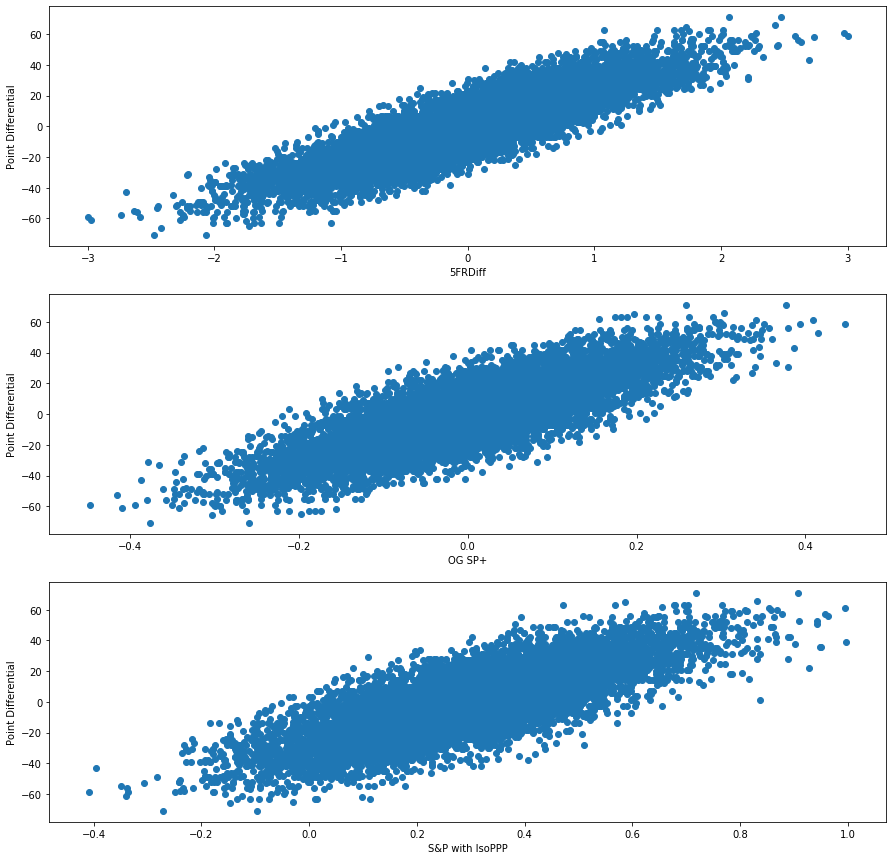

In [20]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [21]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.95089456165382


In [22]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.949951,0.772435
S&PIsoPPPDiff,0.949951,1.000000,0.803297
PtsDiff,0.772435,0.803297,1.000000


In [23]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742,0.841788,2.004783
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742,0.841788,2.004783
0,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487,0.763294,0.190932
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487,0.763294,0.190932
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630,0.529036,0.525062


In [24]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [25]:
# outliers

In [26]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742,0.841788,2.004783
0,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487,0.763294,0.190932
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487,0.763294,0.190932
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630,0.529036,0.525062
1,Ball State,2012,322432050,37.0,11.0,0.979920,96,0.510417,0.083333,6.291667,...,0.225997,0.136838,-1.198972,-1.220103,0.225997,0.136838,5.196315,0.392630,0.529036,0.525062


In [27]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [28]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 24.62785x + 0.02207
Mean Pred Score: -0.16629585814478604
Pred Std Dev: 17.767414634099598
Mean Abs Error: 8.186829768368108
Mdn Abs Error: 7.065043505996109
R-squared: 0.7458630277268867
Adj R-squared: 0.7457418369914203



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.744318,0.544514,0.449147,0.771307,0.565856,0.584968,0.981439,0.498958,0.763539,...,0.203918,0.104457,-0.021889,-0.224436,-0.203918,0.104457,-0.021889,0.861300,0.863806,0.863806
OffSRDiff,0.744318,1.000000,0.438778,0.229922,0.676428,0.339359,0.391453,0.748344,0.738326,0.685618,...,0.196773,0.059114,-0.038915,-0.190946,-0.196773,0.059114,-0.038915,0.959096,0.961172,0.961172
OffERDiff,0.544514,0.438778,1.000000,0.139385,0.488708,0.259092,0.286570,0.533981,0.305310,0.795954,...,0.134850,0.000812,-0.082851,-0.130901,-0.134850,0.000812,-0.082851,0.503482,0.509728,0.509728
FPDiff,0.449147,0.229922,0.139385,1.000000,0.569640,0.054232,0.044465,0.422873,-0.017294,0.187018,...,0.080743,0.389359,0.278857,-0.161407,-0.080743,0.389359,0.278857,0.314083,0.315972,0.315972
OppRateDiff,0.771307,0.676428,0.488708,0.569640,1.000000,0.118034,0.137299,0.769260,0.224272,0.653473,...,0.194469,0.099883,-0.024598,-0.211810,-0.194469,0.099883,-0.024598,0.745877,0.748960,0.748960
OppEffDiff,0.565856,0.339359,0.259092,0.054232,0.118034,1.000000,0.754943,0.557479,0.471704,0.378693,...,0.086489,0.023737,0.001167,-0.095674,-0.086489,0.023737,0.001167,0.464656,0.464885,0.464885
OppPPDDiff,0.584968,0.391453,0.286570,0.044465,0.137299,0.754943,1.000000,0.596203,0.551466,0.432412,...,0.104693,0.017080,-0.015121,-0.117891,-0.104693,0.017080,-0.015121,0.554952,0.556055,0.556055
PPDDiff,0.981439,0.748344,0.533981,0.422873,0.769260,0.557479,0.596203,1.000000,0.503785,0.752693,...,0.208252,0.101148,-0.031390,-0.228167,-0.208252,0.101148,-0.031390,0.865575,0.867888,0.867888
OppSRDiff,0.498958,0.738326,0.305310,-0.017294,0.224272,0.471704,0.551466,0.503785,1.000000,0.494381,...,0.126396,-0.000288,-0.036826,-0.115911,-0.126396,-0.000288,-0.036826,0.728579,0.729572,0.729572
YPPDiff,0.763539,0.685618,0.795954,0.187018,0.653473,0.378693,0.432412,0.752693,0.494381,1.000000,...,0.175702,0.009258,-0.092963,-0.171277,-0.175702,0.009258,-0.092963,0.759761,0.764147,0.764147


In [29]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.721041,0.744318,0.752302,0.900002,0.349604,0.392055,0.861300,0.863806,0.863806
ActPts,0.721041,1.000000,0.532344,0.541645,0.649327,0.244575,0.278059,0.617729,0.619352,0.619352
Eff,0.744318,0.532344,1.000000,0.671909,0.783633,0.374215,0.257119,0.959096,0.961172,0.961172
Expl,0.752302,0.541645,0.671909,1.000000,0.723781,0.271548,0.189646,0.746255,0.750738,0.750738
FinDrv,0.900002,0.649327,0.783633,0.723781,1.000000,0.354105,0.357979,0.914648,0.917360,0.917360
FldPos,0.349604,0.244575,0.374215,0.271548,0.354105,1.000000,0.075130,0.407029,0.409406,0.409406
Trnovr,0.392055,0.278059,0.257119,0.189646,0.357979,0.075130,1.000000,0.400842,0.354007,0.354007
5FR,0.861300,0.617729,0.959096,0.746255,0.914648,0.407029,0.400842,1.000000,0.997521,0.997521
5FRDiff,0.863806,0.619352,0.961172,0.750738,0.917360,0.409406,0.354007,0.997521,1.000000,1.000000
PredPtsDiff,0.863806,0.619352,0.961172,0.750738,0.917360,0.409406,0.354007,0.997521,1.000000,1.000000


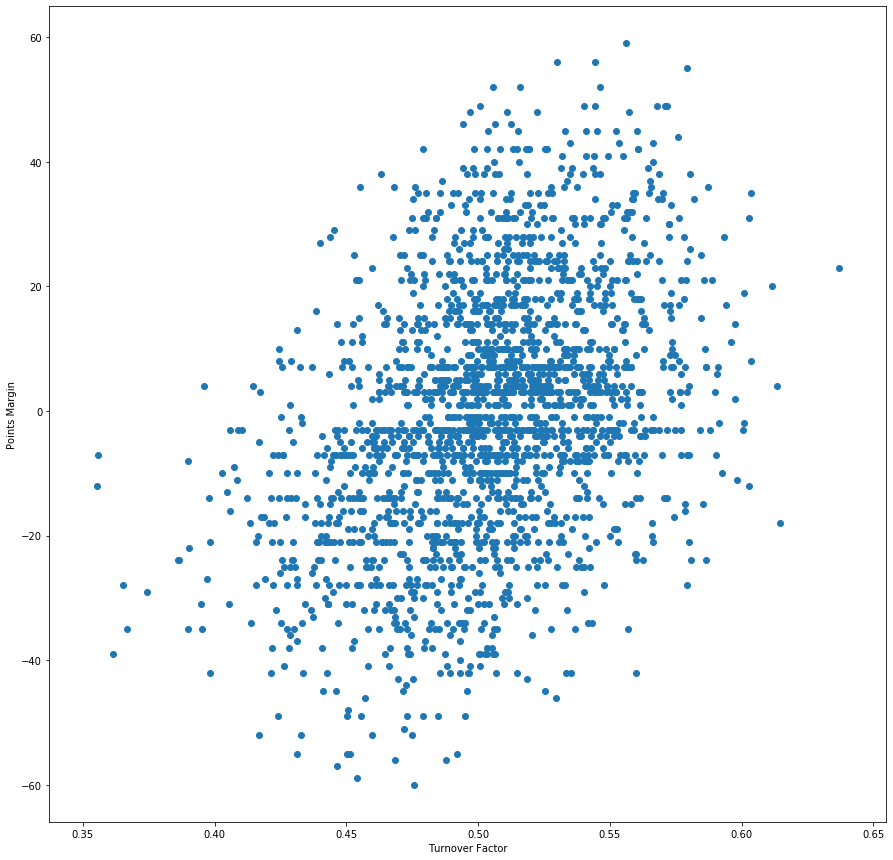

In [30]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

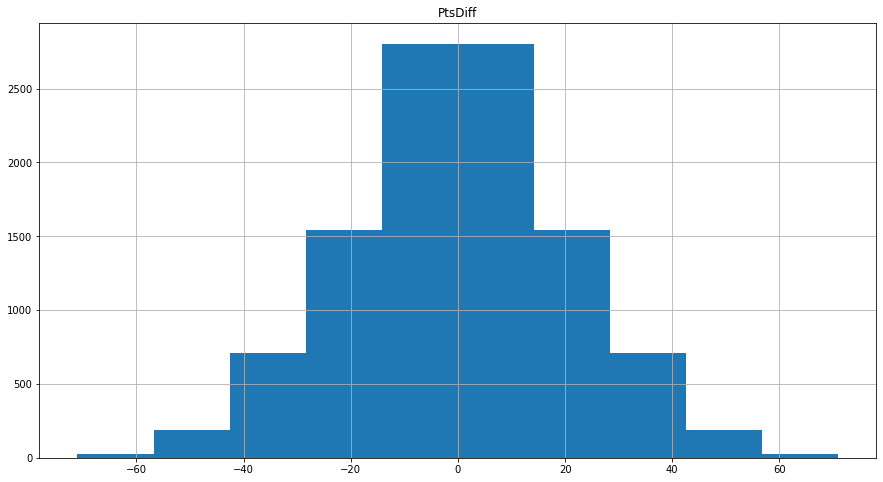

In [31]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

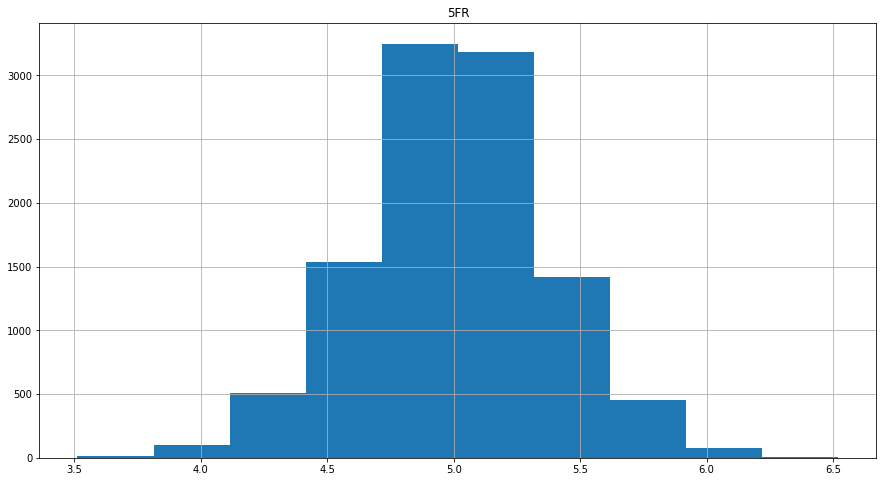

In [32]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

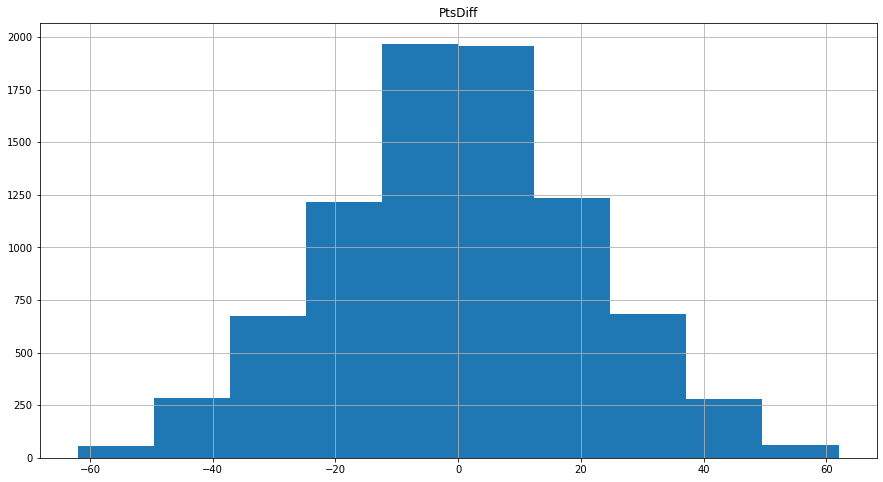

In [33]:
train_data.hist(column='PtsDiff', figsize=(15,8));

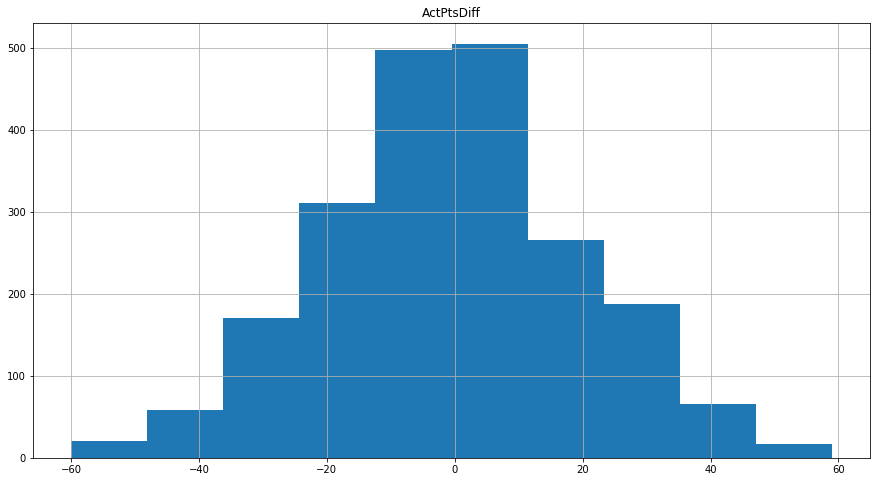

In [34]:
test.hist(column='ActPtsDiff', figsize=(15,8));

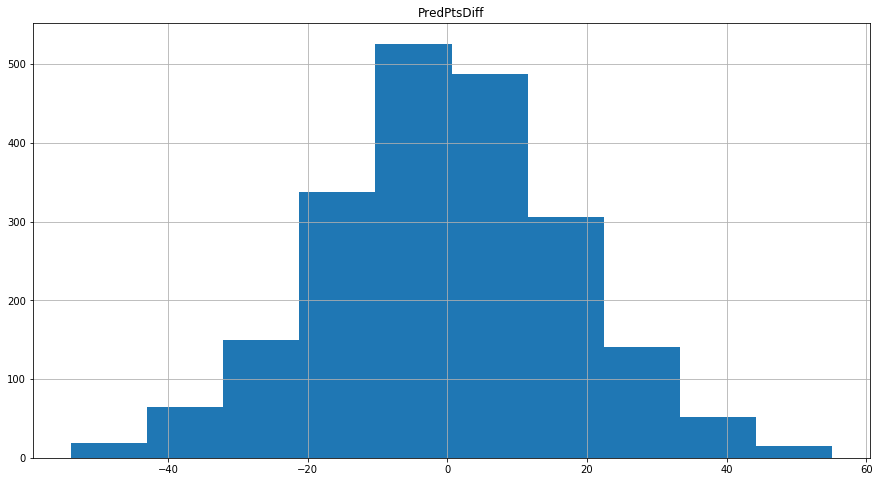

In [35]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [36]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [37]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -4.79233144038781)
Z score: -0.26036627598956563
Win Prob for Virginia Tech: 39.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097129,0.195486
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.901643,-0.195486


In [38]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -1.0 (exact value: -1.0965750774337528)
Z score: -0.05235872739208524
Win Prob for Georgia Tech: 47.91%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.396825,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,5.000088,-0.045422
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.370968,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.045510,0.045422


In [39]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -2.0 (exact value: -1.785543932286335)
Z score: -0.09113582969093623
Win Prob for Georgia Tech: 46.37%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.487500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.036152,0.073397
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.473684,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.962754,-0.073397


In [40]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 1.0 (exact value: 1.0311456785885709)
Z score: 0.06739537301252607
Win Prob for Mississippi State: 52.69%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.422535,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.967197,-0.040973
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.413793,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,5.008170,0.040973


In [41]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -4.0 (exact value: -3.9828435558399504)
Z score: -0.21480602419050687
Win Prob for Texas A&M: 41.50%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.466667,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.081001,0.162617
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.423077,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.918383,-0.162617


In [42]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.948848,13,12.0,1.0
2,LSU,0.936221,13,12.0,1.0
3,Alabama,0.925618,12,11.0,1.0
4,Clemson,0.894975,13,12.0,1.0
5,Oklahoma,0.872448,13,11.0,2.0
...,...,...,...,...,...
126,Connecticut,0.110552,12,1.0,11.0
127,Maryland,0.092775,12,1.0,11.0
128,Akron,0.079645,12,1.0,11.0
129,UMass,0.059534,12,1.0,11.0


In [43]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,10.708535,2.291465
53,LSU,10.629521,2.370479
78,Oklahoma,9.540959,3.459041
115,Utah,8.280005,4.719995
75,Notre Dame,8.257740,3.742260
...,...,...,...
103,Texas State,1.870266,10.129734
25,Connecticut,1.845607,10.154393
1,Akron,1.789738,10.210262
112,UMass,1.331749,10.668251


In [44]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2021):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Florida State,2012,5.424575,1
1,Alabama,2012,5.399574,2
2,Arizona State,2012,5.336245,3
3,Notre Dame,2012,5.278415,4
4,Georgia,2012,5.248564,5
...,...,...,...,...
1098,East Carolina,2020,4.591110,71
1099,Vanderbilt,2020,4.578394,72
1100,Louisiana Monroe,2020,4.552368,73
1101,Syracuse,2020,4.517528,74


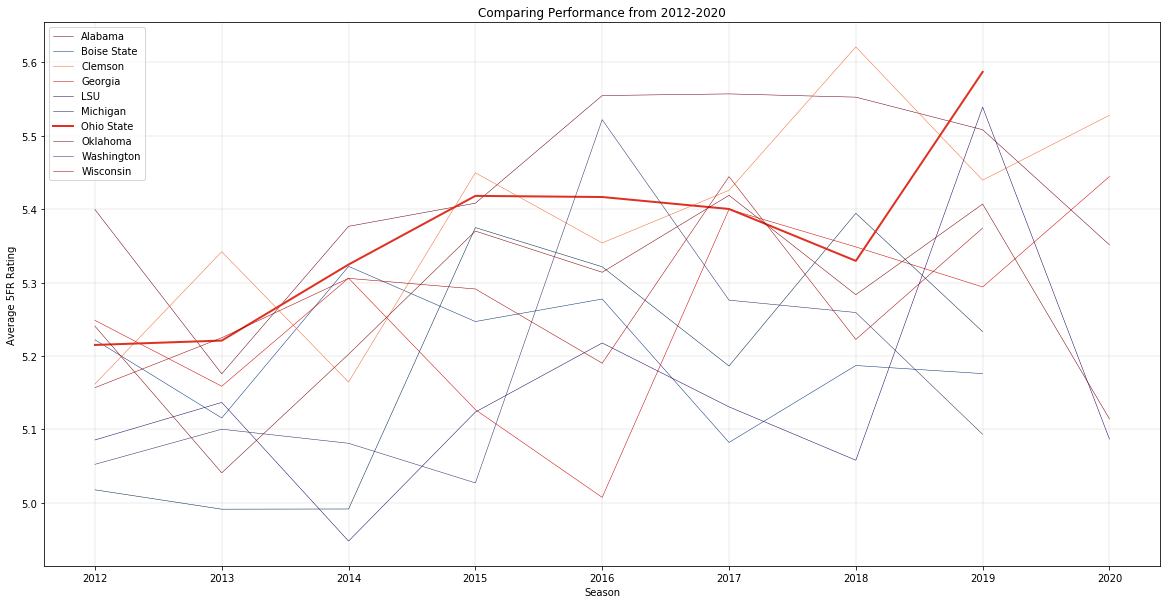

In [45]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [46]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.431628
1,Clemson,5.387395
2,Ohio State,5.364059
3,Wisconsin,5.276272
4,Oklahoma,5.265740
...,...,...
125,Connecticut,4.761715
126,UTEP,4.760347
127,UMass,4.753680
128,New Mexico State,4.751420


In [47]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
1028,Air Force,2020,5.821850,1
1029,BYU,2020,5.761986,2
768,Clemson,2018,5.621188,1
1030,Appalachian State,2020,5.596522,3
898,Ohio State,2019,5.587154,1
638,Alabama,2017,5.557155,1
510,Alabama,2016,5.554906,1
769,Alabama,2018,5.552709,2
126,Florida State,2013,5.542778,1
899,LSU,2019,5.539098,2


In [48]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
276,Georgia Tech,2014,5.163879,23
1055,Georgia Tech,2020,5.096640,28
53,Georgia Tech,2012,5.034246,54
723,Georgia Tech,2017,4.959406,86
207,Georgia Tech,2013,4.915070,82
857,Georgia Tech,2018,4.905974,90
598,Georgia Tech,2016,4.900641,89
467,Georgia Tech,2015,4.895461,86
998,Georgia Tech,2019,4.846594,101


In [49]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
...,...,...,...,...,...
10329,401117533.0,Nevada,2019.0,Wyoming,7.0
10330,401117541.0,Boise State,2019.0,Wyoming,8.0
10331,401117546.0,Utah State,2019.0,Wyoming,9.0
10332,401117550.0,Colorado State,2019.0,Wyoming,10.0


In [50]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2020, 0, -1, True)

[0.12661844268569233, -20.465967428108637]

In [51]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,5.232379,0.619380,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,4.770494,0.609439,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-9.749542,0.294815,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,2.183538,0.552609,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-10.090801,0.288225,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-3.867182,0.417499,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-0.895827,0.483624,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,7.712727,0.671281,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,5.102498,0.616592,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,3.418339,0.579945,True,BYU,BYU,Hawai'i,Hawai'i


In [52]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 17-23
ML Record: 25-15


In [53]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 1.0 (exact value: 1.4528166118011725)
Z score: 0.09112819750592883
Win Prob for Virginia: 53.63%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.432432,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,4.950479,-0.058095
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.381818,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,5.008574,0.058095


In [54]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 9.075983511854004)
Z score: 0.5201814422825936
Win Prob for North Carolina: 69.85%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.457447,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.194658,0.367629
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.396226,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.827029,-0.367629


In [55]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.031805013219547)
Z score: 1.0805230398866772
Win Prob for Pittsburgh: 86.00%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.362319,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.368209,0.771879
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.204082,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.596329,-0.771879


In [56]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12.0 (exact value: -12.07980321835161)
Z score: -0.67052565640823
Win Prob for Auburn: 25.13%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.453333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.23668,0.49139
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.338710,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.74529,-0.49139


In [57]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.15692381101485)
Z score: 1.9318072086462026
Win Prob for Georgia: 97.33%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,72,0.472222,0.138889,6.847222,...,0.688628,NaN,0.831684,0.594622,-0.688628,-0.660553,0.831684,0.594622,5.707078,1.386026
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,58,0.224138,0.034483,2.396552,...,-0.688628,NaN,-0.831684,-0.594622,0.688628,0.660553,-0.831684,-0.594622,4.321052,-1.386026


In [58]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 21.0 (exact value: 20.56954891400217)
Z score: 1.16707158577536
Win Prob for Clemson: 87.84%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 13.0 (exact value: 12.50362394373145)
Z score: 0.7130986732059406
Win Prob for Georgia Tech: 76.21%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -5.0 (exact value: -4.785577579393278)
Z score: -0.25998614972282286
Win Prob for The Citadel: 39.74%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 19.0 (exact value: 19.045785988481086)
Z score: 1.0813099284435923
Win Prob for Temple: 86.02%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 9.075983511854004)
Z score: 0.5201814422825936


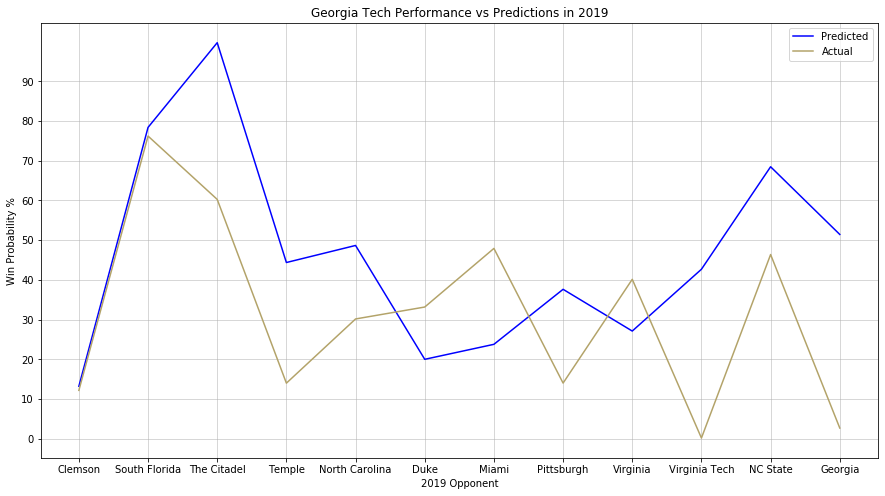

In [59]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

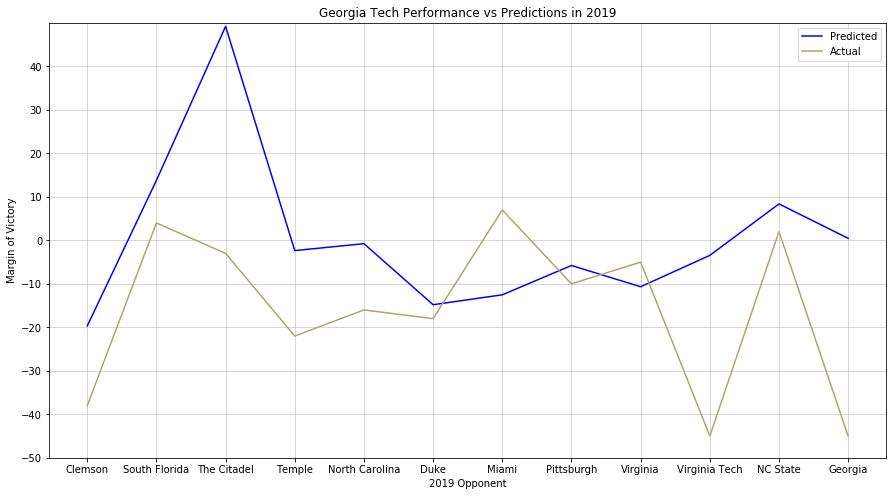

In [60]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.22344739462862)
Z score: 2.273248195337129
Win Prob for Georgia Tech: 98.85%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -3.0 (exact value: -2.8902422244156067)
Z score: -0.15331135240368426
Win Prob for South Florida: 43.91%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 3.0 (exact value: 3.4832484063630185)
Z score: 0.2054066018982594
Win Prob for Pittsburgh: 58.14%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 39.0 (exact value: 39.21143620428241)
Z score: 2.2162893630485
Win Prob for Clemson: 98.67%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 36.0 (exact value: 36.201673727864886)
Z sco

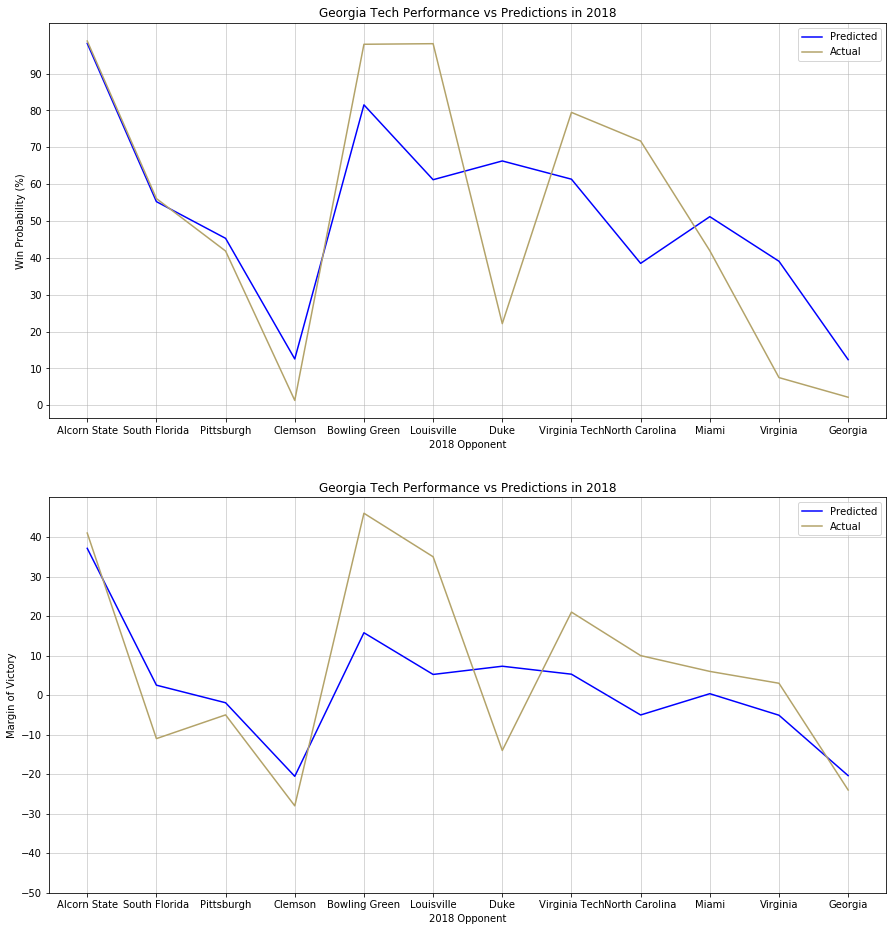

In [61]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

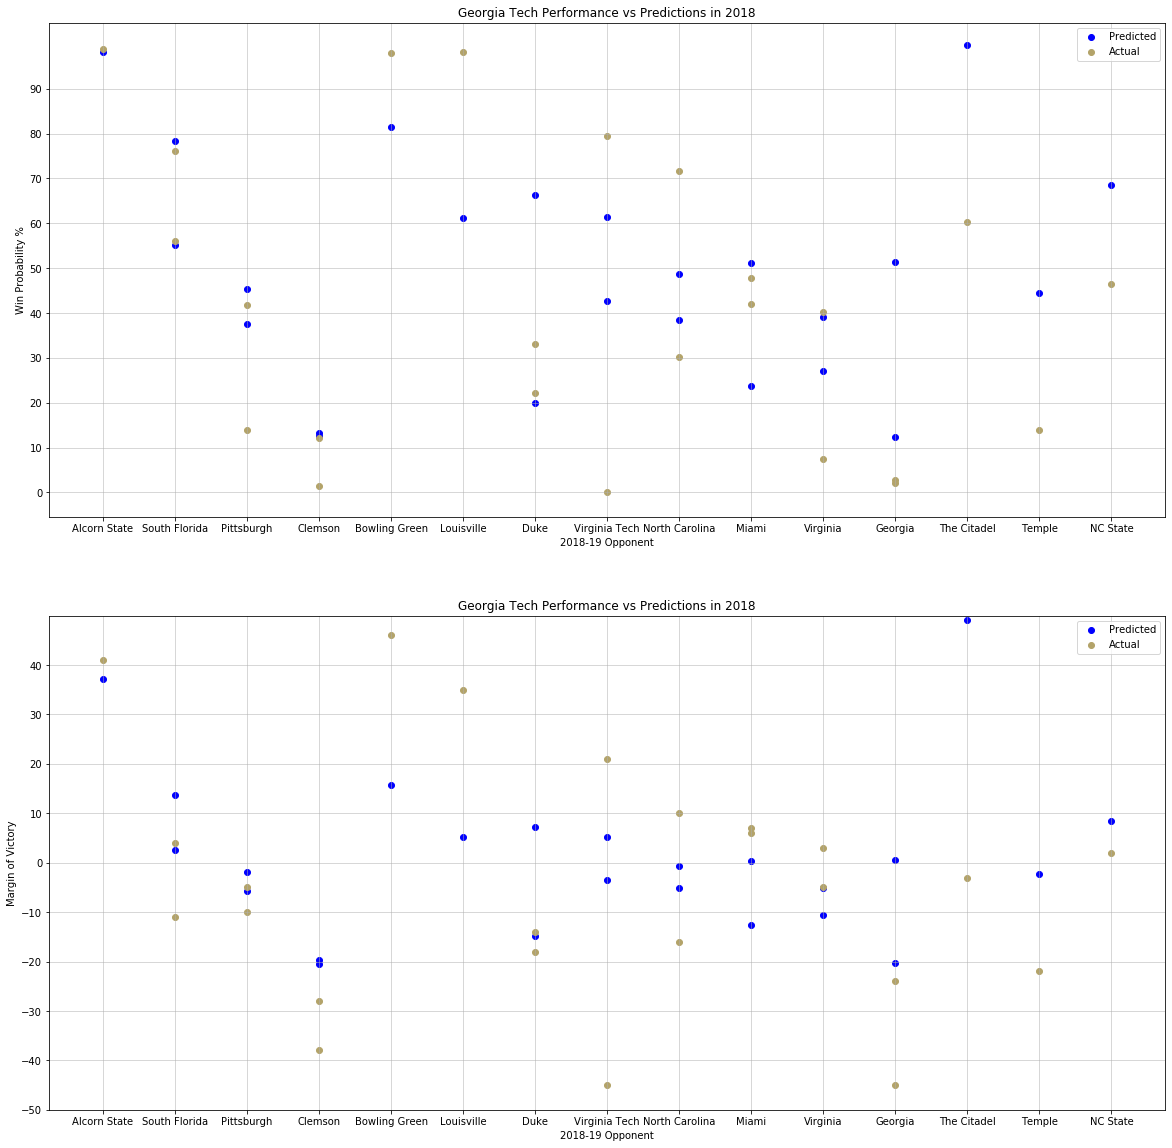

In [62]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [63]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,
2012,1.000000,0.589968,0.433165,0.413175,0.319913,0.257924,0.252010,0.304181,0.266783
2013,0.589968,1.000000,0.509891,0.345305,0.232832,0.259887,0.200100,0.288702,0.023358
2014,0.433165,0.509891,1.000000,0.539923,0.377669,0.301211,0.283678,0.327604,0.130324
2015,0.413175,0.345305,0.539923,1.000000,0.605279,0.423373,0.338788,0.365003,0.323557
2016,0.319913,0.232832,0.377669,0.605279,1.000000,0.533999,0.343896,0.481320,0.298611
2017,0.257924,0.259887,0.301211,0.423373,0.533999,1.000000,0.597994,0.492423,0.329443
2018,0.252010,0.200100,0.283678,0.338788,0.343896,0.597994,1.000000,0.559105,0.419068
2019,0.304181,0.288702,0.327604,0.365003,0.481320,0.492423,0.559105,1.000000,0.418965
2020,0.266783,0.023358,0.130324,0.323557,0.298611,0.329443,0.419068,0.418965,1.000000


In [64]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 4.049831244550795


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,26.021274,-11.252638
1,2020,Georgia Tech,UCF,Home,45.757787,-2.059196
2,2020,Georgia Tech,Syracuse,Away,53.271291,1.624845
3,2020,Georgia Tech,Louisville,Home,46.235558,-1.845335
4,2020,Georgia Tech,Clemson,Home,10.992130,-21.965967
5,2020,Georgia Tech,Boston College,Away,46.414119,-1.432880
6,2020,Georgia Tech,Notre Dame,Home,19.338539,-15.543787
7,2020,Georgia Tech,Pittsburgh,Home,39.224341,-5.025269
8,2020,Georgia Tech,Miami,Away,22.667180,-13.156643
9,2020,Georgia Tech,Duke,Home,48.607109,-0.786764


In [65]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 5.420356066447364


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,20.312921,-14.589471
1,2019,Georgia Tech,South Florida,Home,57.690809,3.280402
2,2019,Georgia Tech,The Citadel,Home,97.644836,35.108602
3,2019,Georgia Tech,Temple,Away,36.792668,-5.827535
4,2019,Georgia Tech,North Carolina,Home,54.493476,1.839183
5,2019,Georgia Tech,Duke,Away,44.276984,-2.391329
6,2019,Georgia Tech,Miami,Away,37.165316,-5.652143
7,2019,Georgia Tech,Pittsburgh,Home,47.931258,-1.088050
8,2019,Georgia Tech,Virginia,Away,37.641817,-5.428692
9,2019,Georgia Tech,Virginia Tech,Home,50.348934,-0.010891


In [84]:
line_data = pd.DataFrame()

for i in range(2013, 2021):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    if "ï»¿id" in ln.columns:
        ln["id"] = ln["ï»¿id"]
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")
# print(f"2020 Spreads imported: {len(line_data[line_data.year == 2020].id.to_list())}")
# games[(games.id.isin(line_data[line_data.year == 2020].id.to_list()))].head()

Spreads imported: 17779


In [85]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [86]:
historic_validation = pd.DataFrame()
for i in range(2013, 2021):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 604 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 597 games with betting lines for 2013 season.
[Simulation] Creating projections for 597 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 619 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 571 games with betting lines for 2014 season.
[Simulation] Creating projections for 571 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 662 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 632 games with betting lines for 2015 season.
[Simulation] Creating projections for 632 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,452,145,0,0.757119
1,ATS,2013,346,244,7,0.579564
0,ML,2014,431,140,0,0.754816
1,ATS,2014,351,206,14,0.614711
0,ML,2015,493,139,0,0.780063
1,ATS,2015,380,235,17,0.601266
0,ML,2016,480,145,0,0.768000
1,ATS,2016,387,221,17,0.619200
0,ML,2017,524,158,0,0.768328
1,ATS,2017,403,260,19,0.590909


In [87]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2020) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2020) if betting $5 per game: $3663.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,346,244,7,0.579564,2985,388.0,24.250000,0.129983
1,ATS,2014,351,206,14,0.614711,2855,622.0,38.875000,0.217863
1,ATS,2015,380,235,17,0.601266,3160,607.5,40.500000,0.192247
1,ATS,2016,387,221,17,0.619200,3125,719.5,47.966667,0.230240
1,ATS,2017,403,260,19,0.590909,3410,585.0,39.000000,0.171554
1,ATS,2018,349,251,17,0.565640,3085,364.5,24.300000,0.118152
1,ATS,2019,386,279,11,0.571006,3380,395.5,26.366667,0.117012
1,ATS,2020,41,41,1,0.493976,415,-20.5,-3.416667,-0.049398


In [88]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7546116135976878
Avg ATS Win %: 0.5795340564180964


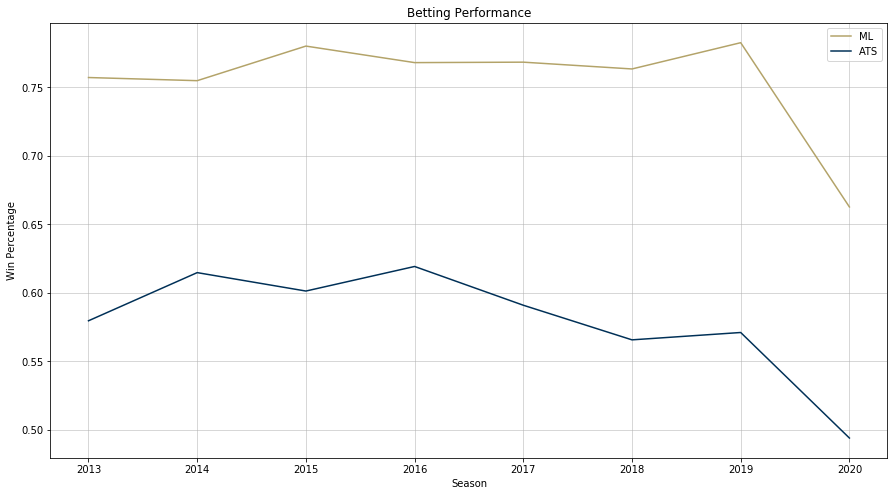

In [89]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [90]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [91]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6526799121055149, 6.808584145313693]

In [92]:
# generate_win_prob(401135295, 2019)

In [93]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [94]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

,Team,5FRSRS,5FRSRSRank
53,LSU,0.810966,1
77,Ohio State,0.711046,2
2,Alabama,0.563809,3
78,Oklahoma,0.426440,4
128,Wisconsin,0.404158,5
...,...,...,...
80,Old Dominion,-1.607994,126
25,Connecticut,-1.666568,127
14,Bowling Green,-2.038094,128
1,Akron,-2.125614,129


In [95]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 10.0 (exact value: 9.869330019413857)
Z score: 0.564833212047523
Win Prob for Georgia Tech: 71.39%
---


[0.713906392665569, 3.0]

In [96]:
generate_win_prob(401234568, 2020)

Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 11.0 (exact value: 10.835674329604872)
Z score: 0.6192217840537386
Win Prob for UCF: 73.21%
---


[0.7321148685376908, 28.0]

In [97]:
generate_win_prob(401234594, 2020)

Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -2.0 (exact value: -1.6811679862023703)
Z score: -0.08526125827841095
Win Prob for Syracuse: 46.60%
---


[0.4660268453769596, 17.0]

In [98]:
generate_win_prob(401234601, 2020)

Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 14.0 (exact value: 14.088426189176648)
Z score: 0.802295794907801
Win Prob for Georgia Tech: 78.88%
---


[0.7888090628506523, 19.0]

In [99]:
predict_matchup("Houston", "BYU", 2020, 0, -1,True, True)

[0.5334621181457729, 1.3257349635751892]

In [108]:
preds_2020 = [
    ["Miami","Virginia",12],
    ["Texas","Baylor",10.5],
    ["BYU","Texas State",28],
    ["Michigan","Minnesota",3],
    ["Auburn","Ole Miss",3],
    ["Ohio State","Nebraska",26]
]

bets_2020 = pd.DataFrame()
for data in preds_2020:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    # preseason picks because not everyone has played games yet; otherwise week == 7; games to consider == 4
    predictor = predict_matchup(team1, team2, 2020, week = 0, games_to_consider = -1, adjust_hfa = True, adjust_covid = True)
    bets_2020 = bets_2020.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets_2020

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Virginia,12.0,8.163165,0.680396,False,Miami,Virginia
0,Texas,Baylor,10.5,7.816132,0.673383,False,Texas,Baylor
0,BYU,Texas State,28.0,12.399154,0.760285,False,BYU,Texas State
0,Michigan,Minnesota,3.0,11.302222,0.740692,True,Michigan,Michigan
0,Auburn,Ole Miss,3.0,13.528723,0.779586,True,Auburn,Auburn
0,Ohio State,Nebraska,26.0,22.619141,0.900154,False,Ohio State,Nebraska


In [101]:
line_data[line_data.year == 2020].head()


,id,homeTeam,homeScore,awayTeam,awayScore,lineProvider,overUnder,spread,formattedSpread,year,ï»¿id
0,401234576,Navy,3.0,BYU,55.0,Bovada,48.0,1.0,BYU -1.0,2020,401234576.0
1,401234576,Navy,3.0,BYU,55.0,Caesars,48.0,1.5,BYU -1.5,2020,401234576.0
2,401234576,Navy,3.0,BYU,55.0,consensus,48.5,1.0,BYU -1,2020,401234576.0
3,401234576,Navy,3.0,BYU,55.0,numberfire,48.5,1.5,BYU -1.5,2020,401234576.0
4,401234576,Navy,3.0,BYU,55.0,teamrankings,48.5,1.0,BYU -1,2020,401234576.0
